# Vision and Cognitive Systems Project

## Import libraries and config

In [ ]:
################
#### Import ####
################

from google.colab import drive
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets
 
import torchvision
from torchvision import transforms
from torchvision import models
 
import torch.nn.functional as F
import torchvision.transforms.functional as TF
 
import albumentations
 
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time
import nibabel as nib
from tqdm import tqdm
import pandas as pd

import skimage
from skimage import img_as_ubyte, img_as_float32

from glob import glob

np.random.seed(108)

plt.style.use('default')
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
visualize = False

In [ ]:
############################################
#### Configuration tiny imagnet dataset #### 
############################################

class Config():
  ROOT = 'tiny-imagenet-200'
  TRAIN_PATH = 'tiny-imagenet-200/train'
  VAL_PATH = 'tiny-imagenet-200/val'
  TEST_PATH = 'tiny-imagenet-200/test'
  subset_data = 1000
  patch_dim = 15
  gap = 3
  batch_size = 64
  num_epochs = 60
  lr = 0.0005

## Download Dataset

In [ ]:
################
# load tiny imagnet dataset: The dataset contains 100,000 images of 200 classes (500 for each class) downsized to 64×64 colored images. 
# Each class has 500 training images, 50 validation images, and 50 test images
################

!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2023-05-13 07:57:15--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  13.9MB/s    in 19s     

2023-05-13 07:57:34 (12.7 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



### Datasets creation for Context Prediction and Image Classification

In [ ]:
df_train_folder_dataset = []

classes = os.listdir(Config.TRAIN_PATH)

for idx, each_class in enumerate(classes):
  images_in_each_class = glob(f'{Config.TRAIN_PATH}/{each_class}/**/*.JPEG')  
  df_train_folder_dataset += [[each_image, each_class] for each_image in images_in_each_class]

df_train_folder_dataset = pd.DataFrame(data=df_train_folder_dataset, columns=['filename', 'class'])

In [ ]:
df_validation_folder_dataset = []

validation_annotations = open(f'{Config.VAL_PATH}/val_annotations.txt', "r")

for line in validation_annotations:
  splitted = line.split("\t")
  df_validation_folder_dataset += [[f'{Config.VAL_PATH}/images/{splitted[0]}', splitted[1]]]

df_validation_folder_dataset = pd.DataFrame(data=df_validation_folder_dataset, columns=['filename', 'class'])

In [ ]:
complete_dataset = [df_train_folder_dataset, df_validation_folder_dataset]

df_dataset = pd.concat(complete_dataset)

In [ ]:
num_classes_subset = 10
classes = classes[:num_classes_subset]
used_classes = df_dataset['class'].unique()[:num_classes_subset]

df_dataset = df_dataset[df_dataset['class'].isin(used_classes)]

In [ ]:
df_context_prediction = pd.DataFrame(data=[], columns=['filename', 'class'])
df_image_classification = pd.DataFrame(data=[], columns=['filename', 'class'])

for c in classes:
  df_context_prediction = pd.concat([df_context_prediction, df_dataset.loc[df_dataset['class'] == c][:150]])
  df_image_classification = pd.concat([df_image_classification, df_dataset.loc[df_dataset['class'] == c][150:]])

In [ ]:
print(df_context_prediction)

                                               filename      class
0     tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
1     tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
2     tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
3     tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
4     tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
...                                                 ...        ...
4645  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810
4646  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810
4647  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810
4648  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810
4649  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810

[1500 rows x 2 columns]


In [ ]:
print(df_image_classification)

                                               filename      class
150   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
151   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
152   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
153   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
154   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
...                                                 ...        ...
8535         tiny-imagenet-200/val/images/val_8535.JPEG  n07871810
8663         tiny-imagenet-200/val/images/val_8663.JPEG  n07871810
8882         tiny-imagenet-200/val/images/val_8882.JPEG  n07871810
8911         tiny-imagenet-200/val/images/val_8911.JPEG  n07871810
9236         tiny-imagenet-200/val/images/val_9236.JPEG  n07871810

[4000 rows x 2 columns]


### Datasets

*df_context_prediction* => 10 classes, 150 images for each class

*df_image_classification* => 10 classes, 400 images for each class

*classes* => ID of the used classes

<br>

Note: *df_context_prediction* and *df_image_classification* contain different images

## Useful Functions

In [ ]:
##########################
###  Useful functions  ###
##########################

def imshow(img,text=None,should_save=False):
    plt.figure(figsize=(10, 10))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  

def show_plot(iteration,loss,fname):
    plt.plot(iteration,loss)
    plt.savefig(fname)
    plt.show()

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
def convert_format(data, format):
  if format == 'p':
    return np.transpose(data, (0, 3, 1, 2))
  if format == 'n':
    return np.transpose(data, (0, 2, 3, 1))
  if format == '3':
    return np.transpose(data, (1, 2, 0))

### Plot Functions

In [ ]:
def loss_plot(train_loss, val_loss, model_name, top_y = 2.3, bottom_y = 1.8):
  plt.plot(range(len(train_loss)), train_loss, label='TRAIN Loss', color='blue')
  plt.plot(range(len(val_loss)), val_loss, label='VAL Loss', color='green')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.ylim(top=top_y)
  plt.ylim(bottom=bottom_y)
  plt.title(f'Training and Validation Loss - {model_name}')
  plt.legend()
  plt.show()

In [ ]:
def accuracy_plot(accuracy, model_name):
  accuracy = [i.item() for i in accuracy]
  plt.plot(range(len(accuracy)), accuracy, label='Accuracy', color='green')
  plt.xlabel('Epochs')
  plt.ylabel('Validation Accuracy')
  plt.title(f'Validation accuracy - {model_name}')
  plt.legend()
  plt.show()

## Context Prediction

#### The Task

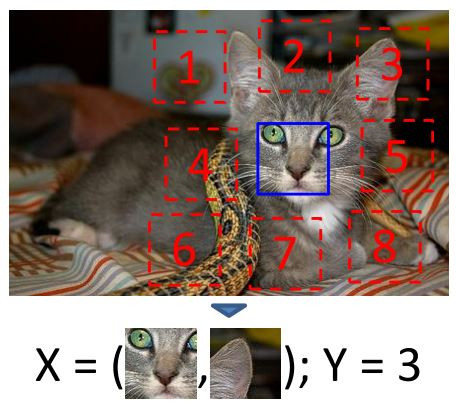 <br> <br>
The task is sample the central patch and a random patch in one of the eight spatial configurations, and present each pair of patches to a machine learner, providing no information about the second patch original position within the image. The algorithm must then guess the position of one patch relative to the other. As stated on the paper "Unsupervised Visual Representation Learning by Context Prediction (Carl Doersch, Abhinav Gupta, Alexei A. Efros)" doing well on this task requires understanding scenes and objects, i.e. a good visual representation for this task will need to extract objects and their parts in order to reason about their relative spatial location.

#### Training and Validation Set creation

In [ ]:
# 150 immages for each class => 125 training - 25 validation

df_context_prediction_train = pd.DataFrame(data=[], columns=['filename', 'class'])
df_context_prediction_val = pd.DataFrame(data=[], columns=['filename', 'class'])

for c in classes:
  df_context_prediction_train = pd.concat([df_context_prediction_train, df_context_prediction.loc[df_context_prediction['class'] == c][:125]])
  df_context_prediction_val = pd.concat([df_context_prediction_val, df_context_prediction.loc[df_context_prediction['class'] == c][125:]])

In [ ]:
print(df_context_prediction_train)

                                               filename      class
0     tiny-imagenet-200/train/n01629819/images/n0162...  n01629819
1     tiny-imagenet-200/train/n01629819/images/n0162...  n01629819
2     tiny-imagenet-200/train/n01629819/images/n0162...  n01629819
3     tiny-imagenet-200/train/n01629819/images/n0162...  n01629819
4     tiny-imagenet-200/train/n01629819/images/n0162...  n01629819
...                                                 ...        ...
4620  tiny-imagenet-200/train/n02509815/images/n0250...  n02509815
4621  tiny-imagenet-200/train/n02509815/images/n0250...  n02509815
4622  tiny-imagenet-200/train/n02509815/images/n0250...  n02509815
4623  tiny-imagenet-200/train/n02509815/images/n0250...  n02509815
4624  tiny-imagenet-200/train/n02509815/images/n0250...  n02509815

[1250 rows x 2 columns]


In [ ]:
print(df_context_prediction_val)

                                               filename      class
125   tiny-imagenet-200/train/n01629819/images/n0162...  n01629819
126   tiny-imagenet-200/train/n01629819/images/n0162...  n01629819
127   tiny-imagenet-200/train/n01629819/images/n0162...  n01629819
128   tiny-imagenet-200/train/n01629819/images/n0162...  n01629819
129   tiny-imagenet-200/train/n01629819/images/n0162...  n01629819
...                                                 ...        ...
4645  tiny-imagenet-200/train/n02509815/images/n0250...  n02509815
4646  tiny-imagenet-200/train/n02509815/images/n0250...  n02509815
4647  tiny-imagenet-200/train/n02509815/images/n0250...  n02509815
4648  tiny-imagenet-200/train/n02509815/images/n0250...  n02509815
4649  tiny-imagenet-200/train/n02509815/images/n0250...  n02509815

[250 rows x 2 columns]


#### Training Function

In [ ]:
##############################
# Training/Validation Engine #
##############################

def model_training(model, optimizer, criterion, scheduler, model_name):
  global_trn_loss = []
  global_val_loss = []
  accuracy = []

  for epoch in range(Config.num_epochs):
      train_running_loss = []
      val_running_loss = []
      start_time = time.time()
      model.train()
      for idx, data in tqdm(enumerate(trainloader), total=int(len(traindataset)/Config.batch_size)):
          uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
          optimizer.zero_grad()
          output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
          loss = criterion(output, random_patch_label)
          loss.backward()
          optimizer.step()
          
          train_running_loss.append(loss.item())
      else:
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
          for idx, data in tqdm(enumerate(valloader), total=int(len(valdataset)/Config.batch_size)):
            uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
            output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
            loss = criterion(output, random_patch_label)
            val_running_loss.append(loss.item())
          
            _, predicted = torch.max(output.data, 1)
            total += random_patch_label.size(0)
            correct += (predicted == random_patch_label).sum()
          print('Val Progress --- total:{}, correct:{}'.format(total, correct.item()))
          print('Val accuracy: {:.3f}%'.format(100 * correct / total))

      global_trn_loss.append(sum(train_running_loss) / len(train_running_loss))
      global_val_loss.append(sum(val_running_loss) / len(val_running_loss))
      accuracy.append(100 * correct / total)

      scheduler.step(global_val_loss[-1])

      print('Epoch [{}/{}], TRNLoss:{:.4f}, VALLoss:{:.4f}, Time:{:.2f}'.format(
          epoch + 1, Config.num_epochs, global_trn_loss[-1], global_val_loss[-1],
          (time.time() - start_time) / 60))
      
  MODEL_SAVE_PATH = f'/content/model_{model_name}.pt'
  torch.save(
    {
      'epoch': Config.num_epochs,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss,
      'global_trnloss': global_trn_loss,
      'global_valloss': global_val_loss,
      'accuracy' : accuracy
    }, MODEL_SAVE_PATH)

#### Patches 3x3

##### MyDataset Class

In [ ]:
###################################################
#### This class generates patches for training ####
###################################################

class MyDataset(Dataset):
  def __init__(self, patch_dim, gap, df, validate, transform=None):
    self.patch_dim, self.gap = patch_dim, gap
    self.transform = transform
    self.train_data = df.values
  
  def get_patch_from_grid(self, image, patch_dim, gap):
    image = np.array(image)

    offset_x, offset_y = image.shape[0] - (patch_dim*3 + gap*2), image.shape[1] - (patch_dim*3 + gap*2)
    start_grid_x, start_grid_y = np.random.randint(0, offset_x), np.random.randint(0, offset_y)
    patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]
    loc = np.random.randint(len(patch_loc_arr))
    tempx, tempy = patch_loc_arr[loc]
    
    patch_x_pt = start_grid_x + patch_dim * (tempx-1) + gap * (tempx-1)
    patch_y_pt = start_grid_y + patch_dim * (tempy-1) + gap * (tempy-1)
    random_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]

    patch_x_pt = start_grid_x + patch_dim * (2-1) + gap * (2-1)
    patch_y_pt = start_grid_y + patch_dim * (2-1) + gap * (2-1)
    uniform_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]
    
    random_patch_label = loc
    
    return uniform_patch, random_patch, random_patch_label

  def __len__(self):
    return len(self.train_data)
  
  def __getitem__(self, index):
    image = Image.open(self.train_data[index]).convert('RGB')
    uniform_patch, random_patch, random_patch_label = self.get_patch_from_grid(image, 
                                                                               self.patch_dim, 
                                                                               self.gap)
    if uniform_patch.shape[0] != 96:
        uniform_patch = skimage.transform.resize(uniform_patch, (96, 96))
        random_patch = skimage.transform.resize(random_patch, (96, 96))
        
        uniform_patch = img_as_float32(uniform_patch)
        random_patch = img_as_float32(random_patch)

    random_patch_label = np.array(random_patch_label).astype(np.int64)
        
    if self.transform:
      uniform_patch = self.transform(uniform_patch)
      random_patch = self.transform(random_patch)

    return uniform_patch, random_patch, random_patch_label

##### Datasets Loaders

In [ ]:
##########################################################
#### Creating Train/Validation dataset and dataloader ####
##########################################################

traindataset = MyDataset(Config.patch_dim, Config.gap, df_context_prediction_train['filename'], False,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                  std=[0.229, 0.224, 0.225])]))
trainloader = torch.utils.data.DataLoader(traindataset, 
                                          batch_size=Config.batch_size,
                                          shuffle=True)

valdataset = MyDataset(Config.patch_dim, Config.gap, df_context_prediction_val['filename'], True,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                  std=[0.229, 0.224, 0.225])]))
valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=Config.batch_size,
                                        shuffle=False)

##### Datasets Visualization

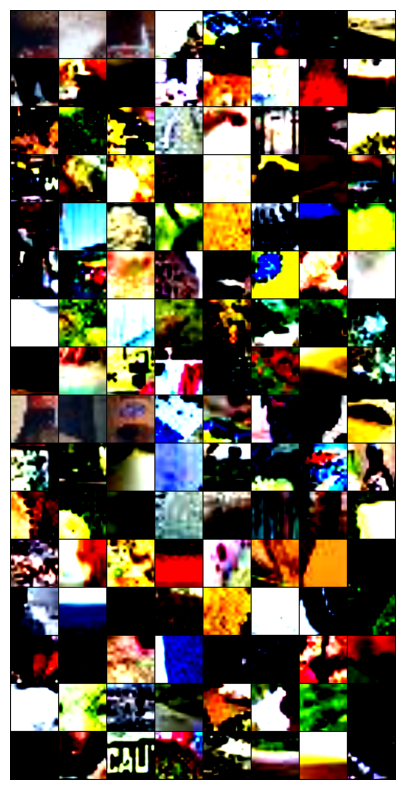

Labels: [1 2 1 6 1 6 4 0 6 3 7 0 6 2 7 1 1 1 0 6 6 0 5 3 6 3 4 5 3 1 4 7 7 7 6 0 4
 3 6 2 1 0 2 2 0 3 0 2 2 0 7 5 0 4 1 4 2 4 0 6 0 6 2 3]


In [ ]:
######################################
#### Visualizing training dataset ####
######################################

example_batch = next(iter(trainloader))
concatenated = torch.cat((unorm(example_batch[0]),unorm(example_batch[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch[2].numpy()}')

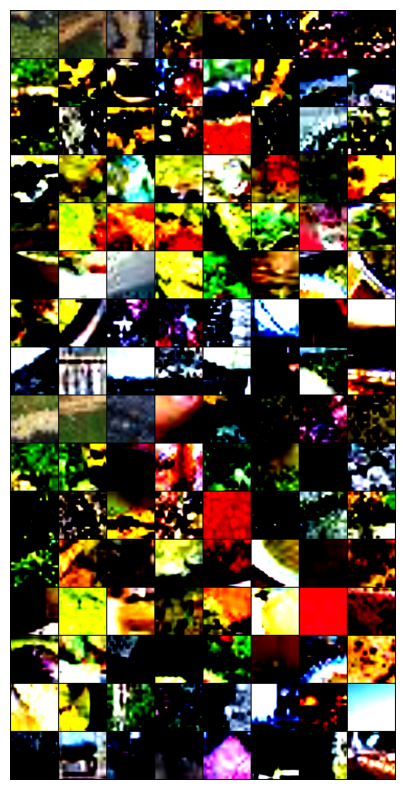

Labels: [1 4 3 5 4 6 4 6 4 3 7 4 7 0 0 7 5 1 2 5 6 4 5 5 5 3 3 4 7 5 0 5 7 3 2 0 4
 7 7 6 6 4 5 1 6 2 3 3 5 1 4 2 1 3 6 1 6 6 7 7 7 6 5 3]


In [ ]:
########################################
#### Visualizing validation dataset ####
########################################

example_batch_val = next(iter(valloader))
concatenated = torch.cat((unorm(example_batch_val[0]),unorm(example_batch_val[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch_val[2].numpy()}')

##### Baseline Model

In [ ]:
##########################
####     Baseline     ####
##########################

class BaselineModel(nn.Module):
  def __init__(self, aux_logits = False):
      super(BaselineModel, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(256, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )

      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output

  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

baseline_model = BaselineModel().to(device)

###### Baseline Model Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(baseline_model.parameters(), lr=Config.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(baseline_model, optimizer, criterion, scheduler, 'baseline')

20it [00:17,  1.17it/s]
4it [00:02,  1.83it/s]


Val Progress --- total:250, correct:36
Val accuracy: 14.400%
Epoch [1/60], TRNLoss:2.2614, VALLoss:2.1199, Time:0.32


20it [00:07,  2.52it/s]
4it [00:01,  2.90it/s]


Val Progress --- total:250, correct:36
Val accuracy: 14.400%
Epoch [2/60], TRNLoss:2.0836, VALLoss:2.0828, Time:0.16


20it [00:08,  2.26it/s]
4it [00:01,  2.89it/s]


Val Progress --- total:250, correct:37
Val accuracy: 14.800%
Epoch [3/60], TRNLoss:2.0807, VALLoss:2.0820, Time:0.17


20it [00:08,  2.27it/s]
4it [00:01,  2.84it/s]


Val Progress --- total:250, correct:40
Val accuracy: 16.000%
Epoch [4/60], TRNLoss:2.0708, VALLoss:2.0616, Time:0.17


20it [00:09,  2.20it/s]
4it [00:01,  2.63it/s]


Val Progress --- total:250, correct:38
Val accuracy: 15.200%
Epoch [5/60], TRNLoss:2.0700, VALLoss:2.0857, Time:0.18


20it [00:09,  2.18it/s]
4it [00:02,  1.91it/s]


Val Progress --- total:250, correct:32
Val accuracy: 12.800%
Epoch [6/60], TRNLoss:2.0724, VALLoss:2.0843, Time:0.19


20it [00:08,  2.27it/s]
4it [00:02,  1.93it/s]


Val Progress --- total:250, correct:33
Val accuracy: 13.200%
Epoch [7/60], TRNLoss:2.0692, VALLoss:2.0729, Time:0.18


20it [00:17,  1.16it/s]
4it [00:02,  1.63it/s]


Val Progress --- total:250, correct:43
Val accuracy: 17.200%
Epoch [8/60], TRNLoss:2.0595, VALLoss:2.0373, Time:0.33


20it [00:09,  2.00it/s]
4it [00:01,  2.82it/s]


Val Progress --- total:250, correct:40
Val accuracy: 16.000%
Epoch [9/60], TRNLoss:2.0736, VALLoss:2.0697, Time:0.19


20it [00:08,  2.29it/s]
4it [00:01,  2.57it/s]


Val Progress --- total:250, correct:32
Val accuracy: 12.800%
Epoch [10/60], TRNLoss:2.0608, VALLoss:2.1034, Time:0.17


20it [00:08,  2.49it/s]
4it [00:01,  2.19it/s]


Val Progress --- total:250, correct:44
Val accuracy: 17.600%
Epoch [11/60], TRNLoss:2.0633, VALLoss:2.0595, Time:0.16


20it [00:08,  2.33it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:41
Val accuracy: 16.400%
Epoch [12/60], TRNLoss:2.0470, VALLoss:2.0846, Time:0.17


20it [00:09,  2.18it/s]
4it [00:01,  2.84it/s]


Val Progress --- total:250, correct:35
Val accuracy: 14.000%
Epoch [13/60], TRNLoss:2.0604, VALLoss:2.1183, Time:0.18


20it [00:08,  2.25it/s]
4it [00:01,  2.73it/s]


Val Progress --- total:250, correct:33
Val accuracy: 13.200%
Epoch 00014: reducing learning rate of group 0 to 1.5000e-04.
Epoch [14/60], TRNLoss:2.0700, VALLoss:2.1133, Time:0.17


20it [00:08,  2.27it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:25
Val accuracy: 10.000%
Epoch [15/60], TRNLoss:2.0732, VALLoss:2.1004, Time:0.17


20it [00:08,  2.48it/s]
4it [00:01,  2.03it/s]


Val Progress --- total:250, correct:37
Val accuracy: 14.800%
Epoch [16/60], TRNLoss:2.0520, VALLoss:2.0655, Time:0.17


20it [00:08,  2.39it/s]
4it [00:01,  2.90it/s]


Val Progress --- total:250, correct:46
Val accuracy: 18.400%
Epoch [17/60], TRNLoss:2.0572, VALLoss:2.0455, Time:0.16


20it [00:09,  2.17it/s]
4it [00:01,  2.79it/s]


Val Progress --- total:250, correct:43
Val accuracy: 17.200%
Epoch [18/60], TRNLoss:2.0535, VALLoss:2.0617, Time:0.18


20it [00:09,  2.21it/s]
4it [00:01,  2.92it/s]


Val Progress --- total:250, correct:30
Val accuracy: 12.000%
Epoch [19/60], TRNLoss:2.0425, VALLoss:2.0662, Time:0.17


20it [00:08,  2.24it/s]
4it [00:01,  2.90it/s]


Val Progress --- total:250, correct:32
Val accuracy: 12.800%
Epoch [20/60], TRNLoss:2.0361, VALLoss:2.0329, Time:0.17


20it [00:07,  2.51it/s]
4it [00:02,  1.86it/s]


Val Progress --- total:250, correct:37
Val accuracy: 14.800%
Epoch [21/60], TRNLoss:2.0041, VALLoss:2.0075, Time:0.17


20it [00:08,  2.46it/s]
4it [00:01,  2.92it/s]


Val Progress --- total:250, correct:34
Val accuracy: 13.600%
Epoch [22/60], TRNLoss:2.0296, VALLoss:2.0391, Time:0.16


20it [00:09,  2.21it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:34
Val accuracy: 13.600%
Epoch [23/60], TRNLoss:2.0431, VALLoss:2.0441, Time:0.17


20it [00:08,  2.29it/s]
4it [00:01,  2.85it/s]


Val Progress --- total:250, correct:39
Val accuracy: 15.600%
Epoch [24/60], TRNLoss:2.0119, VALLoss:2.0374, Time:0.17


20it [00:08,  2.24it/s]
4it [00:01,  2.93it/s]


Val Progress --- total:250, correct:46
Val accuracy: 18.400%
Epoch [25/60], TRNLoss:2.0069, VALLoss:2.0280, Time:0.17


20it [00:07,  2.52it/s]
4it [00:02,  1.96it/s]


Val Progress --- total:250, correct:52
Val accuracy: 20.800%
Epoch [26/60], TRNLoss:2.0091, VALLoss:2.0208, Time:0.17


20it [00:08,  2.47it/s]
4it [00:01,  2.83it/s]


Val Progress --- total:250, correct:44
Val accuracy: 17.600%
Epoch 00027: reducing learning rate of group 0 to 4.5000e-05.
Epoch [27/60], TRNLoss:2.0053, VALLoss:2.0202, Time:0.16


20it [00:08,  2.28it/s]
4it [00:01,  2.84it/s]


Val Progress --- total:250, correct:50
Val accuracy: 20.000%
Epoch [28/60], TRNLoss:2.0236, VALLoss:2.0159, Time:0.17


20it [00:09,  2.15it/s]
4it [00:01,  2.74it/s]


Val Progress --- total:250, correct:55
Val accuracy: 22.000%
Epoch [29/60], TRNLoss:1.9896, VALLoss:2.0143, Time:0.18


20it [00:08,  2.26it/s]
4it [00:01,  2.91it/s]


Val Progress --- total:250, correct:66
Val accuracy: 26.400%
Epoch [30/60], TRNLoss:1.9991, VALLoss:2.0027, Time:0.17


20it [00:08,  2.41it/s]
4it [00:02,  1.82it/s]


Val Progress --- total:250, correct:53
Val accuracy: 21.200%
Epoch [31/60], TRNLoss:1.9610, VALLoss:1.9799, Time:0.18


20it [00:07,  2.53it/s]
4it [00:01,  2.88it/s]


Val Progress --- total:250, correct:36
Val accuracy: 14.400%
Epoch [32/60], TRNLoss:1.9854, VALLoss:2.0547, Time:0.16


20it [00:08,  2.29it/s]
4it [00:01,  2.84it/s]


Val Progress --- total:250, correct:46
Val accuracy: 18.400%
Epoch [33/60], TRNLoss:2.0022, VALLoss:1.9583, Time:0.17


20it [00:08,  2.27it/s]
4it [00:01,  2.96it/s]


Val Progress --- total:250, correct:50
Val accuracy: 20.000%
Epoch [34/60], TRNLoss:1.9756, VALLoss:2.0133, Time:0.17


20it [00:08,  2.22it/s]
4it [00:01,  2.86it/s]


Val Progress --- total:250, correct:57
Val accuracy: 22.800%
Epoch [35/60], TRNLoss:1.9437, VALLoss:1.9696, Time:0.17


20it [00:07,  2.54it/s]
4it [00:02,  1.97it/s]


Val Progress --- total:250, correct:51
Val accuracy: 20.400%
Epoch [36/60], TRNLoss:2.0021, VALLoss:1.9925, Time:0.17


20it [00:08,  2.37it/s]
4it [00:01,  2.94it/s]


Val Progress --- total:250, correct:50
Val accuracy: 20.000%
Epoch [37/60], TRNLoss:1.9738, VALLoss:1.9851, Time:0.16


20it [00:08,  2.28it/s]
4it [00:01,  2.92it/s]


Val Progress --- total:250, correct:57
Val accuracy: 22.800%
Epoch [38/60], TRNLoss:1.9748, VALLoss:1.9426, Time:0.17


20it [00:08,  2.31it/s]
4it [00:01,  2.85it/s]


Val Progress --- total:250, correct:63
Val accuracy: 25.200%
Epoch [39/60], TRNLoss:1.9657, VALLoss:1.9842, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.86it/s]


Val Progress --- total:250, correct:57
Val accuracy: 22.800%
Epoch [40/60], TRNLoss:1.9461, VALLoss:1.9847, Time:0.17


20it [00:07,  2.51it/s]
4it [00:01,  2.14it/s]


Val Progress --- total:250, correct:61
Val accuracy: 24.400%
Epoch [41/60], TRNLoss:1.9663, VALLoss:1.9778, Time:0.16


20it [00:08,  2.40it/s]
4it [00:01,  2.81it/s]


Val Progress --- total:250, correct:46
Val accuracy: 18.400%
Epoch [42/60], TRNLoss:1.9599, VALLoss:2.0015, Time:0.16


20it [00:08,  2.24it/s]
4it [00:01,  2.93it/s]


Val Progress --- total:250, correct:49
Val accuracy: 19.600%
Epoch [43/60], TRNLoss:1.9433, VALLoss:2.0043, Time:0.17


20it [00:08,  2.30it/s]
4it [00:01,  2.99it/s]


Val Progress --- total:250, correct:41
Val accuracy: 16.400%
Epoch 00044: reducing learning rate of group 0 to 1.3500e-05.
Epoch [44/60], TRNLoss:1.9492, VALLoss:2.0609, Time:0.17


20it [00:08,  2.33it/s]
4it [00:01,  2.54it/s]


Val Progress --- total:250, correct:63
Val accuracy: 25.200%
Epoch [45/60], TRNLoss:1.9453, VALLoss:1.9821, Time:0.17


20it [00:07,  2.54it/s]
4it [00:01,  2.51it/s]


Val Progress --- total:250, correct:45
Val accuracy: 18.000%
Epoch [46/60], TRNLoss:1.9416, VALLoss:1.9991, Time:0.16


20it [00:08,  2.35it/s]
4it [00:01,  3.00it/s]


Val Progress --- total:250, correct:58
Val accuracy: 23.200%
Epoch [47/60], TRNLoss:1.9630, VALLoss:1.9546, Time:0.16


20it [00:08,  2.35it/s]
4it [00:01,  3.00it/s]


Val Progress --- total:250, correct:60
Val accuracy: 24.000%
Epoch [48/60], TRNLoss:1.9556, VALLoss:1.9753, Time:0.16


20it [00:08,  2.31it/s]
4it [00:01,  2.90it/s]


Val Progress --- total:250, correct:55
Val accuracy: 22.000%
Epoch [49/60], TRNLoss:1.9230, VALLoss:1.9631, Time:0.17


20it [00:07,  2.56it/s]
4it [00:02,  1.95it/s]


Val Progress --- total:250, correct:64
Val accuracy: 25.600%
Epoch 00050: reducing learning rate of group 0 to 4.0500e-06.
Epoch [50/60], TRNLoss:1.9500, VALLoss:2.0055, Time:0.16


20it [00:07,  2.56it/s]
4it [00:01,  2.94it/s]


Val Progress --- total:250, correct:48
Val accuracy: 19.200%
Epoch [51/60], TRNLoss:1.9609, VALLoss:1.9853, Time:0.15


20it [00:08,  2.30it/s]
4it [00:01,  2.92it/s]


Val Progress --- total:250, correct:60
Val accuracy: 24.000%
Epoch [52/60], TRNLoss:1.9518, VALLoss:1.9718, Time:0.17


20it [00:08,  2.31it/s]
4it [00:01,  2.92it/s]


Val Progress --- total:250, correct:52
Val accuracy: 20.800%
Epoch [53/60], TRNLoss:1.9522, VALLoss:1.9528, Time:0.17


20it [00:08,  2.31it/s]
4it [00:01,  2.92it/s]


Val Progress --- total:250, correct:54
Val accuracy: 21.600%
Epoch [54/60], TRNLoss:1.9452, VALLoss:1.9618, Time:0.17


20it [00:07,  2.56it/s]
4it [00:01,  2.22it/s]


Val Progress --- total:250, correct:61
Val accuracy: 24.400%
Epoch [55/60], TRNLoss:1.9655, VALLoss:1.9124, Time:0.16


20it [00:08,  2.44it/s]
4it [00:01,  2.78it/s]


Val Progress --- total:250, correct:54
Val accuracy: 21.600%
Epoch [56/60], TRNLoss:1.9349, VALLoss:1.9944, Time:0.16


20it [00:08,  2.37it/s]
4it [00:01,  2.98it/s]


Val Progress --- total:250, correct:56
Val accuracy: 22.400%
Epoch [57/60], TRNLoss:1.9483, VALLoss:2.0235, Time:0.16


20it [00:08,  2.35it/s]
4it [00:01,  3.04it/s]


Val Progress --- total:250, correct:47
Val accuracy: 18.800%
Epoch [58/60], TRNLoss:1.9366, VALLoss:1.9961, Time:0.16


20it [00:08,  2.44it/s]
4it [00:01,  2.02it/s]


Val Progress --- total:250, correct:53
Val accuracy: 21.200%
Epoch [59/60], TRNLoss:1.9516, VALLoss:1.9770, Time:0.17


20it [00:07,  2.56it/s]
4it [00:01,  2.84it/s]


Val Progress --- total:250, correct:57
Val accuracy: 22.800%
Epoch [60/60], TRNLoss:1.9383, VALLoss:1.9298, Time:0.15


###### Baseline Model training and validation plots

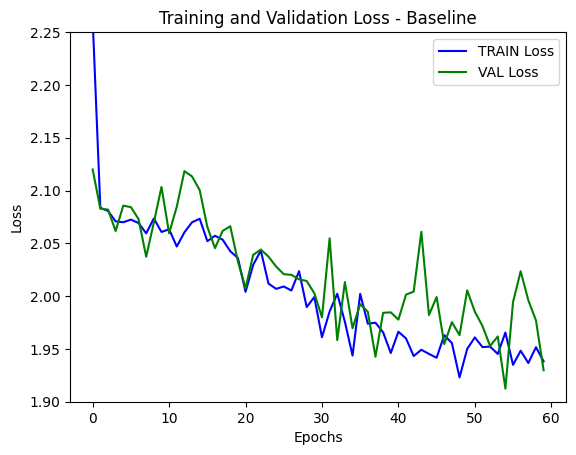

In [ ]:
checkpoint = torch.load('/content/model_baseline.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'Baseline', top_y=2.25, bottom_y=1.9)

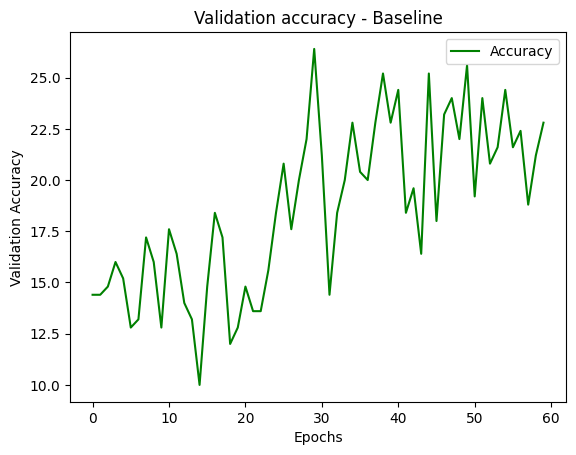

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'Baseline')

##### AlexNet Model

In [ ]:
#########################
####  AlexNet Model  ####
#########################

class AlexNetwork(nn.Module):
  def __init__(self, aux_logits = False):
      super(AlexNetwork, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(256, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output

  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

alexnet_model = AlexNetwork().to(device)

###### AlexNet Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(alexnet_model.parameters(), lr=Config.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(alexnet_model, optimizer, criterion, scheduler, 'alexnet')

20it [00:08,  2.27it/s]
4it [00:01,  2.02it/s]


Val Progress --- total:250, correct:44
Val accuracy: 17.600%
Epoch [1/60], TRNLoss:2.2492, VALLoss:2.0859, Time:0.18


20it [00:08,  2.44it/s]
4it [00:01,  2.66it/s]


Val Progress --- total:250, correct:41
Val accuracy: 16.400%
Epoch [2/60], TRNLoss:2.0878, VALLoss:2.0704, Time:0.16


20it [00:08,  2.27it/s]
4it [00:01,  2.74it/s]


Val Progress --- total:250, correct:45
Val accuracy: 18.000%
Epoch [3/60], TRNLoss:2.0787, VALLoss:2.0580, Time:0.17


20it [00:09,  2.18it/s]
4it [00:01,  2.69it/s]


Val Progress --- total:250, correct:32
Val accuracy: 12.800%
Epoch [4/60], TRNLoss:2.0701, VALLoss:2.0924, Time:0.18


20it [00:09,  2.16it/s]
4it [00:01,  2.81it/s]


Val Progress --- total:250, correct:32
Val accuracy: 12.800%
Epoch [5/60], TRNLoss:2.0737, VALLoss:2.0743, Time:0.18


20it [00:09,  2.18it/s]
4it [00:01,  2.65it/s]


Val Progress --- total:250, correct:33
Val accuracy: 13.200%
Epoch [6/60], TRNLoss:2.0724, VALLoss:2.1015, Time:0.18


20it [00:08,  2.42it/s]
4it [00:02,  1.85it/s]


Val Progress --- total:250, correct:32
Val accuracy: 12.800%
Epoch [7/60], TRNLoss:2.0713, VALLoss:2.0702, Time:0.17


20it [00:08,  2.36it/s]
4it [00:01,  2.76it/s]


Val Progress --- total:250, correct:49
Val accuracy: 19.600%
Epoch [8/60], TRNLoss:2.0737, VALLoss:2.0616, Time:0.17


20it [00:09,  2.17it/s]
4it [00:01,  2.77it/s]


Val Progress --- total:250, correct:42
Val accuracy: 16.800%
Epoch 00009: reducing learning rate of group 0 to 1.5000e-04.
Epoch [9/60], TRNLoss:2.0656, VALLoss:2.0813, Time:0.18


20it [00:09,  2.16it/s]
4it [00:01,  2.71it/s]


Val Progress --- total:250, correct:37
Val accuracy: 14.800%
Epoch [10/60], TRNLoss:2.0675, VALLoss:2.0570, Time:0.18


20it [00:09,  2.14it/s]
4it [00:01,  2.75it/s]


Val Progress --- total:250, correct:33
Val accuracy: 13.200%
Epoch [11/60], TRNLoss:2.0629, VALLoss:2.4242, Time:0.18


20it [00:08,  2.24it/s]
4it [00:01,  2.15it/s]


Val Progress --- total:250, correct:40
Val accuracy: 16.000%
Epoch [12/60], TRNLoss:2.0564, VALLoss:2.0645, Time:0.18


20it [00:08,  2.39it/s]
4it [00:01,  2.06it/s]


Val Progress --- total:250, correct:35
Val accuracy: 14.000%
Epoch [13/60], TRNLoss:2.0614, VALLoss:2.0488, Time:0.17


20it [00:08,  2.31it/s]
4it [00:01,  2.84it/s]


Val Progress --- total:250, correct:44
Val accuracy: 17.600%
Epoch [14/60], TRNLoss:2.0315, VALLoss:2.0296, Time:0.17


20it [00:09,  2.22it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:48
Val accuracy: 19.200%
Epoch [15/60], TRNLoss:2.0421, VALLoss:2.0147, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.77it/s]


Val Progress --- total:250, correct:41
Val accuracy: 16.400%
Epoch [16/60], TRNLoss:2.0439, VALLoss:2.0511, Time:0.17


20it [00:08,  2.28it/s]
4it [00:01,  2.86it/s]


Val Progress --- total:250, correct:31
Val accuracy: 12.400%
Epoch [17/60], TRNLoss:2.0194, VALLoss:2.0554, Time:0.17


20it [00:08,  2.50it/s]
4it [00:01,  2.10it/s]


Val Progress --- total:250, correct:42
Val accuracy: 16.800%
Epoch [18/60], TRNLoss:2.0358, VALLoss:6.7144, Time:0.17


20it [00:08,  2.42it/s]
4it [00:01,  2.86it/s]


Val Progress --- total:250, correct:51
Val accuracy: 20.400%
Epoch [19/60], TRNLoss:2.0269, VALLoss:2.1170, Time:0.16


20it [00:08,  2.30it/s]
4it [00:01,  2.92it/s]


Val Progress --- total:250, correct:39
Val accuracy: 15.600%
Epoch [20/60], TRNLoss:2.0374, VALLoss:2.0321, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.81it/s]


Val Progress --- total:250, correct:54
Val accuracy: 21.600%
Epoch [21/60], TRNLoss:2.0332, VALLoss:2.0046, Time:0.17


20it [00:08,  2.27it/s]
4it [00:01,  2.52it/s]


Val Progress --- total:250, correct:32
Val accuracy: 12.800%
Epoch [22/60], TRNLoss:2.0200, VALLoss:2.0367, Time:0.17


20it [00:08,  2.48it/s]
4it [00:01,  2.26it/s]


Val Progress --- total:250, correct:37
Val accuracy: 14.800%
Epoch [23/60], TRNLoss:2.0373, VALLoss:2.0560, Time:0.16


20it [00:08,  2.34it/s]
4it [00:01,  2.81it/s]


Val Progress --- total:250, correct:44
Val accuracy: 17.600%
Epoch [24/60], TRNLoss:2.0186, VALLoss:2.0465, Time:0.17


20it [00:09,  2.08it/s]
4it [00:01,  2.93it/s]


Val Progress --- total:250, correct:44
Val accuracy: 17.600%
Epoch [25/60], TRNLoss:2.0126, VALLoss:2.0094, Time:0.18


20it [00:09,  2.01it/s]
4it [00:01,  2.89it/s]


Val Progress --- total:250, correct:43
Val accuracy: 17.200%
Epoch [26/60], TRNLoss:2.0129, VALLoss:2.0324, Time:0.19


20it [00:08,  2.24it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:44
Val accuracy: 17.600%
Epoch [27/60], TRNLoss:2.0092, VALLoss:1.9974, Time:0.17


20it [00:08,  2.28it/s]
4it [00:01,  2.01it/s]


Val Progress --- total:250, correct:35
Val accuracy: 14.000%
Epoch [28/60], TRNLoss:2.0028, VALLoss:2.0106, Time:0.18


20it [00:10,  1.91it/s]
4it [00:03,  1.09it/s]


Val Progress --- total:250, correct:50
Val accuracy: 20.000%
Epoch [29/60], TRNLoss:2.0232, VALLoss:2.0115, Time:0.24


20it [00:09,  2.19it/s]
4it [00:02,  1.90it/s]


Val Progress --- total:250, correct:52
Val accuracy: 20.800%
Epoch [30/60], TRNLoss:1.9953, VALLoss:2.0544, Time:0.19


20it [00:08,  2.41it/s]
4it [00:01,  2.71it/s]


Val Progress --- total:250, correct:52
Val accuracy: 20.800%
Epoch [31/60], TRNLoss:2.0246, VALLoss:2.0092, Time:0.16


20it [00:09,  2.20it/s]
4it [00:01,  2.79it/s]


Val Progress --- total:250, correct:52
Val accuracy: 20.800%
Epoch [32/60], TRNLoss:1.9970, VALLoss:1.9907, Time:0.18


20it [00:08,  2.24it/s]
4it [00:01,  2.88it/s]


Val Progress --- total:250, correct:52
Val accuracy: 20.800%
Epoch [33/60], TRNLoss:2.0054, VALLoss:1.9831, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.92it/s]


Val Progress --- total:250, correct:53
Val accuracy: 21.200%
Epoch [34/60], TRNLoss:1.9881, VALLoss:2.0142, Time:0.17


20it [00:08,  2.40it/s]
4it [00:01,  2.12it/s]


Val Progress --- total:250, correct:35
Val accuracy: 14.000%
Epoch [35/60], TRNLoss:1.9805, VALLoss:2.0418, Time:0.17


20it [00:08,  2.48it/s]
4it [00:01,  2.89it/s]


Val Progress --- total:250, correct:60
Val accuracy: 24.000%
Epoch [36/60], TRNLoss:1.9823, VALLoss:1.9829, Time:0.16


20it [00:08,  2.27it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:51
Val accuracy: 20.400%
Epoch [37/60], TRNLoss:1.9799, VALLoss:1.9725, Time:0.17


20it [00:08,  2.24it/s]
4it [00:01,  2.85it/s]


Val Progress --- total:250, correct:35
Val accuracy: 14.000%
Epoch [38/60], TRNLoss:1.9725, VALLoss:2.0303, Time:0.17


20it [00:09,  2.22it/s]
4it [00:01,  2.90it/s]


Val Progress --- total:250, correct:61
Val accuracy: 24.400%
Epoch [39/60], TRNLoss:1.9843, VALLoss:2.0036, Time:0.17


20it [00:09,  2.19it/s]
4it [00:01,  2.56it/s]


Val Progress --- total:250, correct:50
Val accuracy: 20.000%
Epoch [40/60], TRNLoss:1.9668, VALLoss:1.9572, Time:0.18


20it [00:07,  2.52it/s]
4it [00:01,  2.51it/s]


Val Progress --- total:250, correct:45
Val accuracy: 18.000%
Epoch [41/60], TRNLoss:1.9766, VALLoss:1.9660, Time:0.16


20it [00:08,  2.31it/s]
4it [00:01,  2.89it/s]


Val Progress --- total:250, correct:46
Val accuracy: 18.400%
Epoch [42/60], TRNLoss:1.9564, VALLoss:2.0333, Time:0.17


20it [00:08,  2.25it/s]
4it [00:01,  2.81it/s]


Val Progress --- total:250, correct:46
Val accuracy: 18.400%
Epoch [43/60], TRNLoss:1.9639, VALLoss:2.0131, Time:0.17


20it [00:08,  2.27it/s]
4it [00:01,  2.95it/s]


Val Progress --- total:250, correct:59
Val accuracy: 23.600%
Epoch [44/60], TRNLoss:1.9563, VALLoss:1.9576, Time:0.17


20it [00:08,  2.31it/s]
4it [00:01,  2.36it/s]


Val Progress --- total:250, correct:42
Val accuracy: 16.800%
Epoch [45/60], TRNLoss:1.9825, VALLoss:2.0044, Time:0.17


20it [00:08,  2.49it/s]
4it [00:01,  2.57it/s]


Val Progress --- total:250, correct:64
Val accuracy: 25.600%
Epoch [46/60], TRNLoss:1.9751, VALLoss:1.9470, Time:0.16


20it [00:08,  2.30it/s]
4it [00:01,  2.93it/s]


Val Progress --- total:250, correct:36
Val accuracy: 14.400%
Epoch [47/60], TRNLoss:1.9755, VALLoss:2.0120, Time:0.17


20it [00:08,  2.25it/s]
4it [00:01,  2.86it/s]


Val Progress --- total:250, correct:59
Val accuracy: 23.600%
Epoch [48/60], TRNLoss:1.9434, VALLoss:1.9274, Time:0.17


20it [00:08,  2.27it/s]
4it [00:01,  2.83it/s]


Val Progress --- total:250, correct:55
Val accuracy: 22.000%
Epoch [49/60], TRNLoss:1.9466, VALLoss:1.9844, Time:0.17


20it [00:09,  2.17it/s]
4it [00:01,  2.65it/s]


Val Progress --- total:250, correct:53
Val accuracy: 21.200%
Epoch [50/60], TRNLoss:1.9537, VALLoss:2.0241, Time:0.18


20it [00:08,  2.48it/s]
4it [00:01,  2.21it/s]


Val Progress --- total:250, correct:59
Val accuracy: 23.600%
Epoch [51/60], TRNLoss:1.9637, VALLoss:1.9621, Time:0.16


20it [00:08,  2.30it/s]
4it [00:01,  2.67it/s]


Val Progress --- total:250, correct:51
Val accuracy: 20.400%
Epoch [52/60], TRNLoss:1.9589, VALLoss:1.9704, Time:0.17


20it [00:08,  2.25it/s]
4it [00:01,  2.91it/s]


Val Progress --- total:250, correct:49
Val accuracy: 19.600%
Epoch [53/60], TRNLoss:1.9360, VALLoss:1.9681, Time:0.17


20it [00:09,  2.16it/s]
4it [00:01,  2.89it/s]


Val Progress --- total:250, correct:60
Val accuracy: 24.000%
Epoch [54/60], TRNLoss:1.9495, VALLoss:1.9040, Time:0.18


20it [00:08,  2.26it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:44
Val accuracy: 17.600%
Epoch [55/60], TRNLoss:1.9427, VALLoss:1.9722, Time:0.17


20it [00:08,  2.48it/s]
4it [00:02,  1.84it/s]


Val Progress --- total:250, correct:54
Val accuracy: 21.600%
Epoch [56/60], TRNLoss:1.9560, VALLoss:1.9427, Time:0.17


20it [00:08,  2.45it/s]
4it [00:01,  2.84it/s]


Val Progress --- total:250, correct:55
Val accuracy: 22.000%
Epoch [57/60], TRNLoss:1.9610, VALLoss:1.9779, Time:0.16


20it [00:08,  2.25it/s]
4it [00:01,  2.80it/s]


Val Progress --- total:250, correct:43
Val accuracy: 17.200%
Epoch [58/60], TRNLoss:1.9447, VALLoss:2.0278, Time:0.17


20it [00:08,  2.28it/s]
4it [00:01,  2.75it/s]


Val Progress --- total:250, correct:49
Val accuracy: 19.600%
Epoch [59/60], TRNLoss:1.9366, VALLoss:1.9742, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.78it/s]


Val Progress --- total:250, correct:58
Val accuracy: 23.200%
Epoch 00060: reducing learning rate of group 0 to 4.5000e-05.
Epoch [60/60], TRNLoss:1.9462, VALLoss:1.9628, Time:0.17


###### AlexNet training and validation plots

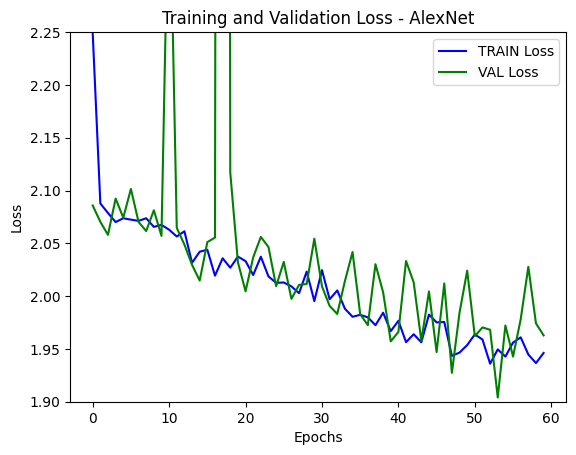

In [ ]:
checkpoint = torch.load('/content/model_alexnet.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'AlexNet', top_y=2.25, bottom_y=1.9)

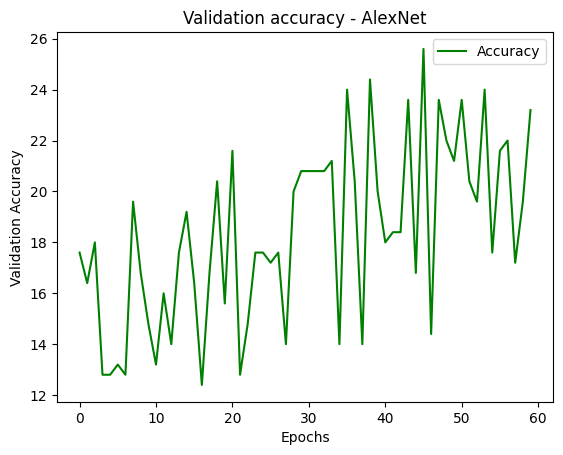

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'AlexNet')

##### VGG Model

In [ ]:
#########################
####    VGG Model    ####
#########################

class VggNet(nn.Module):
  def __init__(self, aux_logits = False):
      super(VggNet, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(4608, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output

  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

vgg_model = VggNet().to(device)

###### VGG Model Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(vgg_model.parameters(), lr=Config.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(vgg_model, optimizer, criterion, scheduler, 'VGGNet')

20it [00:13,  1.47it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:18
Val accuracy: 7.200%
Epoch [1/60], TRNLoss:2.1337, VALLoss:2.0843, Time:0.26


20it [00:13,  1.51it/s]
4it [00:01,  2.40it/s]


Val Progress --- total:250, correct:32
Val accuracy: 12.800%
Epoch [2/60], TRNLoss:2.1176, VALLoss:2.5127, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.46it/s]


Val Progress --- total:250, correct:24
Val accuracy: 9.600%
Epoch [3/60], TRNLoss:2.0828, VALLoss:4.3356, Time:0.25


20it [00:13,  1.54it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:25
Val accuracy: 10.000%
Epoch [4/60], TRNLoss:2.0798, VALLoss:2.1810, Time:0.25


20it [00:13,  1.52it/s]
4it [00:02,  1.85it/s]


Val Progress --- total:250, correct:27
Val accuracy: 10.800%
Epoch [5/60], TRNLoss:2.0841, VALLoss:2.5544, Time:0.26


20it [00:13,  1.51it/s]
4it [00:01,  2.22it/s]


Val Progress --- total:250, correct:25
Val accuracy: 10.000%
Epoch [6/60], TRNLoss:2.0839, VALLoss:12.7134, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.49it/s]


Val Progress --- total:250, correct:28
Val accuracy: 11.200%
Epoch 00007: reducing learning rate of group 0 to 1.5000e-04.
Epoch [7/60], TRNLoss:2.0796, VALLoss:2.3002, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.45it/s]


Val Progress --- total:250, correct:38
Val accuracy: 15.200%
Epoch [8/60], TRNLoss:2.0799, VALLoss:2.0825, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.45it/s]


Val Progress --- total:250, correct:27
Val accuracy: 10.800%
Epoch [9/60], TRNLoss:2.0792, VALLoss:2.0789, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.35it/s]


Val Progress --- total:250, correct:30
Val accuracy: 12.000%
Epoch [10/60], TRNLoss:2.0784, VALLoss:2.0818, Time:0.25


20it [00:13,  1.46it/s]
4it [00:02,  1.99it/s]


Val Progress --- total:250, correct:36
Val accuracy: 14.400%
Epoch [11/60], TRNLoss:2.0793, VALLoss:2.0797, Time:0.26


20it [00:13,  1.51it/s]
4it [00:01,  2.38it/s]


Val Progress --- total:250, correct:30
Val accuracy: 12.000%
Epoch [12/60], TRNLoss:2.0965, VALLoss:2.0932, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.41it/s]


Val Progress --- total:250, correct:29
Val accuracy: 11.600%
Epoch [13/60], TRNLoss:2.0788, VALLoss:4.9212, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.40it/s]


Val Progress --- total:250, correct:37
Val accuracy: 14.800%
Epoch [14/60], TRNLoss:2.0748, VALLoss:2.0881, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.46it/s]


Val Progress --- total:250, correct:35
Val accuracy: 14.000%
Epoch 00015: reducing learning rate of group 0 to 4.5000e-05.
Epoch [15/60], TRNLoss:2.0732, VALLoss:2.6281, Time:0.25


20it [00:13,  1.53it/s]
4it [00:02,  1.70it/s]


Val Progress --- total:250, correct:43
Val accuracy: 17.200%
Epoch [16/60], TRNLoss:2.0738, VALLoss:2.0719, Time:0.26


20it [00:13,  1.52it/s]
4it [00:01,  2.40it/s]


Val Progress --- total:250, correct:43
Val accuracy: 17.200%
Epoch [17/60], TRNLoss:2.0689, VALLoss:2.0597, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.47it/s]


Val Progress --- total:250, correct:35
Val accuracy: 14.000%
Epoch [18/60], TRNLoss:2.0648, VALLoss:2.0832, Time:0.25


20it [00:12,  1.54it/s]
4it [00:01,  2.45it/s]


Val Progress --- total:250, correct:39
Val accuracy: 15.600%
Epoch [19/60], TRNLoss:2.0675, VALLoss:2.0885, Time:0.24


20it [00:13,  1.53it/s]
4it [00:01,  2.45it/s]


Val Progress --- total:250, correct:38
Val accuracy: 15.200%
Epoch [20/60], TRNLoss:2.0675, VALLoss:2.0650, Time:0.24


20it [00:13,  1.53it/s]
4it [00:01,  2.02it/s]


Val Progress --- total:250, correct:43
Val accuracy: 17.200%
Epoch [21/60], TRNLoss:2.0632, VALLoss:2.0606, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.01it/s]


Val Progress --- total:250, correct:39
Val accuracy: 15.600%
Epoch [22/60], TRNLoss:2.0616, VALLoss:2.0686, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.44it/s]


Val Progress --- total:250, correct:30
Val accuracy: 12.000%
Epoch 00023: reducing learning rate of group 0 to 1.3500e-05.
Epoch [23/60], TRNLoss:2.0631, VALLoss:2.4927, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.41it/s]


Val Progress --- total:250, correct:35
Val accuracy: 14.000%
Epoch [24/60], TRNLoss:2.0702, VALLoss:2.0555, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.35it/s]


Val Progress --- total:250, correct:36
Val accuracy: 14.400%
Epoch [25/60], TRNLoss:2.0690, VALLoss:2.0685, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.41it/s]


Val Progress --- total:250, correct:41
Val accuracy: 16.400%
Epoch [26/60], TRNLoss:2.0652, VALLoss:2.0551, Time:0.25


20it [00:13,  1.53it/s]
4it [00:02,  1.71it/s]


Val Progress --- total:250, correct:36
Val accuracy: 14.400%
Epoch [27/60], TRNLoss:2.0686, VALLoss:2.0478, Time:0.26


20it [00:13,  1.54it/s]
4it [00:01,  2.44it/s]


Val Progress --- total:250, correct:47
Val accuracy: 18.800%
Epoch [28/60], TRNLoss:2.0685, VALLoss:2.0540, Time:0.24


20it [00:13,  1.53it/s]
4it [00:01,  2.40it/s]


Val Progress --- total:250, correct:33
Val accuracy: 13.200%
Epoch [29/60], TRNLoss:2.0656, VALLoss:2.0597, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.41it/s]


Val Progress --- total:250, correct:44
Val accuracy: 17.600%
Epoch [30/60], TRNLoss:2.0673, VALLoss:2.0574, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:36
Val accuracy: 14.400%
Epoch [31/60], TRNLoss:2.0646, VALLoss:2.0676, Time:0.25


20it [00:13,  1.52it/s]
4it [00:02,  1.97it/s]


Val Progress --- total:250, correct:46
Val accuracy: 18.400%
Epoch [32/60], TRNLoss:2.0658, VALLoss:2.0597, Time:0.25


20it [00:13,  1.51it/s]
4it [00:01,  2.09it/s]


Val Progress --- total:250, correct:37
Val accuracy: 14.800%
Epoch 00033: reducing learning rate of group 0 to 4.0500e-06.
Epoch [33/60], TRNLoss:2.0604, VALLoss:2.0610, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.43it/s]


Val Progress --- total:250, correct:44
Val accuracy: 17.600%
Epoch [34/60], TRNLoss:2.0620, VALLoss:2.0524, Time:0.25


20it [00:12,  1.54it/s]
4it [00:01,  2.48it/s]


Val Progress --- total:250, correct:41
Val accuracy: 16.400%
Epoch [35/60], TRNLoss:2.0605, VALLoss:2.0462, Time:0.24


20it [00:12,  1.54it/s]
4it [00:01,  2.48it/s]


Val Progress --- total:250, correct:39
Val accuracy: 15.600%
Epoch [36/60], TRNLoss:2.0680, VALLoss:2.0616, Time:0.24


20it [00:13,  1.53it/s]
4it [00:01,  2.46it/s]


Val Progress --- total:250, correct:30
Val accuracy: 12.000%
Epoch [37/60], TRNLoss:2.0491, VALLoss:2.0648, Time:0.24


20it [00:13,  1.53it/s]
4it [00:02,  1.74it/s]


Val Progress --- total:250, correct:43
Val accuracy: 17.200%
Epoch [38/60], TRNLoss:2.0600, VALLoss:2.0670, Time:0.26


20it [00:13,  1.52it/s]
4it [00:01,  2.45it/s]


Val Progress --- total:250, correct:43
Val accuracy: 17.200%
Epoch [39/60], TRNLoss:2.0591, VALLoss:2.0657, Time:0.25


20it [00:12,  1.54it/s]
4it [00:01,  2.46it/s]


Val Progress --- total:250, correct:41
Val accuracy: 16.400%
Epoch [40/60], TRNLoss:2.0526, VALLoss:2.0606, Time:0.24


20it [00:13,  1.52it/s]
4it [00:01,  2.40it/s]


Val Progress --- total:250, correct:42
Val accuracy: 16.800%
Epoch 00041: reducing learning rate of group 0 to 1.2150e-06.
Epoch [41/60], TRNLoss:2.0603, VALLoss:2.0530, Time:0.25


20it [00:12,  1.54it/s]
4it [00:01,  2.44it/s]


Val Progress --- total:250, correct:30
Val accuracy: 12.000%
Epoch [42/60], TRNLoss:2.0624, VALLoss:2.0536, Time:0.24


20it [00:13,  1.53it/s]
4it [00:01,  2.20it/s]


Val Progress --- total:250, correct:28
Val accuracy: 11.200%
Epoch [43/60], TRNLoss:2.0607, VALLoss:2.0571, Time:0.25


20it [00:13,  1.50it/s]
4it [00:02,  1.95it/s]


Val Progress --- total:250, correct:41
Val accuracy: 16.400%
Epoch [44/60], TRNLoss:2.0639, VALLoss:2.0564, Time:0.26


20it [00:12,  1.54it/s]
4it [00:01,  2.47it/s]


Val Progress --- total:250, correct:49
Val accuracy: 19.600%
Epoch [45/60], TRNLoss:2.0602, VALLoss:2.0317, Time:0.24


20it [00:13,  1.53it/s]
4it [00:01,  2.46it/s]


Val Progress --- total:250, correct:32
Val accuracy: 12.800%
Epoch [46/60], TRNLoss:2.0630, VALLoss:2.0665, Time:0.24


20it [00:13,  1.53it/s]
4it [00:01,  2.48it/s]


Val Progress --- total:250, correct:38
Val accuracy: 15.200%
Epoch [47/60], TRNLoss:2.0507, VALLoss:2.0517, Time:0.25


20it [00:12,  1.55it/s]
4it [00:01,  2.51it/s]


Val Progress --- total:250, correct:36
Val accuracy: 14.400%
Epoch [48/60], TRNLoss:2.0586, VALLoss:2.0608, Time:0.24


20it [00:13,  1.54it/s]
4it [00:02,  1.89it/s]


Val Progress --- total:250, correct:36
Val accuracy: 14.400%
Epoch [49/60], TRNLoss:2.0674, VALLoss:2.0465, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.31it/s]


Val Progress --- total:250, correct:32
Val accuracy: 12.800%
Epoch [50/60], TRNLoss:2.0568, VALLoss:2.0665, Time:0.25


20it [00:13,  1.54it/s]
4it [00:01,  2.48it/s]


Val Progress --- total:250, correct:35
Val accuracy: 14.000%
Epoch 00051: reducing learning rate of group 0 to 3.6450e-07.
Epoch [51/60], TRNLoss:2.0579, VALLoss:2.0535, Time:0.24


20it [00:13,  1.53it/s]
4it [00:01,  2.46it/s]


Val Progress --- total:250, correct:38
Val accuracy: 15.200%
Epoch [52/60], TRNLoss:2.0628, VALLoss:2.0602, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.45it/s]


Val Progress --- total:250, correct:29
Val accuracy: 11.600%
Epoch [53/60], TRNLoss:2.0641, VALLoss:2.0575, Time:0.24


20it [00:13,  1.53it/s]
4it [00:01,  2.47it/s]


Val Progress --- total:250, correct:31
Val accuracy: 12.400%
Epoch [54/60], TRNLoss:2.0590, VALLoss:2.0643, Time:0.24


20it [00:13,  1.54it/s]
4it [00:02,  1.72it/s]


Val Progress --- total:250, correct:35
Val accuracy: 14.000%
Epoch [55/60], TRNLoss:2.0586, VALLoss:2.0749, Time:0.26


20it [00:12,  1.54it/s]
4it [00:01,  2.46it/s]


Val Progress --- total:250, correct:38
Val accuracy: 15.200%
Epoch [56/60], TRNLoss:2.0575, VALLoss:2.0662, Time:0.24


20it [00:13,  1.53it/s]
4it [00:01,  2.45it/s]


Val Progress --- total:250, correct:39
Val accuracy: 15.600%
Epoch 00057: reducing learning rate of group 0 to 1.0935e-07.
Epoch [57/60], TRNLoss:2.0606, VALLoss:2.0615, Time:0.24


20it [00:12,  1.54it/s]
4it [00:01,  2.44it/s]


Val Progress --- total:250, correct:39
Val accuracy: 15.600%
Epoch [58/60], TRNLoss:2.0546, VALLoss:2.0594, Time:0.24


20it [00:12,  1.54it/s]
4it [00:01,  2.45it/s]


Val Progress --- total:250, correct:36
Val accuracy: 14.400%
Epoch [59/60], TRNLoss:2.0543, VALLoss:2.0597, Time:0.24


20it [00:12,  1.55it/s]
4it [00:01,  2.24it/s]


Val Progress --- total:250, correct:39
Val accuracy: 15.600%
Epoch [60/60], TRNLoss:2.0658, VALLoss:2.0667, Time:0.25


###### VGG Model training and validation plots

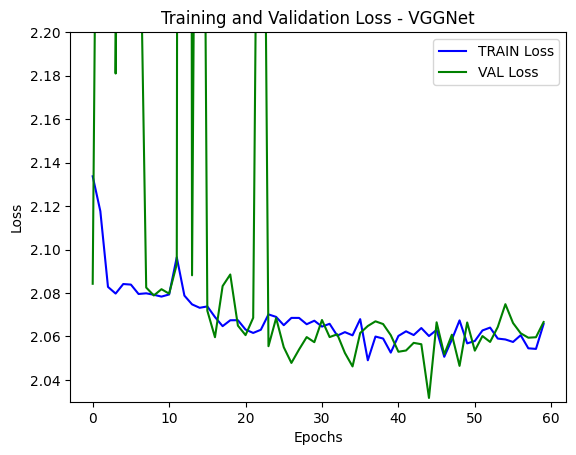

In [ ]:
checkpoint = torch.load('/content/model_VGGNet.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'VGGNet', top_y=2.2, bottom_y=2.03)

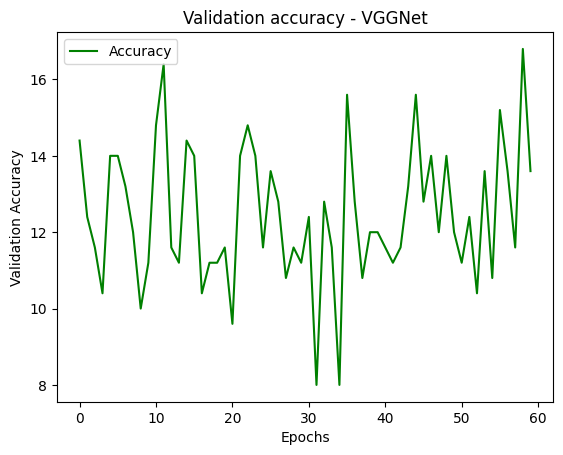

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'VGGNet')

#### Patches 5x5

Now, instead of using a 3x3 grid, let's try using a 5x5 grid

##### Config

In [ ]:
class Config_5x5():
  patch_dim = 12
  gap = 1
  batch_size = 64
  num_epochs = 60
  lr = 0.0005

##### MyDataset Class

In [ ]:
###################################################
#### This class generates patches for training ####
###################################################

class MyDataset(Dataset):
  def __init__(self, patch_dim, gap, df, validate, transform=None):
    self.patch_dim, self.gap = patch_dim, gap
    self.transform = transform
    self.train_data = df.values
  
  def get_patch_from_grid(self, image, patch_dim, gap):
    image = np.array(image)

    offset_x, offset_y = image.shape[0] - (patch_dim*5 + gap), image.shape[1] - (patch_dim*5 + gap)
    start_grid_x, start_grid_y = np.random.randint(0, offset_x), np.random.randint(0, offset_y)
    patch_loc_arr = [(1, 1), (1, 2), (1, 3), (1,4), (1,5), (2, 1), (2,2), (2, 3), (2,4), (2,5), (3, 1), (3, 2), (3, 4), (3,5), (4, 1), (4, 2), (4, 3), (4,4), (4,5), (5, 1), (5, 2), (5, 3), (5,4), (5,5)]
    loc = np.random.randint(len(patch_loc_arr))
    tempx, tempy = patch_loc_arr[loc]

    patch_x_pt = start_grid_x + patch_dim * (tempx-1) + gap * (tempx-1)
    patch_y_pt = start_grid_y + patch_dim * (tempy-1) + gap * (tempy-1)
    random_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]

    patch_x_pt = start_grid_x + patch_dim * (3-1) + gap * (3-1)
    patch_y_pt = start_grid_y + patch_dim * (3-1) + gap * (3-1)
    uniform_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]
    
    random_patch_label = loc
    
    return uniform_patch, random_patch, random_patch_label

  def __len__(self):
    return len(self.train_data)
  
  def __getitem__(self, index):
    image = Image.open(self.train_data[index]).convert('RGB')
    uniform_patch, random_patch, random_patch_label = self.get_patch_from_grid(image, 
                                                                               self.patch_dim, 
                                                                               self.gap)
    if uniform_patch.shape[0] != 96:
        uniform_patch = skimage.transform.resize(uniform_patch, (96, 96))
        random_patch = skimage.transform.resize(random_patch, (96, 96))
        
        uniform_patch = img_as_float32(uniform_patch)
        random_patch = img_as_float32(random_patch)

    random_patch_label = np.array(random_patch_label).astype(np.int64)
        
    if self.transform:
      uniform_patch = self.transform(uniform_patch)
      random_patch = self.transform(random_patch)

    return uniform_patch, random_patch, random_patch_label

##### Datasets Loaders

In [ ]:
##########################################################
#### Creating Train/Validation dataset and dataloader ####
##########################################################

traindataset = MyDataset(Config_5x5.patch_dim, Config_5x5.gap, df_context_prediction_train['filename'], False,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                  std=[0.229, 0.224, 0.225])]))
trainloader = torch.utils.data.DataLoader(traindataset, 
                                          batch_size=Config_5x5.batch_size,
                                          shuffle=True)


valdataset = MyDataset(Config_5x5.patch_dim, Config_5x5.gap, df_context_prediction_val['filename'], True,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                  std=[0.229, 0.224, 0.225])]))
valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=Config_5x5.batch_size,
                                        shuffle=False)

##### Datasets Visualization

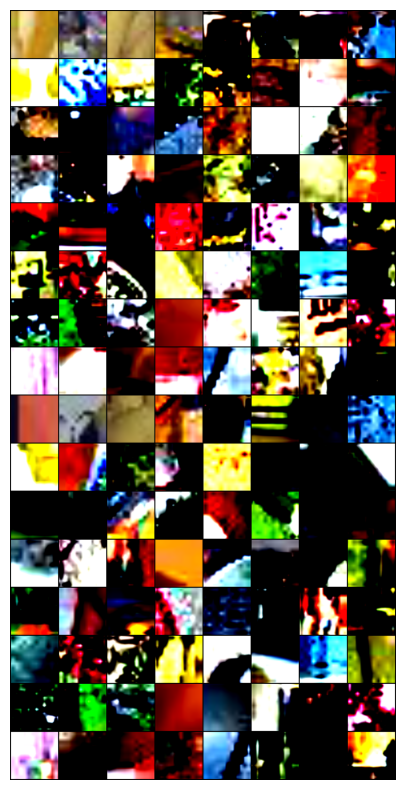

Labels: [19  0  0 18 15  9 18 16 11  6 20  8 21  1 18  1 16  6 17 21  4  5  0  7
 15 19 12  0  0 23  1 21 17  5  5 17 19  0 17  5 20 15 21  0  6  9 11 13
 10 15 10 16  1  2 23 20 16 17 17  1  7 13 23  7]


In [ ]:
######################################
#### Visualizing training dataset ####
######################################

example_batch = next(iter(trainloader))
concatenated = torch.cat((unorm(example_batch[0]),unorm(example_batch[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch[2].numpy()}')

##### Baseline Model

In [ ]:
##########################
####     Baseline     ####
##########################

class BaselineModel_5x5(nn.Module):
  def __init__(self, aux_logits = False):
      super(BaselineModel_5x5, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(256, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )

      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 24)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output

  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

baseline_model_5x5 = BaselineModel_5x5().to(device)

###### Baseline Model Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(baseline_model_5x5.parameters(), lr=Config_5x5.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(baseline_model_5x5, optimizer, criterion, scheduler, 'baseline_5x5')

20it [00:08,  2.34it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:8
Val accuracy: 3.200%
Epoch [1/60], TRNLoss:3.3679, VALLoss:3.2893, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.83it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [2/60], TRNLoss:3.2020, VALLoss:3.1689, Time:0.17


20it [00:08,  2.24it/s]
4it [00:01,  2.69it/s]


Val Progress --- total:250, correct:7
Val accuracy: 2.800%
Epoch [3/60], TRNLoss:3.1751, VALLoss:3.2011, Time:0.17


20it [00:08,  2.33it/s]
4it [00:01,  2.60it/s]


Val Progress --- total:250, correct:5
Val accuracy: 2.000%
Epoch [4/60], TRNLoss:3.1742, VALLoss:3.2701, Time:0.17


20it [00:08,  2.44it/s]
4it [00:02,  1.51it/s]


Val Progress --- total:250, correct:10
Val accuracy: 4.000%
Epoch [5/60], TRNLoss:3.1677, VALLoss:3.1755, Time:0.18


20it [00:08,  2.40it/s]
4it [00:01,  2.91it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [6/60], TRNLoss:3.1564, VALLoss:3.1903, Time:0.16


20it [00:08,  2.31it/s]
4it [00:01,  2.83it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [7/60], TRNLoss:3.1548, VALLoss:3.1657, Time:0.17


20it [00:08,  2.25it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:10
Val accuracy: 4.000%
Epoch [8/60], TRNLoss:3.1535, VALLoss:3.1686, Time:0.17


20it [00:08,  2.27it/s]
4it [00:01,  2.93it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [9/60], TRNLoss:3.1502, VALLoss:6.2619, Time:0.17


20it [00:08,  2.49it/s]
4it [00:01,  2.07it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [10/60], TRNLoss:3.1672, VALLoss:3.1672, Time:0.17


20it [00:08,  2.42it/s]
4it [00:01,  2.70it/s]


Val Progress --- total:250, correct:19
Val accuracy: 7.600%
Epoch [11/60], TRNLoss:3.1487, VALLoss:3.1693, Time:0.16


20it [00:08,  2.28it/s]
4it [00:01,  2.82it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [12/60], TRNLoss:3.1557, VALLoss:3.1411, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.81it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [13/60], TRNLoss:3.1475, VALLoss:3.1304, Time:0.17


20it [00:09,  2.18it/s]
4it [00:01,  2.93it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch [14/60], TRNLoss:3.1409, VALLoss:3.1748, Time:0.18


20it [00:07,  2.54it/s]
4it [00:01,  2.04it/s]


Val Progress --- total:250, correct:16
Val accuracy: 6.400%
Epoch [15/60], TRNLoss:3.1625, VALLoss:3.1578, Time:0.16


20it [00:08,  2.43it/s]
4it [00:01,  2.99it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch [16/60], TRNLoss:3.1416, VALLoss:3.1585, Time:0.16


20it [00:08,  2.25it/s]
4it [00:01,  2.96it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [17/60], TRNLoss:3.1502, VALLoss:3.1417, Time:0.17


20it [00:08,  2.29it/s]
4it [00:01,  2.91it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [18/60], TRNLoss:3.1518, VALLoss:3.1794, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.78it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch 00019: reducing learning rate of group 0 to 1.5000e-04.
Epoch [19/60], TRNLoss:3.1409, VALLoss:3.2013, Time:0.17


20it [00:07,  2.53it/s]
4it [00:01,  2.11it/s]


Val Progress --- total:250, correct:9
Val accuracy: 3.600%
Epoch [20/60], TRNLoss:3.1349, VALLoss:3.1523, Time:0.16


20it [00:08,  2.41it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [21/60], TRNLoss:3.1397, VALLoss:3.1760, Time:0.16


20it [00:08,  2.32it/s]
4it [00:01,  2.97it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [22/60], TRNLoss:3.1270, VALLoss:3.1213, Time:0.17


20it [00:08,  2.25it/s]
4it [00:01,  2.82it/s]


Val Progress --- total:250, correct:8
Val accuracy: 3.200%
Epoch [23/60], TRNLoss:3.1285, VALLoss:3.1214, Time:0.17


20it [00:08,  2.36it/s]
4it [00:01,  2.39it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [24/60], TRNLoss:3.1353, VALLoss:3.1518, Time:0.17


20it [00:07,  2.53it/s]
4it [00:01,  2.55it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [25/60], TRNLoss:3.1303, VALLoss:3.1359, Time:0.16


20it [00:08,  2.31it/s]
4it [00:01,  2.89it/s]


Val Progress --- total:250, correct:16
Val accuracy: 6.400%
Epoch [26/60], TRNLoss:3.1183, VALLoss:3.1445, Time:0.17


20it [00:08,  2.30it/s]
4it [00:01,  2.77it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [27/60], TRNLoss:3.1220, VALLoss:3.1313, Time:0.17


20it [00:08,  2.31it/s]
4it [00:01,  2.80it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch 00028: reducing learning rate of group 0 to 4.5000e-05.
Epoch [28/60], TRNLoss:3.1008, VALLoss:3.1883, Time:0.17


20it [00:08,  2.42it/s]
4it [00:01,  2.12it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [29/60], TRNLoss:3.1160, VALLoss:3.2566, Time:0.17


20it [00:07,  2.53it/s]
4it [00:01,  2.81it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [30/60], TRNLoss:3.1178, VALLoss:3.1586, Time:0.16


20it [00:08,  2.32it/s]
4it [00:01,  2.94it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch [31/60], TRNLoss:3.1310, VALLoss:3.1205, Time:0.17


20it [00:08,  2.30it/s]
4it [00:01,  2.84it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [32/60], TRNLoss:3.1037, VALLoss:3.1232, Time:0.17


20it [00:08,  2.28it/s]
4it [00:01,  2.95it/s]


Val Progress --- total:250, correct:18
Val accuracy: 7.200%
Epoch [33/60], TRNLoss:3.1174, VALLoss:3.1207, Time:0.17


20it [00:07,  2.51it/s]
4it [00:02,  1.88it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch [34/60], TRNLoss:3.1340, VALLoss:3.1131, Time:0.17


20it [00:08,  2.49it/s]
4it [00:01,  2.82it/s]


Val Progress --- total:250, correct:18
Val accuracy: 7.200%
Epoch [35/60], TRNLoss:3.0993, VALLoss:3.1048, Time:0.16


20it [00:08,  2.28it/s]
4it [00:01,  2.94it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [36/60], TRNLoss:3.1069, VALLoss:3.1200, Time:0.17


20it [00:08,  2.31it/s]
4it [00:01,  2.91it/s]


Val Progress --- total:250, correct:16
Val accuracy: 6.400%
Epoch [37/60], TRNLoss:3.1084, VALLoss:3.1260, Time:0.17


20it [00:08,  2.31it/s]
4it [00:01,  2.91it/s]


Val Progress --- total:250, correct:18
Val accuracy: 7.200%
Epoch [38/60], TRNLoss:3.1325, VALLoss:3.1431, Time:0.17


20it [00:07,  2.56it/s]
4it [00:01,  2.04it/s]


Val Progress --- total:250, correct:19
Val accuracy: 7.600%
Epoch [39/60], TRNLoss:3.0886, VALLoss:3.1015, Time:0.16


20it [00:08,  2.48it/s]
4it [00:01,  2.92it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [40/60], TRNLoss:3.0949, VALLoss:3.0954, Time:0.16


20it [00:08,  2.31it/s]
4it [00:01,  2.89it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [41/60], TRNLoss:3.1012, VALLoss:3.1186, Time:0.17


20it [00:08,  2.32it/s]
4it [00:01,  2.66it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch [42/60], TRNLoss:3.0965, VALLoss:3.1311, Time:0.17


20it [00:08,  2.32it/s]
4it [00:01,  2.75it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [43/60], TRNLoss:3.1006, VALLoss:3.0822, Time:0.17


20it [00:07,  2.55it/s]
4it [00:01,  2.50it/s]


Val Progress --- total:250, correct:23
Val accuracy: 9.200%
Epoch [44/60], TRNLoss:3.0974, VALLoss:3.1234, Time:0.16


20it [00:08,  2.35it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch [45/60], TRNLoss:3.0951, VALLoss:3.1181, Time:0.17


20it [00:08,  2.28it/s]
4it [00:01,  2.91it/s]


Val Progress --- total:250, correct:21
Val accuracy: 8.400%
Epoch [46/60], TRNLoss:3.1108, VALLoss:3.0999, Time:0.17


20it [00:08,  2.32it/s]
4it [00:01,  2.97it/s]


Val Progress --- total:250, correct:18
Val accuracy: 7.200%
Epoch [47/60], TRNLoss:3.0965, VALLoss:3.1796, Time:0.17


20it [00:08,  2.45it/s]
4it [00:01,  2.14it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [48/60], TRNLoss:3.0993, VALLoss:3.0958, Time:0.17


20it [00:07,  2.56it/s]
4it [00:01,  2.83it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch 00049: reducing learning rate of group 0 to 1.3500e-05.
Epoch [49/60], TRNLoss:3.1103, VALLoss:3.1066, Time:0.15


20it [00:08,  2.27it/s]
4it [00:01,  2.90it/s]


Val Progress --- total:250, correct:22
Val accuracy: 8.800%
Epoch [50/60], TRNLoss:3.0985, VALLoss:3.1412, Time:0.17


20it [00:08,  2.31it/s]
4it [00:01,  2.88it/s]


Val Progress --- total:250, correct:9
Val accuracy: 3.600%
Epoch [51/60], TRNLoss:3.0827, VALLoss:3.1186, Time:0.17


20it [00:08,  2.31it/s]
4it [00:01,  2.97it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [52/60], TRNLoss:3.0838, VALLoss:3.1260, Time:0.17


20it [00:07,  2.54it/s]
4it [00:02,  1.92it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [53/60], TRNLoss:3.1014, VALLoss:3.1182, Time:0.17


20it [00:08,  2.47it/s]
4it [00:01,  2.89it/s]


Val Progress --- total:250, correct:16
Val accuracy: 6.400%
Epoch [54/60], TRNLoss:3.1074, VALLoss:3.0878, Time:0.16


20it [00:08,  2.32it/s]
4it [00:01,  2.93it/s]


Val Progress --- total:250, correct:19
Val accuracy: 7.600%
Epoch 00055: reducing learning rate of group 0 to 4.0500e-06.
Epoch [55/60], TRNLoss:3.1068, VALLoss:3.1135, Time:0.17


20it [00:08,  2.30it/s]
4it [00:01,  2.94it/s]


Val Progress --- total:250, correct:16
Val accuracy: 6.400%
Epoch [56/60], TRNLoss:3.0987, VALLoss:3.1255, Time:0.17


20it [00:08,  2.33it/s]
4it [00:01,  2.83it/s]


Val Progress --- total:250, correct:25
Val accuracy: 10.000%
Epoch [57/60], TRNLoss:3.0886, VALLoss:3.1034, Time:0.17


20it [00:07,  2.55it/s]
4it [00:01,  2.23it/s]


Val Progress --- total:250, correct:22
Val accuracy: 8.800%
Epoch [58/60], TRNLoss:3.0974, VALLoss:3.0950, Time:0.16


20it [00:08,  2.42it/s]
4it [00:01,  3.00it/s]


Val Progress --- total:250, correct:9
Val accuracy: 3.600%
Epoch [59/60], TRNLoss:3.0970, VALLoss:3.1112, Time:0.16


20it [00:09,  2.21it/s]
4it [00:01,  2.59it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [60/60], TRNLoss:3.0859, VALLoss:3.1154, Time:0.18


###### Baseline Model training and validation plots

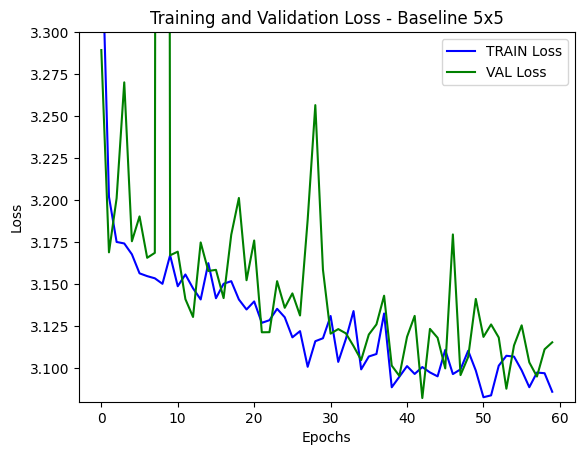

In [ ]:
checkpoint = torch.load('/content/model_baseline_5x5.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'Baseline 5x5', top_y=3.3, bottom_y=3.08)

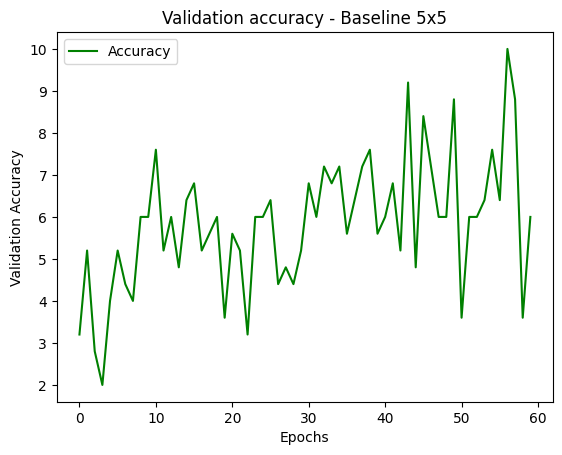

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'Baseline 5x5')

##### AlexNet Model

In [ ]:
#########################
####  AlexNet Model  ####
#########################

class AlexNetwork_5x5(nn.Module):
  def __init__(self, aux_logits = False):
      super(AlexNetwork_5x5, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(256, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 24)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output

  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

alexnet_model_5x5 = AlexNetwork_5x5().to(device)

###### AlexNet Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(alexnet_model_5x5.parameters(), lr=Config_5x5.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(alexnet_model_5x5, optimizer, criterion, scheduler, 'alexnet_5x5')

20it [00:08,  2.26it/s]
4it [00:01,  2.93it/s]


Val Progress --- total:250, correct:7
Val accuracy: 2.800%
Epoch [1/60], TRNLoss:3.3452, VALLoss:3.2706, Time:0.17


20it [00:09,  2.22it/s]
4it [00:01,  2.85it/s]


Val Progress --- total:250, correct:7
Val accuracy: 2.800%
Epoch [2/60], TRNLoss:3.2007, VALLoss:3.2015, Time:0.17


20it [00:08,  2.30it/s]
4it [00:01,  2.92it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch [3/60], TRNLoss:3.1785, VALLoss:3.1869, Time:0.17


20it [00:08,  2.42it/s]
4it [00:02,  1.97it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch [4/60], TRNLoss:3.1875, VALLoss:3.1654, Time:0.17


20it [00:07,  2.53it/s]
4it [00:01,  2.92it/s]


Val Progress --- total:250, correct:7
Val accuracy: 2.800%
Epoch [5/60], TRNLoss:3.1839, VALLoss:3.1986, Time:0.15


20it [00:08,  2.31it/s]
4it [00:01,  2.89it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [6/60], TRNLoss:3.1765, VALLoss:3.1707, Time:0.17


20it [00:08,  2.29it/s]
4it [00:01,  3.01it/s]


Val Progress --- total:250, correct:8
Val accuracy: 3.200%
Epoch [7/60], TRNLoss:3.1593, VALLoss:3.2094, Time:0.17


20it [00:08,  2.23it/s]
4it [00:01,  2.77it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [8/60], TRNLoss:3.1711, VALLoss:3.1950, Time:0.17


20it [00:08,  2.42it/s]
4it [00:02,  1.86it/s]


Val Progress --- total:250, correct:19
Val accuracy: 7.600%
Epoch [9/60], TRNLoss:3.1660, VALLoss:3.1455, Time:0.17


20it [00:07,  2.54it/s]
4it [00:01,  2.85it/s]


Val Progress --- total:250, correct:8
Val accuracy: 3.200%
Epoch [10/60], TRNLoss:3.1777, VALLoss:3.7472, Time:0.15


20it [00:08,  2.27it/s]
4it [00:01,  2.91it/s]


Val Progress --- total:250, correct:16
Val accuracy: 6.400%
Epoch [11/60], TRNLoss:3.1656, VALLoss:3.1708, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:8
Val accuracy: 3.200%
Epoch [12/60], TRNLoss:3.1669, VALLoss:3.1697, Time:0.17


20it [00:08,  2.28it/s]
4it [00:01,  2.85it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch [13/60], TRNLoss:3.1623, VALLoss:3.2274, Time:0.17


20it [00:07,  2.52it/s]
4it [00:02,  1.91it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch [14/60], TRNLoss:3.1610, VALLoss:3.1545, Time:0.17


20it [00:08,  2.49it/s]
4it [00:01,  2.85it/s]


Val Progress --- total:250, correct:19
Val accuracy: 7.600%
Epoch 00015: reducing learning rate of group 0 to 1.5000e-04.
Epoch [15/60], TRNLoss:3.1578, VALLoss:3.1554, Time:0.16


20it [00:08,  2.26it/s]
4it [00:01,  2.86it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [16/60], TRNLoss:3.1431, VALLoss:3.1591, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.84it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [17/60], TRNLoss:3.1326, VALLoss:3.1706, Time:0.17


20it [00:08,  2.28it/s]
4it [00:01,  2.94it/s]


Val Progress --- total:250, correct:9
Val accuracy: 3.600%
Epoch [18/60], TRNLoss:3.1419, VALLoss:3.1371, Time:0.17


20it [00:07,  2.54it/s]
4it [00:01,  2.03it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [19/60], TRNLoss:3.1384, VALLoss:3.1241, Time:0.16


20it [00:08,  2.44it/s]
4it [00:01,  2.91it/s]


Val Progress --- total:250, correct:19
Val accuracy: 7.600%
Epoch [20/60], TRNLoss:3.1467, VALLoss:3.1633, Time:0.16


20it [00:08,  2.29it/s]
4it [00:01,  2.88it/s]


Val Progress --- total:250, correct:16
Val accuracy: 6.400%
Epoch [21/60], TRNLoss:3.1390, VALLoss:3.1477, Time:0.17


20it [00:09,  2.22it/s]
4it [00:01,  2.86it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [22/60], TRNLoss:3.1280, VALLoss:3.1674, Time:0.17


20it [00:08,  2.23it/s]
4it [00:01,  2.85it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [23/60], TRNLoss:3.1287, VALLoss:3.1334, Time:0.17


20it [00:07,  2.53it/s]
4it [00:01,  2.06it/s]


Val Progress --- total:250, correct:18
Val accuracy: 7.200%
Epoch [24/60], TRNLoss:3.1195, VALLoss:3.1453, Time:0.16


20it [00:08,  2.42it/s]
4it [00:01,  2.86it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch 00025: reducing learning rate of group 0 to 4.5000e-05.
Epoch [25/60], TRNLoss:3.1328, VALLoss:3.1889, Time:0.16


20it [00:09,  2.21it/s]
4it [00:01,  2.99it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [26/60], TRNLoss:3.1212, VALLoss:3.1241, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.82it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [27/60], TRNLoss:3.1083, VALLoss:3.1081, Time:0.17


20it [00:08,  2.25it/s]
4it [00:01,  3.00it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [28/60], TRNLoss:3.1293, VALLoss:3.0973, Time:0.17


20it [00:08,  2.49it/s]
4it [00:01,  2.04it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch [29/60], TRNLoss:3.1109, VALLoss:3.1327, Time:0.17


20it [00:08,  2.40it/s]
4it [00:01,  2.77it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [30/60], TRNLoss:3.1226, VALLoss:3.1341, Time:0.16


20it [00:08,  2.24it/s]
4it [00:01,  2.77it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch [31/60], TRNLoss:3.1255, VALLoss:3.1266, Time:0.17


20it [00:08,  2.24it/s]
4it [00:01,  2.85it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [32/60], TRNLoss:3.1145, VALLoss:3.1191, Time:0.17


20it [00:08,  2.33it/s]
4it [00:01,  2.75it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [33/60], TRNLoss:3.1284, VALLoss:3.0966, Time:0.17


20it [00:07,  2.51it/s]
4it [00:01,  2.05it/s]


Val Progress --- total:250, correct:10
Val accuracy: 4.000%
Epoch [34/60], TRNLoss:3.1167, VALLoss:3.1841, Time:0.17


20it [00:08,  2.41it/s]
4it [00:01,  2.91it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [35/60], TRNLoss:3.1224, VALLoss:3.1147, Time:0.16


20it [00:08,  2.26it/s]
4it [00:01,  2.84it/s]


Val Progress --- total:250, correct:8
Val accuracy: 3.200%
Epoch [36/60], TRNLoss:3.1032, VALLoss:3.1537, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.91it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [37/60], TRNLoss:3.1258, VALLoss:3.1420, Time:0.17


20it [00:08,  2.24it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch [38/60], TRNLoss:3.1155, VALLoss:3.1294, Time:0.17


20it [00:07,  2.53it/s]
4it [00:01,  2.12it/s]


Val Progress --- total:250, correct:9
Val accuracy: 3.600%
Epoch 00039: reducing learning rate of group 0 to 1.3500e-05.
Epoch [39/60], TRNLoss:3.1232, VALLoss:3.1657, Time:0.16


20it [00:08,  2.40it/s]
4it [00:01,  2.95it/s]


Val Progress --- total:250, correct:10
Val accuracy: 4.000%
Epoch [40/60], TRNLoss:3.1138, VALLoss:3.1056, Time:0.16


20it [00:08,  2.30it/s]
4it [00:01,  2.92it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [41/60], TRNLoss:3.1161, VALLoss:3.1108, Time:0.17


20it [00:08,  2.26it/s]
4it [00:01,  2.88it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch [42/60], TRNLoss:3.1203, VALLoss:3.0818, Time:0.17


20it [00:08,  2.27it/s]
4it [00:01,  2.89it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch [43/60], TRNLoss:3.1247, VALLoss:3.0908, Time:0.17


20it [00:07,  2.51it/s]
4it [00:01,  2.12it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [44/60], TRNLoss:3.1153, VALLoss:3.1143, Time:0.16


20it [00:08,  2.41it/s]
4it [00:01,  2.93it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [45/60], TRNLoss:3.1225, VALLoss:3.1192, Time:0.16


20it [00:08,  2.27it/s]
4it [00:01,  2.86it/s]


Val Progress --- total:250, correct:10
Val accuracy: 4.000%
Epoch [46/60], TRNLoss:3.1017, VALLoss:3.1881, Time:0.17


20it [00:09,  2.21it/s]
4it [00:01,  2.84it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [47/60], TRNLoss:3.0993, VALLoss:3.1104, Time:0.17


20it [00:08,  2.27it/s]
4it [00:01,  2.83it/s]


Val Progress --- total:250, correct:10
Val accuracy: 4.000%
Epoch 00048: reducing learning rate of group 0 to 4.0500e-06.
Epoch [48/60], TRNLoss:3.1186, VALLoss:3.1298, Time:0.17


20it [00:08,  2.42it/s]
4it [00:02,  1.93it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [49/60], TRNLoss:3.1187, VALLoss:3.1474, Time:0.17


20it [00:08,  2.40it/s]
4it [00:01,  2.81it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch [50/60], TRNLoss:3.1064, VALLoss:3.1211, Time:0.16


20it [00:09,  2.22it/s]
4it [00:01,  2.78it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [51/60], TRNLoss:3.1048, VALLoss:3.1646, Time:0.17


20it [00:08,  2.23it/s]
4it [00:01,  2.80it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [52/60], TRNLoss:3.1149, VALLoss:3.1384, Time:0.17


20it [00:08,  2.27it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [53/60], TRNLoss:3.1151, VALLoss:3.1563, Time:0.17


20it [00:07,  2.52it/s]
4it [00:02,  1.86it/s]


Val Progress --- total:250, correct:18
Val accuracy: 7.200%
Epoch 00054: reducing learning rate of group 0 to 1.2150e-06.
Epoch [54/60], TRNLoss:3.0993, VALLoss:3.0916, Time:0.17


20it [00:08,  2.49it/s]
4it [00:01,  2.87it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [55/60], TRNLoss:3.1126, VALLoss:3.1419, Time:0.16


20it [00:08,  2.25it/s]
4it [00:01,  2.89it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [56/60], TRNLoss:3.1090, VALLoss:3.1284, Time:0.17


20it [00:08,  2.31it/s]
4it [00:01,  2.95it/s]


Val Progress --- total:250, correct:18
Val accuracy: 7.200%
Epoch [57/60], TRNLoss:3.1041, VALLoss:3.1130, Time:0.17


20it [00:08,  2.28it/s]
4it [00:01,  2.81it/s]


Val Progress --- total:250, correct:18
Val accuracy: 7.200%
Epoch [58/60], TRNLoss:3.1276, VALLoss:3.1192, Time:0.17


20it [00:07,  2.55it/s]
4it [00:01,  2.04it/s]


Val Progress --- total:250, correct:19
Val accuracy: 7.600%
Epoch [59/60], TRNLoss:3.1082, VALLoss:3.1117, Time:0.16


20it [00:08,  2.42it/s]
4it [00:01,  2.96it/s]


Val Progress --- total:250, correct:20
Val accuracy: 8.000%
Epoch 00060: reducing learning rate of group 0 to 3.6450e-07.
Epoch [60/60], TRNLoss:3.1258, VALLoss:3.0977, Time:0.16


###### AlexNet training and validation plots

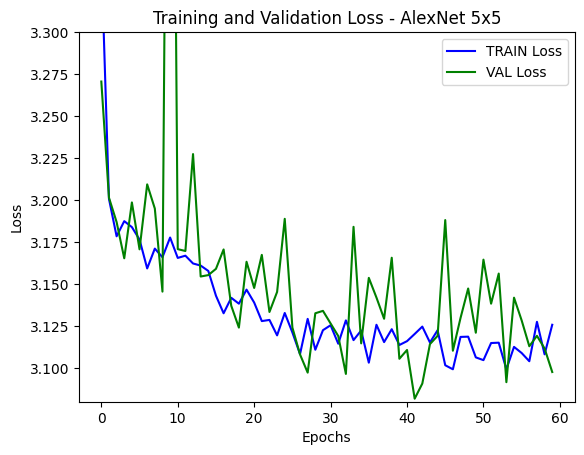

In [ ]:
checkpoint = torch.load('/content/model_alexnet_5x5.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'AlexNet 5x5', top_y=3.3, bottom_y=3.08)

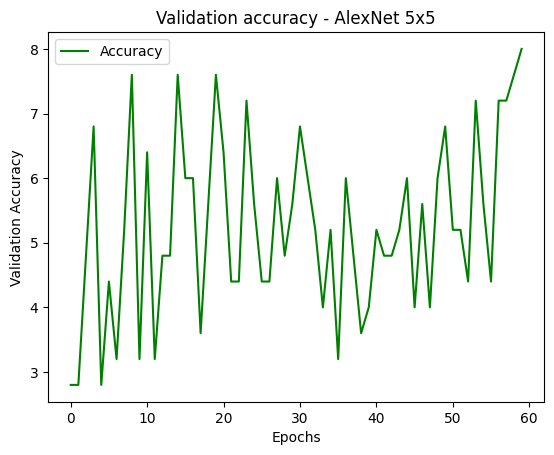

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'AlexNet 5x5')

##### VGG Model

In [ ]:
#########################
####    VGG Model    ####
#########################

class VggNet_5x5(nn.Module):
  def __init__(self, aux_logits = False):
      super(VggNet_5x5, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(4608, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )

      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 24)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output

  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

vgg_model_5x5 = VggNet_5x5().to(device)

###### VGG Model Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(vgg_model_5x5.parameters(), lr=Config_5x5.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(vgg_model_5x5, optimizer, criterion, scheduler, 'VGGNet_5x5')

20it [00:13,  1.47it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:10
Val accuracy: 4.000%
Epoch [1/60], TRNLoss:3.2010, VALLoss:3.1833, Time:0.26


20it [00:13,  1.50it/s]
4it [00:01,  2.46it/s]


Val Progress --- total:250, correct:5
Val accuracy: 2.000%
Epoch [2/60], TRNLoss:3.1786, VALLoss:3.3237, Time:0.25


20it [00:13,  1.49it/s]
4it [00:01,  2.39it/s]


Val Progress --- total:250, correct:10
Val accuracy: 4.000%
Epoch [3/60], TRNLoss:3.1898, VALLoss:5.7294, Time:0.25


20it [00:13,  1.48it/s]
4it [00:02,  1.99it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [4/60], TRNLoss:3.1788, VALLoss:3.5036, Time:0.26


20it [00:13,  1.49it/s]
4it [00:01,  2.04it/s]


Val Progress --- total:250, correct:7
Val accuracy: 2.800%
Epoch [5/60], TRNLoss:3.1775, VALLoss:3.4238, Time:0.26


20it [00:13,  1.52it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:9
Val accuracy: 3.600%
Epoch [6/60], TRNLoss:3.1802, VALLoss:28.2805, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.41it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch 00007: reducing learning rate of group 0 to 1.5000e-04.
Epoch [7/60], TRNLoss:3.1787, VALLoss:3.6464, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.39it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [8/60], TRNLoss:3.1774, VALLoss:3.1759, Time:0.25


20it [00:13,  1.51it/s]
4it [00:01,  2.29it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [9/60], TRNLoss:3.1764, VALLoss:3.2388, Time:0.25


20it [00:13,  1.49it/s]
4it [00:02,  1.86it/s]


Val Progress --- total:250, correct:7
Val accuracy: 2.800%
Epoch [10/60], TRNLoss:3.1751, VALLoss:3.9488, Time:0.26


20it [00:13,  1.51it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:9
Val accuracy: 3.600%
Epoch [11/60], TRNLoss:3.1774, VALLoss:3.1837, Time:0.25


20it [00:13,  1.49it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [12/60], TRNLoss:3.1780, VALLoss:3.1755, Time:0.25


20it [00:13,  1.51it/s]
4it [00:01,  2.40it/s]


Val Progress --- total:250, correct:9
Val accuracy: 3.600%
Epoch [13/60], TRNLoss:3.1788, VALLoss:3.1770, Time:0.25


20it [00:13,  1.50it/s]
4it [00:01,  2.41it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [14/60], TRNLoss:3.1783, VALLoss:3.1790, Time:0.25


20it [00:13,  1.51it/s]
4it [00:02,  1.80it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [15/60], TRNLoss:3.1781, VALLoss:3.1787, Time:0.26


20it [00:13,  1.52it/s]
4it [00:01,  2.45it/s]


Val Progress --- total:250, correct:11
Val accuracy: 4.400%
Epoch [16/60], TRNLoss:3.1789, VALLoss:3.1705, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.43it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [17/60], TRNLoss:3.1781, VALLoss:3.3465, Time:0.25


20it [00:13,  1.51it/s]
4it [00:01,  2.41it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [18/60], TRNLoss:3.1760, VALLoss:3.1822, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.44it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [19/60], TRNLoss:3.1729, VALLoss:3.1691, Time:0.25


20it [00:13,  1.52it/s]
4it [00:02,  1.74it/s]


Val Progress --- total:250, correct:10
Val accuracy: 4.000%
Epoch [20/60], TRNLoss:3.1689, VALLoss:3.1779, Time:0.26


20it [00:13,  1.50it/s]
4it [00:01,  2.43it/s]


Val Progress --- total:250, correct:10
Val accuracy: 4.000%
Epoch [21/60], TRNLoss:3.1757, VALLoss:3.1838, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.44it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [22/60], TRNLoss:3.1592, VALLoss:3.1783, Time:0.25


20it [00:13,  1.51it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:10
Val accuracy: 4.000%
Epoch [23/60], TRNLoss:3.1644, VALLoss:3.6661, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.44it/s]


Val Progress --- total:250, correct:8
Val accuracy: 3.200%
Epoch [24/60], TRNLoss:3.1648, VALLoss:3.1827, Time:0.25


20it [00:13,  1.52it/s]
4it [00:02,  1.99it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch 00025: reducing learning rate of group 0 to 4.5000e-05.
Epoch [25/60], TRNLoss:3.1512, VALLoss:3.1775, Time:0.25


20it [00:13,  1.49it/s]
4it [00:01,  2.22it/s]


Val Progress --- total:250, correct:6
Val accuracy: 2.400%
Epoch [26/60], TRNLoss:3.1610, VALLoss:3.1822, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:9
Val accuracy: 3.600%
Epoch [27/60], TRNLoss:3.1434, VALLoss:3.1602, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.44it/s]


Val Progress --- total:250, correct:16
Val accuracy: 6.400%
Epoch [28/60], TRNLoss:3.1501, VALLoss:3.1554, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.43it/s]


Val Progress --- total:250, correct:9
Val accuracy: 3.600%
Epoch [29/60], TRNLoss:3.1383, VALLoss:3.2026, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.41it/s]


Val Progress --- total:250, correct:7
Val accuracy: 2.800%
Epoch [30/60], TRNLoss:3.1497, VALLoss:3.1692, Time:0.25


20it [00:13,  1.51it/s]
4it [00:02,  1.80it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch [31/60], TRNLoss:3.1416, VALLoss:3.1640, Time:0.26


20it [00:13,  1.52it/s]
4it [00:01,  2.45it/s]


Val Progress --- total:250, correct:18
Val accuracy: 7.200%
Epoch [32/60], TRNLoss:3.1426, VALLoss:3.1453, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.45it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [33/60], TRNLoss:3.1443, VALLoss:3.1571, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.40it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [34/60], TRNLoss:3.1480, VALLoss:3.1622, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.43it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch [35/60], TRNLoss:3.1493, VALLoss:3.1628, Time:0.25


20it [00:13,  1.51it/s]
4it [00:02,  1.69it/s]


Val Progress --- total:250, correct:16
Val accuracy: 6.400%
Epoch [36/60], TRNLoss:3.1410, VALLoss:3.1345, Time:0.26


20it [00:13,  1.45it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:18
Val accuracy: 7.200%
Epoch [37/60], TRNLoss:3.1428, VALLoss:3.1607, Time:0.26


20it [00:13,  1.53it/s]
4it [00:01,  2.46it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch [38/60], TRNLoss:3.1370, VALLoss:3.1489, Time:0.24


20it [00:13,  1.52it/s]
4it [00:01,  2.44it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [39/60], TRNLoss:3.1501, VALLoss:3.1419, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.41it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [40/60], TRNLoss:3.1269, VALLoss:3.1259, Time:0.25


20it [00:13,  1.52it/s]
4it [00:02,  1.86it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [41/60], TRNLoss:3.1261, VALLoss:3.1181, Time:0.26


20it [00:13,  1.52it/s]
4it [00:01,  2.36it/s]


Val Progress --- total:250, correct:15
Val accuracy: 6.000%
Epoch [42/60], TRNLoss:3.1347, VALLoss:3.1553, Time:0.25


20it [00:13,  1.51it/s]
4it [00:01,  2.40it/s]


Val Progress --- total:250, correct:10
Val accuracy: 4.000%
Epoch [43/60], TRNLoss:3.1405, VALLoss:3.1491, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch [44/60], TRNLoss:3.1397, VALLoss:3.1464, Time:0.25


20it [00:13,  1.51it/s]
4it [00:01,  2.40it/s]


Val Progress --- total:250, correct:7
Val accuracy: 2.800%
Epoch [45/60], TRNLoss:3.1330, VALLoss:3.1475, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.09it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [46/60], TRNLoss:3.1196, VALLoss:3.1556, Time:0.25


20it [00:13,  1.51it/s]
4it [00:01,  2.02it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch 00047: reducing learning rate of group 0 to 1.3500e-05.
Epoch [47/60], TRNLoss:3.1373, VALLoss:3.1518, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.41it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch [48/60], TRNLoss:3.1419, VALLoss:3.1327, Time:0.25


20it [00:13,  1.54it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:16
Val accuracy: 6.400%
Epoch [49/60], TRNLoss:3.1307, VALLoss:3.1120, Time:0.24


20it [00:13,  1.51it/s]
4it [00:01,  2.40it/s]


Val Progress --- total:250, correct:18
Val accuracy: 7.200%
Epoch [50/60], TRNLoss:3.1070, VALLoss:3.1023, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.44it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [51/60], TRNLoss:3.1179, VALLoss:3.1211, Time:0.25


20it [00:13,  1.51it/s]
4it [00:02,  1.74it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [52/60], TRNLoss:3.1260, VALLoss:3.1511, Time:0.26


20it [00:13,  1.52it/s]
4it [00:01,  2.48it/s]


Val Progress --- total:250, correct:24
Val accuracy: 9.600%
Epoch [53/60], TRNLoss:3.1143, VALLoss:3.1173, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.42it/s]


Val Progress --- total:250, correct:16
Val accuracy: 6.400%
Epoch [54/60], TRNLoss:3.1165, VALLoss:3.0927, Time:0.25


20it [00:13,  1.53it/s]
4it [00:01,  2.43it/s]


Val Progress --- total:250, correct:13
Val accuracy: 5.200%
Epoch [55/60], TRNLoss:3.1126, VALLoss:3.1426, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.44it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch [56/60], TRNLoss:3.1032, VALLoss:3.1124, Time:0.25


20it [00:13,  1.53it/s]
4it [00:02,  1.83it/s]


Val Progress --- total:250, correct:21
Val accuracy: 8.400%
Epoch [57/60], TRNLoss:3.1133, VALLoss:3.0772, Time:0.26


20it [00:13,  1.52it/s]
4it [00:01,  2.31it/s]


Val Progress --- total:250, correct:12
Val accuracy: 4.800%
Epoch [58/60], TRNLoss:3.1121, VALLoss:3.1466, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.39it/s]


Val Progress --- total:250, correct:17
Val accuracy: 6.800%
Epoch [59/60], TRNLoss:3.0995, VALLoss:3.0852, Time:0.25


20it [00:13,  1.52it/s]
4it [00:01,  2.45it/s]


Val Progress --- total:250, correct:14
Val accuracy: 5.600%
Epoch [60/60], TRNLoss:3.0960, VALLoss:3.1301, Time:0.25


###### VGG Model training and validation plots

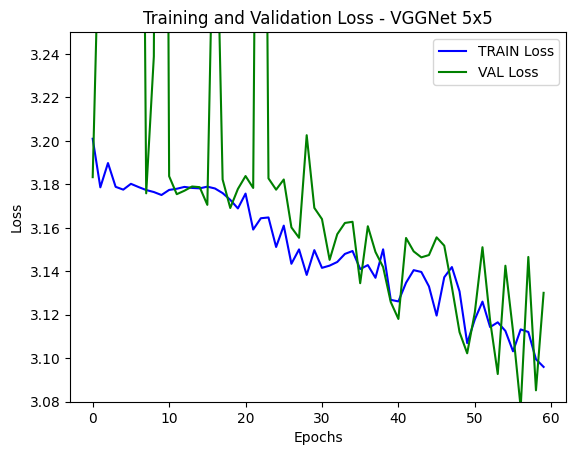

In [ ]:
checkpoint = torch.load('/content/model_VGGNet_5x5.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'VGGNet 5x5', top_y=3.25, bottom_y=3.08)

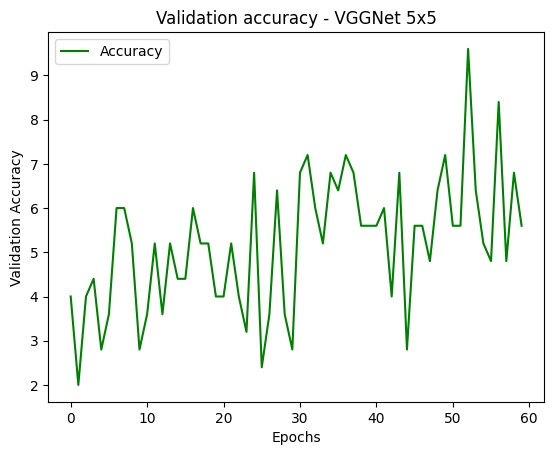

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'VGGNet 5x5')

## Image Classification

### Connection to Google Drive

The connection to Google Drive is necessary to reuse the pre-trained models. From here inwards, if your models arent't in _gdrive/MyDrive/Models_ you have to change the paths present in the code

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Config

In [ ]:
class Config_image_classification():
  batch_size = 64
  num_epochs = 30
  lr = 0.0005

### Training, Validation and Test Set creation

In [ ]:
# 400 immages for each class => 300 training - 50 validation - 50 test set

df_image_classification_train = pd.DataFrame(data=[], columns=['filename', 'class'])
df_image_classification_val = pd.DataFrame(data=[], columns=['filename', 'class'])
df_image_classification_test = pd.DataFrame(data=[], columns=['filename', 'class'])

for c in classes:
  df_image_classification_train = pd.concat([df_image_classification_train, df_image_classification.loc[df_image_classification['class'] == c][:300]])
  df_image_classification_val = pd.concat([df_image_classification_val, df_image_classification.loc[df_image_classification['class'] == c][300:350]])
  df_image_classification_test = pd.concat([df_image_classification_test, df_image_classification.loc[df_image_classification['class'] == c][350:]])

In [ ]:
print(df_image_classification_train)

                                               filename      class
150   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
151   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
152   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
153   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
154   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
...                                                 ...        ...
4945  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810
4946  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810
4947  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810
4948  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810
4949  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810

[3000 rows x 2 columns]


In [ ]:
print(df_image_classification_val)

                                               filename      class
450   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
451   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
452   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
453   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
454   tiny-imagenet-200/train/n02504458/images/n0250...  n02504458
...                                                 ...        ...
4995  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810
4996  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810
4997  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810
4998  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810
4999  tiny-imagenet-200/train/n07871810/images/n0787...  n07871810

[500 rows x 2 columns]


In [ ]:
print(df_image_classification_test)

                                        filename      class
48      tiny-imagenet-200/val/images/val_48.JPEG  n02504458
116    tiny-imagenet-200/val/images/val_116.JPEG  n02504458
187    tiny-imagenet-200/val/images/val_187.JPEG  n02504458
274    tiny-imagenet-200/val/images/val_274.JPEG  n02504458
483    tiny-imagenet-200/val/images/val_483.JPEG  n02504458
...                                          ...        ...
8535  tiny-imagenet-200/val/images/val_8535.JPEG  n07871810
8663  tiny-imagenet-200/val/images/val_8663.JPEG  n07871810
8882  tiny-imagenet-200/val/images/val_8882.JPEG  n07871810
8911  tiny-imagenet-200/val/images/val_8911.JPEG  n07871810
9236  tiny-imagenet-200/val/images/val_9236.JPEG  n07871810

[500 rows x 2 columns]


### MyDataset class



In [ ]:
class MyDataset(Dataset):
  def __init__(self, df, classes, transform=None):
      self.train_data = df.values
      self.classes = classes
      self.transform = transform

  def __len__(self):
    return len(self.train_data)
  
  def __getitem__(self, index):
    image = np.array(Image.open(self.train_data[index][0]).convert('RGB'))
    image_label = self.classes.index(self.train_data[index][1])

    if image.shape[0] != 96:
        image = skimage.transform.resize(image, (96, 96))
        image = img_as_float32(image)

    image_label = np.array(image_label).astype(np.int64)

    if self.transform:
      image = self.transform(image)

    return image, image_label

### Datasets Loaders

In [ ]:
##########################################################
#### Creating Train/Validation dataset and dataloader ####
##########################################################

traindataset = MyDataset(df_image_classification_train, classes,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                  std=[0.229, 0.224, 0.225])]))
trainloader = torch.utils.data.DataLoader(traindataset, 
                                          batch_size=Config_image_classification.batch_size,
                                          shuffle=True)


valdataset = MyDataset(df_image_classification_val, classes,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                  std=[0.229, 0.224, 0.225])]))
valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=Config_image_classification.batch_size,
                                        shuffle=False)

testdataset = MyDataset(df_image_classification_test, classes,
                         transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                  std=[0.229, 0.224, 0.225])]))
testloader = torch.utils.data.DataLoader(testdataset,
                                        batch_size=Config_image_classification.batch_size,
                                        shuffle=False)

### Datasets Visualization

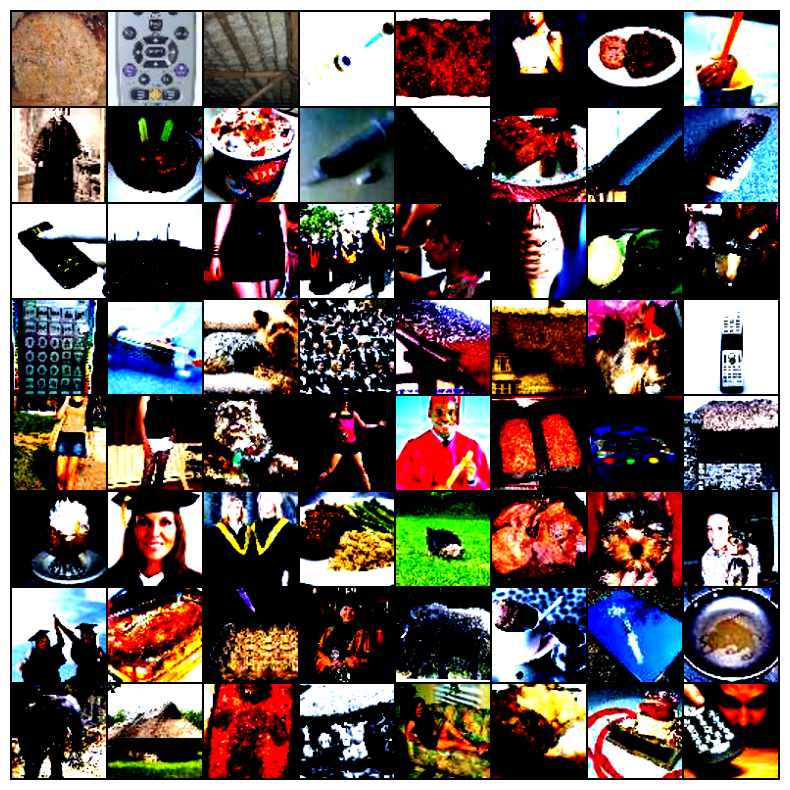

Labels: [9 3 7 6 9 4 9 8 1 9 8 6 7 9 7 3 3 7 4 1 1 8 8 4 3 6 5 1 7 7 5 3 4 4 5 4 1
 9 3 7 8 1 1 9 5 2 5 5 1 9 6 1 0 8 6 2 0 7 9 7 4 9 8 3]


In [ ]:
######################################
#### Visualizing training dataset ####
######################################

example_batch = next(iter(trainloader))
imshow(torchvision.utils.make_grid(unorm(example_batch[0])))
print(f'Labels: {example_batch[1].numpy()}')

### Useful functions

#### Training function

In [ ]:
##############################
# Training/Validation Engine #
##############################

def model_training(model, optimizer, criterion, scheduler, model_name):
  global_trn_loss = []
  global_val_loss = []
  accuracy = []

  for epoch in range(Config_image_classification.num_epochs):
      train_running_loss = []
      val_running_loss = []
      start_time = time.time()
      model.train()
      for idx, data in tqdm(enumerate(trainloader), total=int(len(traindataset)/Config_image_classification.batch_size)):
          image, image_label = data[0].to(device), data[1].to(device)
          optimizer.zero_grad()
          output = model(image)
          loss = criterion(output, image_label)
          loss.backward()
          optimizer.step()
          
          train_running_loss.append(loss.item())
      else:
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
          for idx, data in tqdm(enumerate(valloader), total=int(len(valdataset)/Config_image_classification.batch_size)):
            image, image_label = data[0].to(device), data[1].to(device)
            output = model(image)
            loss = criterion(output, image_label)
            val_running_loss.append(loss.item())
          
            _, predicted = torch.max(output.data, 1)
            total += image_label.size(0)
            correct += (predicted == image_label).sum()
          print('Val Progress --- total:{}, correct:{}'.format(total, correct.item()))
          print('Val accuracy: {:.3f}%'.format(100 * correct / total))

      global_trn_loss.append(sum(train_running_loss) / len(train_running_loss))
      global_val_loss.append(sum(val_running_loss) / len(val_running_loss))
      accuracy.append(100 * correct / total)

      scheduler.step(global_val_loss[-1])

      print('Epoch [{}/{}], TRNLoss:{:.4f}, VALLoss:{:.4f}, Time:{:.2f}'.format(
          epoch + 1, Config_image_classification.num_epochs, global_trn_loss[-1], global_val_loss[-1],
          (time.time() - start_time) / 60))
      
  MODEL_SAVE_PATH = f'/content/model_{model_name}.pt'
  torch.save(
    {
        'epoch': Config_image_classification.num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'global_trnloss': global_trn_loss,
        'global_valloss': global_val_loss,
        'accuracy' : accuracy
    }, MODEL_SAVE_PATH)

#### Testing function

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def score(y_true, y_pred):
  scores = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  average_scores = precision_recall_fscore_support(y_true, y_pred, average="macro")

  print("\nScores for each class:")
  for i, c in enumerate(classes):
    print(f'{c} => Precision: {scores[0][i]}, Recall: {scores[1][i]}, F-Score: {scores[2][i]}')
  
  print(f'\nAverage Precision: {average_scores[0]}, Average Recall: {average_scores[1]}, Average F-Score: {average_scores[2]}')
  

def model_testing(model):
  model.eval()

  total = 0
  correct = 0
  true_labels = []
  predicted_labels = []  

  with torch.no_grad():
    for data in testloader:
      image, image_label = data[0].to(device), data[1].to(device)
      output = model(image)
    
      _, predicted = torch.max(output.data, 1)
      total += image_label.size(0)
      correct += (predicted == image_label).sum().item()
      
      image_label = image_label.detach().cpu().numpy()
      predicted = predicted.detach().cpu().numpy()

      for i in range(len(image_label)):
        true_labels.append(image_label[i])
        predicted_labels.append(predicted[i])
    
  print('Test --- total:{}, correct:{}'.format(total, correct))
  print('Accuracy: {}%'.format(100 * correct / total))
  score(true_labels, predicted_labels)


### Models Training from scratch

#### Baseline Model

In [ ]:
##########################
####     Baseline     ####
##########################

class BaselineModel(nn.Module):
  def __init__(self, aux_logits = False):
      super(BaselineModel, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(256, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )

      self.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

  def forward(self, image):
    output= self.cnn(image)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

baseline_model = BaselineModel().to(device)

##### Baseline Model Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(baseline_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(baseline_model, optimizer, criterion, scheduler, 'baseline_image_classification')

47it [00:21,  2.21it/s]
8it [00:01,  4.23it/s]


Val Progress --- total:500, correct:161
Val accuracy: 32.200%
Epoch [1/30], TRNLoss:1.9279, VALLoss:1.8400, Time:0.39


47it [00:13,  3.58it/s]
8it [00:01,  4.65it/s]


Val Progress --- total:500, correct:203
Val accuracy: 40.600%
Epoch [2/30], TRNLoss:1.5511, VALLoss:1.8597, Time:0.25


47it [00:13,  3.58it/s]
8it [00:01,  4.15it/s]


Val Progress --- total:500, correct:249
Val accuracy: 49.800%
Epoch [3/30], TRNLoss:1.3772, VALLoss:1.4695, Time:0.25


47it [00:13,  3.58it/s]
8it [00:02,  3.41it/s]


Val Progress --- total:500, correct:181
Val accuracy: 36.200%
Epoch [4/30], TRNLoss:1.2323, VALLoss:2.1040, Time:0.26


47it [00:13,  3.61it/s]
8it [00:01,  4.51it/s]


Val Progress --- total:500, correct:261
Val accuracy: 52.200%
Epoch [5/30], TRNLoss:1.1650, VALLoss:1.4271, Time:0.25


47it [00:12,  3.64it/s]
8it [00:01,  4.73it/s]


Val Progress --- total:500, correct:249
Val accuracy: 49.800%
Epoch [6/30], TRNLoss:1.0024, VALLoss:1.5813, Time:0.24


47it [00:13,  3.61it/s]
8it [00:01,  4.61it/s]


Val Progress --- total:500, correct:260
Val accuracy: 52.000%
Epoch [7/30], TRNLoss:0.8919, VALLoss:1.4451, Time:0.25


47it [00:12,  3.63it/s]
8it [00:01,  4.67it/s]


Val Progress --- total:500, correct:231
Val accuracy: 46.200%
Epoch [8/30], TRNLoss:0.8392, VALLoss:1.8954, Time:0.25


47it [00:13,  3.57it/s]
8it [00:01,  4.70it/s]


Val Progress --- total:500, correct:251
Val accuracy: 50.200%
Epoch [9/30], TRNLoss:0.6983, VALLoss:1.8977, Time:0.25


47it [00:13,  3.58it/s]
8it [00:02,  3.12it/s]


Val Progress --- total:500, correct:289
Val accuracy: 57.800%
Epoch [10/30], TRNLoss:0.6435, VALLoss:1.3695, Time:0.26


47it [00:13,  3.58it/s]
8it [00:01,  4.65it/s]


Val Progress --- total:500, correct:249
Val accuracy: 49.800%
Epoch [11/30], TRNLoss:0.5765, VALLoss:2.1545, Time:0.25


47it [00:13,  3.60it/s]
8it [00:01,  4.63it/s]


Val Progress --- total:500, correct:252
Val accuracy: 50.400%
Epoch [12/30], TRNLoss:0.4566, VALLoss:2.1277, Time:0.25


47it [00:13,  3.58it/s]
8it [00:01,  4.63it/s]


Val Progress --- total:500, correct:268
Val accuracy: 53.600%
Epoch [13/30], TRNLoss:0.5119, VALLoss:2.0094, Time:0.25


47it [00:13,  3.41it/s]
8it [00:01,  4.72it/s]


Val Progress --- total:500, correct:226
Val accuracy: 45.200%
Epoch [14/30], TRNLoss:0.4228, VALLoss:2.2974, Time:0.26


47it [00:12,  3.62it/s]
8it [00:01,  4.58it/s]


Val Progress --- total:500, correct:272
Val accuracy: 54.400%
Epoch [15/30], TRNLoss:0.3479, VALLoss:5.5735, Time:0.25


47it [00:13,  3.57it/s]
8it [00:02,  3.12it/s]


Val Progress --- total:500, correct:117
Val accuracy: 23.400%
Epoch 00016: reducing learning rate of group 0 to 1.5000e-04.
Epoch [16/30], TRNLoss:0.3439, VALLoss:7.6740, Time:0.26


47it [00:13,  3.58it/s]
8it [00:01,  4.61it/s]


Val Progress --- total:500, correct:312
Val accuracy: 62.400%
Epoch [17/30], TRNLoss:0.2441, VALLoss:1.7334, Time:0.25


47it [00:13,  3.58it/s]
8it [00:01,  4.80it/s]


Val Progress --- total:500, correct:308
Val accuracy: 61.600%
Epoch [18/30], TRNLoss:0.0932, VALLoss:1.9630, Time:0.25


47it [00:13,  3.58it/s]
8it [00:01,  4.67it/s]


Val Progress --- total:500, correct:300
Val accuracy: 60.000%
Epoch [19/30], TRNLoss:0.0440, VALLoss:2.1529, Time:0.25


47it [00:13,  3.55it/s]
8it [00:01,  4.67it/s]


Val Progress --- total:500, correct:315
Val accuracy: 63.000%
Epoch [20/30], TRNLoss:0.0343, VALLoss:2.1129, Time:0.25


47it [00:13,  3.59it/s]
8it [00:01,  4.66it/s]


Val Progress --- total:500, correct:315
Val accuracy: 63.000%
Epoch [21/30], TRNLoss:0.0298, VALLoss:2.3306, Time:0.25


47it [00:13,  3.56it/s]
8it [00:02,  3.07it/s]


Val Progress --- total:500, correct:314
Val accuracy: 62.800%
Epoch 00022: reducing learning rate of group 0 to 4.5000e-05.
Epoch [22/30], TRNLoss:0.0300, VALLoss:2.5163, Time:0.26


47it [00:13,  3.57it/s]
8it [00:01,  4.75it/s]


Val Progress --- total:500, correct:310
Val accuracy: 62.000%
Epoch [23/30], TRNLoss:0.0209, VALLoss:2.2207, Time:0.25


47it [00:13,  3.59it/s]
8it [00:01,  4.66it/s]


Val Progress --- total:500, correct:309
Val accuracy: 61.800%
Epoch [24/30], TRNLoss:0.0092, VALLoss:2.2563, Time:0.25


47it [00:13,  3.61it/s]
8it [00:01,  4.72it/s]


Val Progress --- total:500, correct:313
Val accuracy: 62.600%
Epoch [25/30], TRNLoss:0.0109, VALLoss:2.2160, Time:0.25


47it [00:13,  3.61it/s]
8it [00:01,  4.62it/s]


Val Progress --- total:500, correct:317
Val accuracy: 63.400%
Epoch [26/30], TRNLoss:0.0052, VALLoss:2.2372, Time:0.25


47it [00:12,  3.63it/s]
8it [00:01,  4.68it/s]


Val Progress --- total:500, correct:317
Val accuracy: 63.400%
Epoch [27/30], TRNLoss:0.0045, VALLoss:2.3084, Time:0.24


47it [00:12,  3.62it/s]
8it [00:02,  3.31it/s]


Val Progress --- total:500, correct:312
Val accuracy: 62.400%
Epoch 00028: reducing learning rate of group 0 to 1.3500e-05.
Epoch [28/30], TRNLoss:0.0048, VALLoss:2.3466, Time:0.26


47it [00:13,  3.55it/s]
8it [00:01,  4.29it/s]


Val Progress --- total:500, correct:316
Val accuracy: 63.200%
Epoch [29/30], TRNLoss:0.0034, VALLoss:2.3395, Time:0.25


47it [00:13,  3.55it/s]
8it [00:01,  4.60it/s]


Val Progress --- total:500, correct:310
Val accuracy: 62.000%
Epoch [30/30], TRNLoss:0.0039, VALLoss:2.3584, Time:0.25


##### Baseline Model training and validation plots

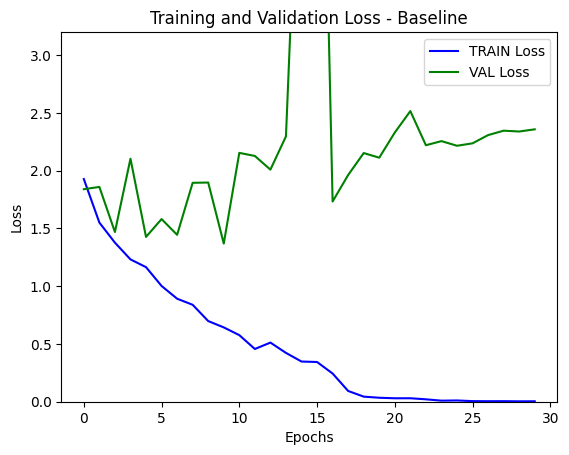

In [ ]:
checkpoint = torch.load('/content/model_baseline_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'Baseline', top_y=3.2, bottom_y=0)

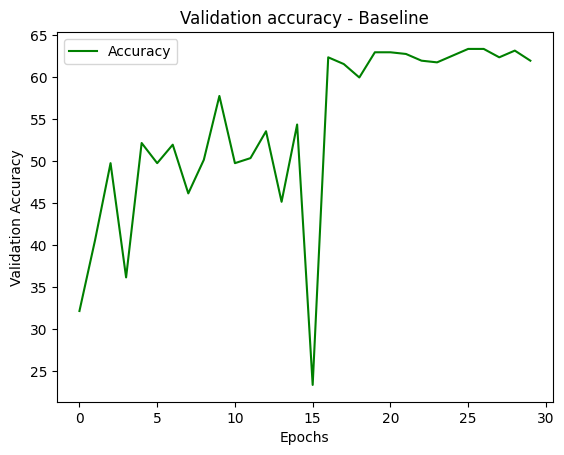

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'Baseline')

##### Baseline Model Testing

In [ ]:
baseline_model = BaselineModel().to(device)
baseline_model.load_state_dict(checkpoint['model_state_dict'])

model_testing(baseline_model)

Test --- total:500, correct:314
Accuracy: 62.8%

Scores for each class:
n01629819 => Precision: 0.7954545454545454, Recall: 0.7, F-Score: 0.7446808510638298
n07583066 => Precision: 0.7045454545454546, Recall: 0.62, F-Score: 0.6595744680851063
n04366367 => Precision: 0.7307692307692307, Recall: 0.76, F-Score: 0.7450980392156863
n07715103 => Precision: 0.725, Recall: 0.58, F-Score: 0.6444444444444445
n02364673 => Precision: 0.5714285714285714, Recall: 0.56, F-Score: 0.5656565656565656
n02823428 => Precision: 0.5714285714285714, Recall: 0.48, F-Score: 0.5217391304347826
n03424325 => Precision: 0.4, Recall: 0.6, F-Score: 0.48
n03617480 => Precision: 0.5686274509803921, Recall: 0.58, F-Score: 0.5742574257425743
n07753592 => Precision: 0.5833333333333334, Recall: 0.7, F-Score: 0.6363636363636365
n02509815 => Precision: 0.813953488372093, Recall: 0.7, F-Score: 0.7526881720430109

Average Precision: 0.6464540646312191, Average Recall: 0.6279999999999999, Average F-Score: 0.6324502733049637


#### AlexNet Model

In [ ]:
#########################
####  AlexNet Model  ####
#########################

class AlexNetwork(nn.Module):
  def __init__(self, aux_logits = False):
      super(AlexNetwork, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(256, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

  def forward(self, image):
    output= self.cnn(image)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

alexnet_model = AlexNetwork().to(device)

##### AlexNet Model Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(alexnet_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(alexnet_model, optimizer, criterion, scheduler, 'alexnet_image_classification')

47it [00:13,  3.48it/s]
8it [00:01,  4.75it/s]


Val Progress --- total:500, correct:106
Val accuracy: 21.200%
Epoch [1/30], TRNLoss:2.0129, VALLoss:2.2360, Time:0.25


47it [00:13,  3.48it/s]
8it [00:01,  4.67it/s]


Val Progress --- total:500, correct:174
Val accuracy: 34.800%
Epoch [2/30], TRNLoss:1.6969, VALLoss:1.8282, Time:0.25


47it [00:13,  3.51it/s]
8it [00:02,  3.50it/s]


Val Progress --- total:500, correct:242
Val accuracy: 48.400%
Epoch [3/30], TRNLoss:1.4831, VALLoss:17.9969, Time:0.26


47it [00:13,  3.47it/s]
8it [00:02,  3.81it/s]


Val Progress --- total:500, correct:220
Val accuracy: 44.000%
Epoch [4/30], TRNLoss:1.3848, VALLoss:1.9291, Time:0.26


47it [00:13,  3.46it/s]
8it [00:01,  4.53it/s]


Val Progress --- total:500, correct:192
Val accuracy: 38.400%
Epoch [5/30], TRNLoss:1.2287, VALLoss:1.9408, Time:0.26


47it [00:13,  3.48it/s]
8it [00:01,  4.57it/s]


Val Progress --- total:500, correct:209
Val accuracy: 41.800%
Epoch [6/30], TRNLoss:1.0627, VALLoss:1.9975, Time:0.25


47it [00:13,  3.49it/s]
8it [00:01,  4.55it/s]


Val Progress --- total:500, correct:235
Val accuracy: 47.000%
Epoch [7/30], TRNLoss:0.9657, VALLoss:1.7443, Time:0.25


47it [00:13,  3.54it/s]
8it [00:02,  3.78it/s]


Val Progress --- total:500, correct:208
Val accuracy: 41.600%
Epoch [8/30], TRNLoss:0.8573, VALLoss:2.1442, Time:0.26


47it [00:13,  3.45it/s]
8it [00:02,  3.81it/s]


Val Progress --- total:500, correct:213
Val accuracy: 42.600%
Epoch [9/30], TRNLoss:0.7959, VALLoss:2.1087, Time:0.26


47it [00:13,  3.46it/s]
8it [00:01,  4.62it/s]


Val Progress --- total:500, correct:257
Val accuracy: 51.400%
Epoch [10/30], TRNLoss:0.7266, VALLoss:1.6566, Time:0.26


47it [00:13,  3.54it/s]
8it [00:01,  4.72it/s]


Val Progress --- total:500, correct:259
Val accuracy: 51.800%
Epoch [11/30], TRNLoss:0.5524, VALLoss:1.9421, Time:0.25


47it [00:13,  3.54it/s]
8it [00:01,  4.70it/s]


Val Progress --- total:500, correct:283
Val accuracy: 56.600%
Epoch [12/30], TRNLoss:0.5803, VALLoss:1.7594, Time:0.25


47it [00:13,  3.56it/s]
8it [00:01,  4.62it/s]


Val Progress --- total:500, correct:203
Val accuracy: 40.600%
Epoch [13/30], TRNLoss:0.5094, VALLoss:3.2819, Time:0.25


47it [00:13,  3.52it/s]
8it [00:02,  3.04it/s]


Val Progress --- total:500, correct:234
Val accuracy: 46.800%
Epoch [14/30], TRNLoss:0.4492, VALLoss:2.6470, Time:0.27


47it [00:13,  3.52it/s]
8it [00:01,  4.67it/s]


Val Progress --- total:500, correct:241
Val accuracy: 48.200%
Epoch [15/30], TRNLoss:0.4552, VALLoss:2.0659, Time:0.25


47it [00:13,  3.52it/s]
8it [00:01,  4.68it/s]


Val Progress --- total:500, correct:274
Val accuracy: 54.800%
Epoch 00016: reducing learning rate of group 0 to 1.5000e-04.
Epoch [16/30], TRNLoss:0.3409, VALLoss:2.2269, Time:0.25


47it [00:13,  3.38it/s]
8it [00:01,  4.62it/s]


Val Progress --- total:500, correct:299
Val accuracy: 59.800%
Epoch [17/30], TRNLoss:0.1454, VALLoss:2.0867, Time:0.26


47it [00:13,  3.54it/s]
8it [00:01,  4.61it/s]


Val Progress --- total:500, correct:313
Val accuracy: 62.600%
Epoch [18/30], TRNLoss:0.0679, VALLoss:2.1816, Time:0.25


47it [00:13,  3.56it/s]
8it [00:02,  3.27it/s]


Val Progress --- total:500, correct:308
Val accuracy: 61.600%
Epoch [19/30], TRNLoss:0.0441, VALLoss:2.4853, Time:0.26


47it [00:13,  3.49it/s]
8it [00:01,  4.65it/s]


Val Progress --- total:500, correct:302
Val accuracy: 60.400%
Epoch [20/30], TRNLoss:0.0334, VALLoss:2.5739, Time:0.25


47it [00:13,  3.55it/s]
8it [00:01,  4.64it/s]


Val Progress --- total:500, correct:310
Val accuracy: 62.000%
Epoch [21/30], TRNLoss:0.0267, VALLoss:2.5821, Time:0.25


47it [00:13,  3.56it/s]
8it [00:01,  4.59it/s]


Val Progress --- total:500, correct:315
Val accuracy: 63.000%
Epoch 00022: reducing learning rate of group 0 to 4.5000e-05.
Epoch [22/30], TRNLoss:0.0181, VALLoss:2.7803, Time:0.25


47it [00:13,  3.54it/s]
8it [00:01,  4.61it/s]


Val Progress --- total:500, correct:311
Val accuracy: 62.200%
Epoch [23/30], TRNLoss:0.0123, VALLoss:2.7999, Time:0.25


47it [00:13,  3.54it/s]
8it [00:01,  4.33it/s]


Val Progress --- total:500, correct:311
Val accuracy: 62.200%
Epoch [24/30], TRNLoss:0.0070, VALLoss:2.7761, Time:0.25


47it [00:13,  3.48it/s]
8it [00:02,  3.39it/s]


Val Progress --- total:500, correct:313
Val accuracy: 62.600%
Epoch [25/30], TRNLoss:0.0057, VALLoss:2.7888, Time:0.27


47it [00:13,  3.53it/s]
8it [00:01,  4.64it/s]


Val Progress --- total:500, correct:306
Val accuracy: 61.200%
Epoch [26/30], TRNLoss:0.0065, VALLoss:2.8925, Time:0.25


47it [00:13,  3.55it/s]
8it [00:01,  4.61it/s]


Val Progress --- total:500, correct:309
Val accuracy: 61.800%
Epoch [27/30], TRNLoss:0.0042, VALLoss:2.8619, Time:0.25


47it [00:13,  3.53it/s]
8it [00:01,  4.62it/s]


Val Progress --- total:500, correct:309
Val accuracy: 61.800%
Epoch 00028: reducing learning rate of group 0 to 1.3500e-05.
Epoch [28/30], TRNLoss:0.0039, VALLoss:2.8510, Time:0.25


47it [00:13,  3.54it/s]
8it [00:01,  4.77it/s]


Val Progress --- total:500, correct:313
Val accuracy: 62.600%
Epoch [29/30], TRNLoss:0.0043, VALLoss:2.8840, Time:0.25


47it [00:13,  3.53it/s]
8it [00:02,  3.28it/s]


Val Progress --- total:500, correct:306
Val accuracy: 61.200%
Epoch [30/30], TRNLoss:0.0045, VALLoss:2.8742, Time:0.26


##### AlexNet Model training and validation plots

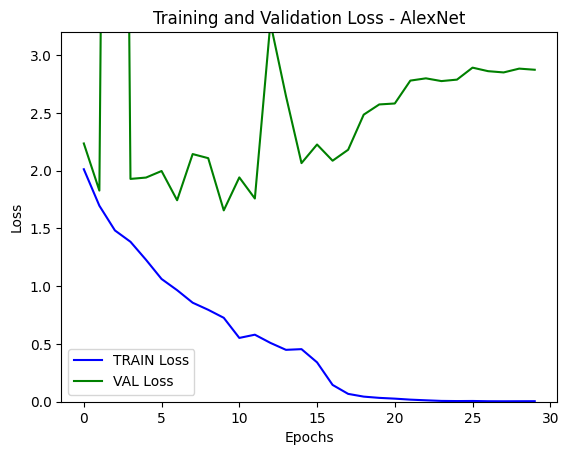

In [ ]:
checkpoint = torch.load('/content/model_alexnet_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'AlexNet', top_y=3.2, bottom_y=0)

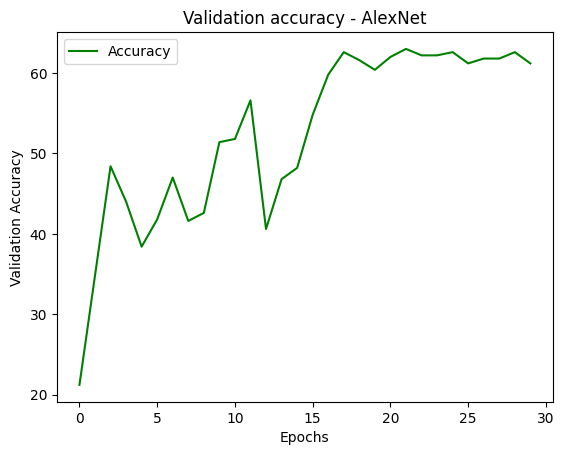

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'AlexNet')

##### AlexNet Model Testing

In [ ]:
alexnet_model = AlexNetwork().to(device)
alexnet_model.load_state_dict(checkpoint['model_state_dict'])

model_testing(alexnet_model)

Test --- total:500, correct:305
Accuracy: 61.0%

Scores for each class:
n01629819 => Precision: 0.8461538461538461, Recall: 0.66, F-Score: 0.7415730337078651
n07583066 => Precision: 0.8372093023255814, Recall: 0.72, F-Score: 0.7741935483870969
n04366367 => Precision: 0.7068965517241379, Recall: 0.82, F-Score: 0.7592592592592593
n07715103 => Precision: 0.5869565217391305, Recall: 0.54, F-Score: 0.5625000000000001
n02364673 => Precision: 0.6097560975609756, Recall: 0.5, F-Score: 0.5494505494505494
n02823428 => Precision: 0.4222222222222222, Recall: 0.38, F-Score: 0.4
n03424325 => Precision: 0.352112676056338, Recall: 0.5, F-Score: 0.4132231404958677
n03617480 => Precision: 0.631578947368421, Recall: 0.48, F-Score: 0.5454545454545454
n07753592 => Precision: 0.5964912280701754, Recall: 0.68, F-Score: 0.6355140186915889
n02509815 => Precision: 0.6612903225806451, Recall: 0.82, F-Score: 0.7321428571428572

Average Precision: 0.6250667715801473, Average Recall: 0.61, Average F-Score: 0.611331

#### VGG Model

In [ ]:
#########################
####    VGG Model    ####
#########################

class VggNet(nn.Module):
  def __init__(self, aux_logits = False):
      super(VggNet, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(4608, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

  def forward(self, image):
    output= self.cnn(image)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

vgg_model = VggNet().to(device)

##### VGG Model Training

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(vgg_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(vgg_model, optimizer, criterion, scheduler, 'vgg_image_classification')

47it [00:17,  2.67it/s]
8it [00:02,  2.76it/s]


Val Progress --- total:500, correct:64
Val accuracy: 12.800%
Epoch [1/30], TRNLoss:2.1850, VALLoss:2.2830, Time:0.34


47it [00:17,  2.73it/s]
8it [00:01,  4.61it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [2/30], TRNLoss:2.0327, VALLoss:5.2047, Time:0.32


47it [00:17,  2.75it/s]
8it [00:01,  4.06it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [3/30], TRNLoss:1.9892, VALLoss:17.8771, Time:0.32


47it [00:17,  2.64it/s]
8it [00:01,  4.57it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [4/30], TRNLoss:1.9105, VALLoss:14.1184, Time:0.33


47it [00:17,  2.75it/s]
8it [00:01,  4.61it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [5/30], TRNLoss:1.8452, VALLoss:23.9170, Time:0.31


47it [00:17,  2.73it/s]
8it [00:02,  3.13it/s]


Val Progress --- total:500, correct:78
Val accuracy: 15.600%
Epoch [6/30], TRNLoss:1.8261, VALLoss:3.4162, Time:0.33


47it [00:17,  2.71it/s]
8it [00:01,  4.53it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch 00007: reducing learning rate of group 0 to 1.5000e-04.
Epoch [7/30], TRNLoss:1.7311, VALLoss:10.7858, Time:0.32


47it [00:17,  2.76it/s]
8it [00:01,  4.50it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [8/30], TRNLoss:1.5504, VALLoss:15.7649, Time:0.31


47it [00:17,  2.62it/s]
8it [00:01,  4.33it/s]


Val Progress --- total:500, correct:121
Val accuracy: 24.200%
Epoch [9/30], TRNLoss:1.4519, VALLoss:3.3678, Time:0.33


47it [00:17,  2.76it/s]
8it [00:01,  4.51it/s]


Val Progress --- total:500, correct:123
Val accuracy: 24.600%
Epoch [10/30], TRNLoss:1.3757, VALLoss:4.4906, Time:0.31


47it [00:17,  2.73it/s]
8it [00:02,  3.19it/s]


Val Progress --- total:500, correct:68
Val accuracy: 13.600%
Epoch [11/30], TRNLoss:1.3375, VALLoss:7.9897, Time:0.33


47it [00:17,  2.68it/s]
8it [00:01,  4.55it/s]


Val Progress --- total:500, correct:72
Val accuracy: 14.400%
Epoch [12/30], TRNLoss:1.2890, VALLoss:9.1037, Time:0.32


47it [00:17,  2.76it/s]
8it [00:01,  4.57it/s]


Val Progress --- total:500, correct:76
Val accuracy: 15.200%
Epoch 00013: reducing learning rate of group 0 to 4.5000e-05.
Epoch [13/30], TRNLoss:1.2045, VALLoss:12.3873, Time:0.31


47it [00:17,  2.65it/s]
8it [00:02,  3.70it/s]


Val Progress --- total:500, correct:111
Val accuracy: 22.200%
Epoch [14/30], TRNLoss:1.0743, VALLoss:3.8390, Time:0.33


47it [00:17,  2.76it/s]
8it [00:01,  4.54it/s]


Val Progress --- total:500, correct:119
Val accuracy: 23.800%
Epoch [15/30], TRNLoss:1.0321, VALLoss:5.6649, Time:0.31


47it [00:17,  2.73it/s]
8it [00:02,  3.68it/s]


Val Progress --- total:500, correct:173
Val accuracy: 34.600%
Epoch [16/30], TRNLoss:1.0006, VALLoss:3.2447, Time:0.32


47it [00:17,  2.66it/s]
8it [00:01,  4.51it/s]


Val Progress --- total:500, correct:98
Val accuracy: 19.600%
Epoch [17/30], TRNLoss:0.9618, VALLoss:7.4457, Time:0.32


47it [00:17,  2.75it/s]
8it [00:01,  4.52it/s]


Val Progress --- total:500, correct:142
Val accuracy: 28.400%
Epoch [18/30], TRNLoss:0.9268, VALLoss:3.5966, Time:0.31


47it [00:17,  2.66it/s]
8it [00:02,  3.21it/s]


Val Progress --- total:500, correct:90
Val accuracy: 18.000%
Epoch 00019: reducing learning rate of group 0 to 1.3500e-05.
Epoch [19/30], TRNLoss:0.8980, VALLoss:7.1547, Time:0.34


47it [00:17,  2.72it/s]
8it [00:01,  4.63it/s]


Val Progress --- total:500, correct:195
Val accuracy: 39.000%
Epoch [20/30], TRNLoss:0.8523, VALLoss:2.4404, Time:0.32


47it [00:17,  2.73it/s]
8it [00:02,  3.99it/s]


Val Progress --- total:500, correct:216
Val accuracy: 43.200%
Epoch [21/30], TRNLoss:0.8036, VALLoss:2.3732, Time:0.32


47it [00:18,  2.60it/s]
8it [00:01,  4.50it/s]


Val Progress --- total:500, correct:143
Val accuracy: 28.600%
Epoch [22/30], TRNLoss:0.8029, VALLoss:4.1542, Time:0.33


47it [00:17,  2.73it/s]
8it [00:01,  4.50it/s]


Val Progress --- total:500, correct:276
Val accuracy: 55.200%
Epoch [23/30], TRNLoss:0.7830, VALLoss:1.3302, Time:0.32


47it [00:17,  2.68it/s]
8it [00:02,  3.12it/s]


Val Progress --- total:500, correct:266
Val accuracy: 53.200%
Epoch [24/30], TRNLoss:0.7701, VALLoss:1.5658, Time:0.34


47it [00:17,  2.72it/s]
8it [00:01,  4.47it/s]


Val Progress --- total:500, correct:224
Val accuracy: 44.800%
Epoch [25/30], TRNLoss:0.7518, VALLoss:1.9764, Time:0.32


47it [00:17,  2.75it/s]
8it [00:01,  4.54it/s]


Val Progress --- total:500, correct:269
Val accuracy: 53.800%
Epoch [26/30], TRNLoss:0.7353, VALLoss:1.4874, Time:0.31


47it [00:17,  2.62it/s]
8it [00:01,  4.55it/s]


Val Progress --- total:500, correct:135
Val accuracy: 27.000%
Epoch [27/30], TRNLoss:0.7098, VALLoss:3.8942, Time:0.33


47it [00:17,  2.75it/s]
8it [00:01,  4.51it/s]


Val Progress --- total:500, correct:199
Val accuracy: 39.800%
Epoch [28/30], TRNLoss:0.7098, VALLoss:2.4942, Time:0.31


47it [00:17,  2.74it/s]
8it [00:02,  3.14it/s]


Val Progress --- total:500, correct:163
Val accuracy: 32.600%
Epoch 00029: reducing learning rate of group 0 to 4.0500e-06.
Epoch [29/30], TRNLoss:0.6868, VALLoss:3.0821, Time:0.33


47it [00:17,  2.70it/s]
8it [00:01,  4.52it/s]


Val Progress --- total:500, correct:297
Val accuracy: 59.400%
Epoch [30/30], TRNLoss:0.6670, VALLoss:1.3364, Time:0.32


##### VGG Model training and validation plots

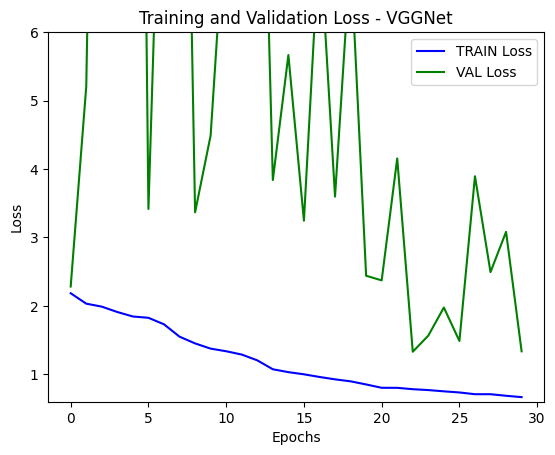

In [ ]:
checkpoint = torch.load('/content/model_vgg_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'VGGNet', top_y=6, bottom_y=0.6)

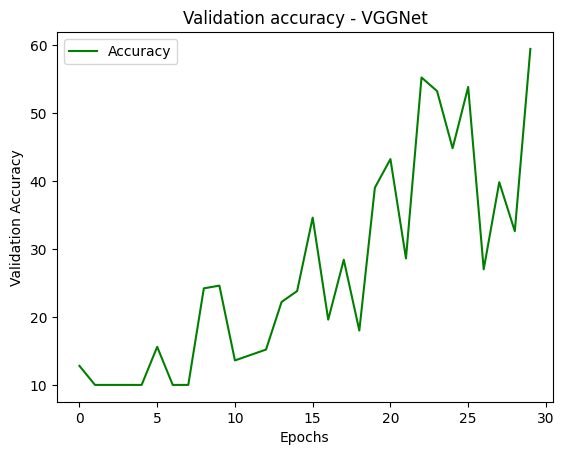

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'VGGNet')

##### VGG Model Testing

In [ ]:
vgg_model = VggNet().to(device)
vgg_model.load_state_dict(checkpoint['model_state_dict'])

model_testing(vgg_model)

Test --- total:500, correct:277
Accuracy: 55.4%

Scores for each class:
n01629819 => Precision: 0.95, Recall: 0.76, F-Score: 0.8444444444444444
n07583066 => Precision: 0.625, Recall: 0.6, F-Score: 0.6122448979591836
n04366367 => Precision: 0.8048780487804879, Recall: 0.66, F-Score: 0.7252747252747254
n07715103 => Precision: 0.5283018867924528, Recall: 0.56, F-Score: 0.5436893203883495
n02364673 => Precision: 0.44642857142857145, Recall: 0.5, F-Score: 0.47169811320754723
n02823428 => Precision: 0.2647058823529412, Recall: 0.18, F-Score: 0.21428571428571427
n03424325 => Precision: 0.42592592592592593, Recall: 0.46, F-Score: 0.4423076923076923
n03617480 => Precision: 0.4657534246575342, Recall: 0.68, F-Score: 0.5528455284552846
n07753592 => Precision: 0.5909090909090909, Recall: 0.52, F-Score: 0.5531914893617023
n02509815 => Precision: 0.543859649122807, Recall: 0.62, F-Score: 0.5794392523364487

Average Precision: 0.5645762479969811, Average Recall: 0.554, Average F-Score: 0.553942117802

### Models Training with Transfer Learning

#### 3x3 Patches Models

##### Baseline Model

In [ ]:
##########################
####     Baseline     ####
##########################

class BaselineModel_3x3(nn.Module):
  def __init__(self, aux_logits = False):
      super(BaselineModel_3x3, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(256, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )

      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward(self, image):
    output= self.cnn(image)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/Models/ContextPrediction/3x3/Baseline/model_baseline.pt', map_location='cuda')

baseline_model = BaselineModel_3x3().to(device)
baseline_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
baseline_model.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

baseline_model = baseline_model.to(device)

###### Baseline Model Traininig

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(baseline_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(baseline_model, optimizer, criterion, scheduler, 'baseline_3x3_image_classification')

47it [00:12,  3.78it/s]
8it [00:01,  5.09it/s]


Val Progress --- total:500, correct:190
Val accuracy: 38.000%
Epoch [1/30], TRNLoss:1.9590, VALLoss:1.7404, Time:0.23


47it [00:12,  3.78it/s]
8it [00:01,  5.03it/s]


Val Progress --- total:500, correct:185
Val accuracy: 37.000%
Epoch [2/30], TRNLoss:1.5898, VALLoss:1.8675, Time:0.23


47it [00:12,  3.63it/s]
8it [00:01,  5.05it/s]


Val Progress --- total:500, correct:159
Val accuracy: 31.800%
Epoch [3/30], TRNLoss:1.4387, VALLoss:2.1266, Time:0.24


47it [00:12,  3.77it/s]
8it [00:01,  5.14it/s]


Val Progress --- total:500, correct:216
Val accuracy: 43.200%
Epoch [4/30], TRNLoss:1.3087, VALLoss:1.7169, Time:0.23


47it [00:12,  3.77it/s]
8it [00:01,  5.22it/s]


Val Progress --- total:500, correct:248
Val accuracy: 49.600%
Epoch [5/30], TRNLoss:1.1633, VALLoss:1.5602, Time:0.23


47it [00:12,  3.80it/s]
8it [00:01,  5.14it/s]


Val Progress --- total:500, correct:262
Val accuracy: 52.400%
Epoch [6/30], TRNLoss:1.0666, VALLoss:1.4894, Time:0.23


47it [00:12,  3.80it/s]
8it [00:01,  5.04it/s]


Val Progress --- total:500, correct:285
Val accuracy: 57.000%
Epoch [7/30], TRNLoss:0.9456, VALLoss:1.4917, Time:0.23


47it [00:12,  3.76it/s]
8it [00:01,  5.06it/s]


Val Progress --- total:500, correct:259
Val accuracy: 51.800%
Epoch [8/30], TRNLoss:0.8101, VALLoss:1.4632, Time:0.23


47it [00:12,  3.76it/s]
8it [00:01,  5.17it/s]


Val Progress --- total:500, correct:237
Val accuracy: 47.400%
Epoch [9/30], TRNLoss:0.6944, VALLoss:2.6065, Time:0.23


47it [00:12,  3.78it/s]
8it [00:01,  5.12it/s]


Val Progress --- total:500, correct:276
Val accuracy: 55.200%
Epoch [10/30], TRNLoss:0.6520, VALLoss:1.9037, Time:0.23


47it [00:12,  3.78it/s]
8it [00:01,  5.16it/s]


Val Progress --- total:500, correct:291
Val accuracy: 58.200%
Epoch [11/30], TRNLoss:0.5438, VALLoss:1.5284, Time:0.23


47it [00:12,  3.75it/s]
8it [00:01,  5.08it/s]


Val Progress --- total:500, correct:254
Val accuracy: 50.800%
Epoch [12/30], TRNLoss:0.4719, VALLoss:2.1147, Time:0.24


47it [00:12,  3.76it/s]
8it [00:01,  4.90it/s]


Val Progress --- total:500, correct:192
Val accuracy: 38.400%
Epoch [13/30], TRNLoss:0.5244, VALLoss:2.4620, Time:0.24


47it [00:12,  3.76it/s]
8it [00:01,  5.04it/s]


Val Progress --- total:500, correct:279
Val accuracy: 55.800%
Epoch 00014: reducing learning rate of group 0 to 1.5000e-04.
Epoch [14/30], TRNLoss:0.6066, VALLoss:1.6953, Time:0.24


47it [00:12,  3.74it/s]
8it [00:01,  5.18it/s]


Val Progress --- total:500, correct:303
Val accuracy: 60.600%
Epoch [15/30], TRNLoss:0.2742, VALLoss:1.7690, Time:0.24


47it [00:12,  3.72it/s]
8it [00:01,  5.13it/s]


Val Progress --- total:500, correct:307
Val accuracy: 61.400%
Epoch [16/30], TRNLoss:0.1281, VALLoss:1.9295, Time:0.24


47it [00:12,  3.75it/s]
8it [00:01,  5.08it/s]


Val Progress --- total:500, correct:297
Val accuracy: 59.400%
Epoch [17/30], TRNLoss:0.0918, VALLoss:2.2126, Time:0.24


47it [00:12,  3.80it/s]
8it [00:01,  4.99it/s]


Val Progress --- total:500, correct:300
Val accuracy: 60.000%
Epoch [18/30], TRNLoss:0.0624, VALLoss:2.4818, Time:0.23


47it [00:12,  3.77it/s]
8it [00:01,  5.08it/s]


Val Progress --- total:500, correct:295
Val accuracy: 59.000%
Epoch [19/30], TRNLoss:0.0469, VALLoss:2.6791, Time:0.23


47it [00:12,  3.75it/s]
8it [00:01,  5.12it/s]


Val Progress --- total:500, correct:302
Val accuracy: 60.400%
Epoch 00020: reducing learning rate of group 0 to 4.5000e-05.
Epoch [20/30], TRNLoss:0.0587, VALLoss:2.6987, Time:0.24


47it [00:12,  3.76it/s]
8it [00:01,  5.10it/s]


Val Progress --- total:500, correct:303
Val accuracy: 60.600%
Epoch [21/30], TRNLoss:0.0304, VALLoss:2.6844, Time:0.23


47it [00:12,  3.80it/s]
8it [00:01,  5.02it/s]


Val Progress --- total:500, correct:305
Val accuracy: 61.000%
Epoch [22/30], TRNLoss:0.0178, VALLoss:2.6804, Time:0.23


47it [00:12,  3.79it/s]
8it [00:01,  4.96it/s]


Val Progress --- total:500, correct:308
Val accuracy: 61.600%
Epoch [23/30], TRNLoss:0.0166, VALLoss:2.7454, Time:0.23


47it [00:12,  3.76it/s]
8it [00:01,  4.54it/s]


Val Progress --- total:500, correct:307
Val accuracy: 61.400%
Epoch [24/30], TRNLoss:0.0145, VALLoss:2.7985, Time:0.24


47it [00:12,  3.82it/s]
8it [00:01,  4.37it/s]


Val Progress --- total:500, correct:303
Val accuracy: 60.600%
Epoch [25/30], TRNLoss:0.0113, VALLoss:2.7985, Time:0.24


47it [00:12,  3.83it/s]
8it [00:01,  4.25it/s]


Val Progress --- total:500, correct:302
Val accuracy: 60.400%
Epoch 00026: reducing learning rate of group 0 to 1.3500e-05.
Epoch [26/30], TRNLoss:0.0090, VALLoss:2.9202, Time:0.24


47it [00:12,  3.86it/s]
8it [00:01,  4.15it/s]


Val Progress --- total:500, correct:308
Val accuracy: 61.600%
Epoch [27/30], TRNLoss:0.0088, VALLoss:2.8835, Time:0.24


47it [00:12,  3.92it/s]
8it [00:01,  4.02it/s]


Val Progress --- total:500, correct:304
Val accuracy: 60.800%
Epoch [28/30], TRNLoss:0.0087, VALLoss:2.8999, Time:0.23


47it [00:12,  3.89it/s]
8it [00:02,  3.93it/s]


Val Progress --- total:500, correct:304
Val accuracy: 60.800%
Epoch [29/30], TRNLoss:0.0070, VALLoss:2.9300, Time:0.24


47it [00:12,  3.88it/s]
8it [00:02,  3.70it/s]


Val Progress --- total:500, correct:304
Val accuracy: 60.800%
Epoch [30/30], TRNLoss:0.0068, VALLoss:2.8841, Time:0.24


###### Baseline Model training and validation plots

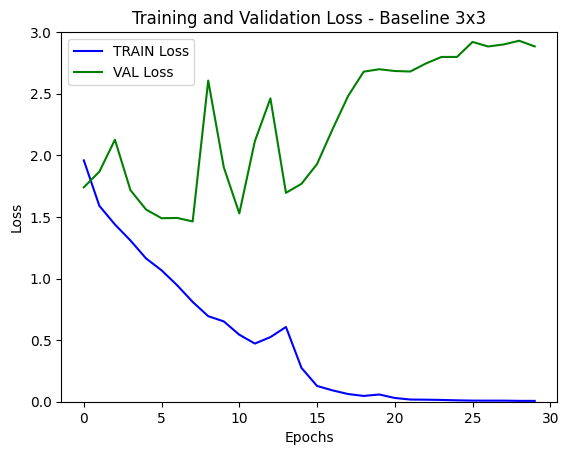

In [ ]:
checkpoint = torch.load('/content/model_baseline_3x3_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'Baseline 3x3', top_y=3, bottom_y=0)

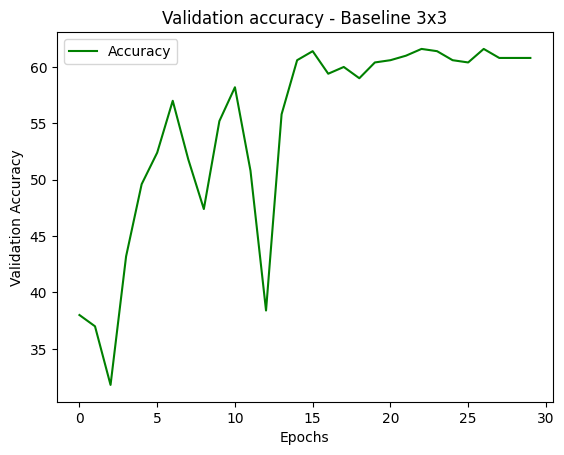

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'Baseline 3x3')

###### Baseline Model Testing

In [ ]:
model_testing(baseline_model)

Test --- total:500, correct:312
Accuracy: 62.4%

Scores for each class:
n01629819 => Precision: 0.7358490566037735, Recall: 0.78, F-Score: 0.7572815533980584
n07583066 => Precision: 0.7551020408163265, Recall: 0.74, F-Score: 0.7474747474747474
n04366367 => Precision: 0.7592592592592593, Recall: 0.82, F-Score: 0.7884615384615384
n07715103 => Precision: 0.6, Recall: 0.6, F-Score: 0.6
n02364673 => Precision: 0.5853658536585366, Recall: 0.48, F-Score: 0.5274725274725274
n02823428 => Precision: 0.43478260869565216, Recall: 0.4, F-Score: 0.41666666666666663
n03424325 => Precision: 0.35443037974683544, Recall: 0.56, F-Score: 0.434108527131783
n03617480 => Precision: 0.78125, Recall: 0.5, F-Score: 0.6097560975609756
n07753592 => Precision: 0.6296296296296297, Recall: 0.68, F-Score: 0.6538461538461539
n02509815 => Precision: 0.8095238095238095, Recall: 0.68, F-Score: 0.7391304347826089

Average Precision: 0.6445192637933823, Average Recall: 0.6239999999999999, Average F-Score: 0.627419824679506

##### AlexNet Model

In [ ]:
#########################
####  AlexNet Model  ####
#########################

class AlexNetwork_3x3(nn.Module):
  def __init__(self, aux_logits = False):
      super(AlexNetwork_3x3, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(256, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward(self, image):
    output= self.cnn(image)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/Models/ContextPrediction/3x3/AlexNet/model_alexnet.pt', map_location='cuda')

alexnet_model = AlexNetwork_3x3().to(device)
alexnet_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
alexnet_model.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

alexnet_model = alexnet_model.to(device)

###### AlexNet Model Traininig

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(alexnet_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(alexnet_model, optimizer, criterion, scheduler, 'alexnet_3x3_image_classification')

47it [00:12,  3.90it/s]
8it [00:02,  2.76it/s]


Val Progress --- total:500, correct:135
Val accuracy: 27.000%
Epoch [1/30], TRNLoss:2.1475, VALLoss:2.0028, Time:0.25


47it [00:12,  3.85it/s]
8it [00:01,  4.08it/s]


Val Progress --- total:500, correct:166
Val accuracy: 33.200%
Epoch [2/30], TRNLoss:1.8161, VALLoss:1.8984, Time:0.24


47it [00:12,  3.80it/s]
8it [00:01,  4.45it/s]


Val Progress --- total:500, correct:177
Val accuracy: 35.400%
Epoch [3/30], TRNLoss:1.6788, VALLoss:1.7598, Time:0.24


47it [00:12,  3.79it/s]
8it [00:01,  4.72it/s]


Val Progress --- total:500, correct:182
Val accuracy: 36.400%
Epoch [4/30], TRNLoss:1.4461, VALLoss:1.8641, Time:0.24


47it [00:12,  3.76it/s]
8it [00:01,  5.14it/s]


Val Progress --- total:500, correct:194
Val accuracy: 38.800%
Epoch [5/30], TRNLoss:1.3527, VALLoss:2.0184, Time:0.23


47it [00:12,  3.77it/s]
8it [00:01,  5.10it/s]


Val Progress --- total:500, correct:235
Val accuracy: 47.000%
Epoch [6/30], TRNLoss:1.2138, VALLoss:1.6618, Time:0.23


47it [00:12,  3.76it/s]
8it [00:01,  5.06it/s]


Val Progress --- total:500, correct:236
Val accuracy: 47.200%
Epoch [7/30], TRNLoss:1.0739, VALLoss:1.8135, Time:0.24


47it [00:12,  3.74it/s]
8it [00:01,  5.12it/s]


Val Progress --- total:500, correct:217
Val accuracy: 43.400%
Epoch [8/30], TRNLoss:1.0179, VALLoss:2.3594, Time:0.24


47it [00:12,  3.73it/s]
8it [00:01,  5.11it/s]


Val Progress --- total:500, correct:276
Val accuracy: 55.200%
Epoch [9/30], TRNLoss:0.8684, VALLoss:28.9355, Time:0.24


47it [00:12,  3.76it/s]
8it [00:01,  5.03it/s]


Val Progress --- total:500, correct:137
Val accuracy: 27.400%
Epoch [10/30], TRNLoss:0.8045, VALLoss:4.5747, Time:0.24


47it [00:12,  3.74it/s]
8it [00:01,  5.12it/s]


Val Progress --- total:500, correct:217
Val accuracy: 43.400%
Epoch [11/30], TRNLoss:0.8513, VALLoss:2.2403, Time:0.24


47it [00:12,  3.77it/s]
8it [00:01,  5.22it/s]


Val Progress --- total:500, correct:201
Val accuracy: 40.200%
Epoch 00012: reducing learning rate of group 0 to 1.5000e-04.
Epoch [12/30], TRNLoss:0.6600, VALLoss:2.9117, Time:0.23


47it [00:12,  3.72it/s]
8it [00:01,  5.14it/s]


Val Progress --- total:500, correct:278
Val accuracy: 55.600%
Epoch [13/30], TRNLoss:0.4277, VALLoss:1.8506, Time:0.24


47it [00:12,  3.72it/s]
8it [00:01,  5.21it/s]


Val Progress --- total:500, correct:236
Val accuracy: 47.200%
Epoch [14/30], TRNLoss:0.2769, VALLoss:2.4729, Time:0.24


47it [00:12,  3.73it/s]
8it [00:01,  5.02it/s]


Val Progress --- total:500, correct:272
Val accuracy: 54.400%
Epoch [15/30], TRNLoss:0.2373, VALLoss:2.2017, Time:0.24


47it [00:12,  3.76it/s]
8it [00:01,  5.15it/s]


Val Progress --- total:500, correct:269
Val accuracy: 53.800%
Epoch [16/30], TRNLoss:0.1891, VALLoss:2.6457, Time:0.23


47it [00:12,  3.76it/s]
8it [00:01,  4.99it/s]


Val Progress --- total:500, correct:261
Val accuracy: 52.200%
Epoch [17/30], TRNLoss:0.1586, VALLoss:2.9917, Time:0.24


47it [00:12,  3.75it/s]
8it [00:01,  5.16it/s]


Val Progress --- total:500, correct:280
Val accuracy: 56.000%
Epoch 00018: reducing learning rate of group 0 to 4.5000e-05.
Epoch [18/30], TRNLoss:0.1507, VALLoss:2.6454, Time:0.24


47it [00:12,  3.73it/s]
8it [00:01,  5.14it/s]


Val Progress --- total:500, correct:272
Val accuracy: 54.400%
Epoch [19/30], TRNLoss:0.0929, VALLoss:2.6549, Time:0.24


47it [00:12,  3.74it/s]
8it [00:01,  5.14it/s]


Val Progress --- total:500, correct:272
Val accuracy: 54.400%
Epoch [20/30], TRNLoss:0.0583, VALLoss:2.6932, Time:0.24


47it [00:12,  3.75it/s]
8it [00:01,  5.16it/s]


Val Progress --- total:500, correct:271
Val accuracy: 54.200%
Epoch [21/30], TRNLoss:0.0391, VALLoss:2.9010, Time:0.23


47it [00:12,  3.74it/s]
8it [00:01,  5.05it/s]


Val Progress --- total:500, correct:274
Val accuracy: 54.800%
Epoch [22/30], TRNLoss:0.0389, VALLoss:3.0096, Time:0.24


47it [00:12,  3.75it/s]
8it [00:01,  5.16it/s]


Val Progress --- total:500, correct:274
Val accuracy: 54.800%
Epoch [23/30], TRNLoss:0.0390, VALLoss:3.2416, Time:0.23


47it [00:12,  3.72it/s]
8it [00:01,  5.07it/s]


Val Progress --- total:500, correct:269
Val accuracy: 53.800%
Epoch 00024: reducing learning rate of group 0 to 1.3500e-05.
Epoch [24/30], TRNLoss:0.0293, VALLoss:3.1470, Time:0.24


47it [00:12,  3.74it/s]
8it [00:01,  5.07it/s]


Val Progress --- total:500, correct:273
Val accuracy: 54.600%
Epoch [25/30], TRNLoss:0.0247, VALLoss:3.2409, Time:0.24


47it [00:12,  3.76it/s]
8it [00:01,  5.06it/s]


Val Progress --- total:500, correct:271
Val accuracy: 54.200%
Epoch [26/30], TRNLoss:0.0217, VALLoss:3.2572, Time:0.23


47it [00:12,  3.74it/s]
8it [00:01,  5.10it/s]


Val Progress --- total:500, correct:269
Val accuracy: 53.800%
Epoch [27/30], TRNLoss:0.0216, VALLoss:3.2587, Time:0.24


47it [00:12,  3.71it/s]
8it [00:01,  5.21it/s]


Val Progress --- total:500, correct:272
Val accuracy: 54.400%
Epoch [28/30], TRNLoss:0.0234, VALLoss:3.2942, Time:0.24


47it [00:12,  3.74it/s]
8it [00:01,  5.15it/s]


Val Progress --- total:500, correct:271
Val accuracy: 54.200%
Epoch [29/30], TRNLoss:0.0190, VALLoss:3.3291, Time:0.24


47it [00:12,  3.76it/s]
8it [00:01,  5.16it/s]


Val Progress --- total:500, correct:272
Val accuracy: 54.400%
Epoch 00030: reducing learning rate of group 0 to 4.0500e-06.
Epoch [30/30], TRNLoss:0.0157, VALLoss:3.3301, Time:0.23


###### AlexNet Model training and validation plots

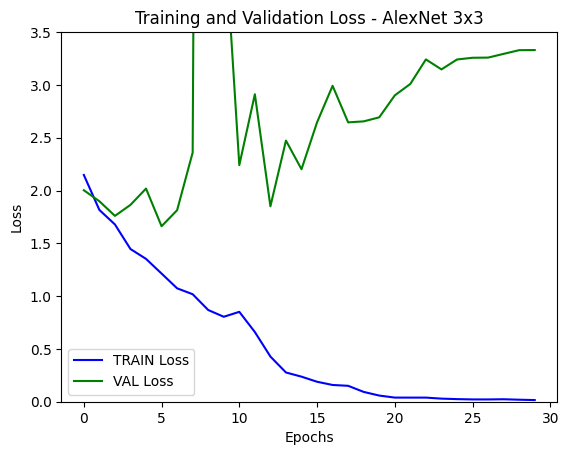

In [ ]:
checkpoint = torch.load('/content/model_alexnet_3x3_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'AlexNet 3x3', top_y=3.5, bottom_y=0)

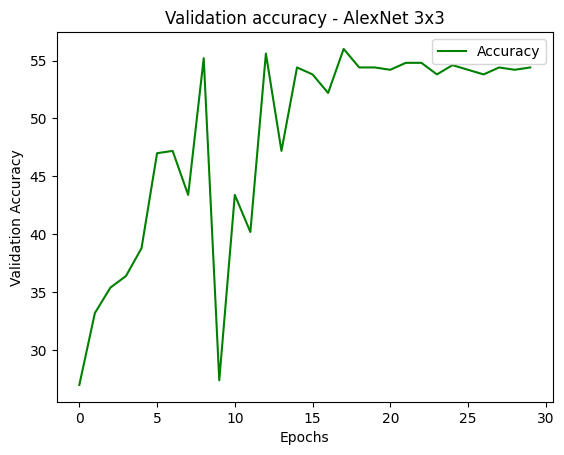

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'AlexNet 3x3')

###### AlexNet Model Testing

In [ ]:
model_testing(alexnet_model)

Test --- total:500, correct:268
Accuracy: 53.6%

Scores for each class:
n01629819 => Precision: 0.7441860465116279, Recall: 0.64, F-Score: 0.6881720430107526
n07583066 => Precision: 0.6486486486486487, Recall: 0.48, F-Score: 0.5517241379310345
n04366367 => Precision: 0.7142857142857143, Recall: 0.7, F-Score: 0.7070707070707072
n07715103 => Precision: 0.46296296296296297, Recall: 0.5, F-Score: 0.4807692307692307
n02364673 => Precision: 0.49019607843137253, Recall: 0.5, F-Score: 0.495049504950495
n02823428 => Precision: 0.3404255319148936, Recall: 0.32, F-Score: 0.32989690721649484
n03424325 => Precision: 0.3275862068965517, Recall: 0.38, F-Score: 0.35185185185185186
n03617480 => Precision: 0.4426229508196721, Recall: 0.54, F-Score: 0.48648648648648646
n07753592 => Precision: 0.5660377358490566, Recall: 0.6, F-Score: 0.5825242718446602
n02509815 => Precision: 0.7446808510638298, Recall: 0.7, F-Score: 0.7216494845360825

Average Precision: 0.5481632727384331, Average Recall: 0.536, Averag

##### VGG Model

In [ ]:
#########################
####    VGG Model    ####
#########################

class VggNet_3x3(nn.Module):
  def __init__(self, aux_logits = False):
      super(VggNet_3x3, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(4608, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward(self, image):
    output= self.cnn(image)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/Models/ContextPrediction/3x3/VGG/model_VGGNet.pt', map_location='cuda')

vgg_model = VggNet_3x3().to(device)
vgg_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
vgg_model.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

vgg_model = vgg_model.to(device)

###### VGG Model Traininig

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(vgg_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(vgg_model, optimizer, criterion, scheduler, 'VGGNet_3x3_image_classification')

47it [00:17,  2.71it/s]
8it [00:01,  4.52it/s]


Val Progress --- total:500, correct:66
Val accuracy: 13.200%
Epoch [1/30], TRNLoss:2.1679, VALLoss:10.0528, Time:0.32


47it [00:17,  2.68it/s]
8it [00:02,  3.11it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [2/30], TRNLoss:1.9880, VALLoss:8.2299, Time:0.34


47it [00:17,  2.71it/s]
8it [00:01,  4.52it/s]


Val Progress --- total:500, correct:77
Val accuracy: 15.400%
Epoch [3/30], TRNLoss:1.9415, VALLoss:8.7448, Time:0.32


47it [00:17,  2.74it/s]
8it [00:01,  4.59it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [4/30], TRNLoss:1.8913, VALLoss:20.9284, Time:0.32


47it [00:18,  2.60it/s]
8it [00:01,  4.38it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [5/30], TRNLoss:1.7693, VALLoss:75.8688, Time:0.33


47it [00:17,  2.72it/s]
8it [00:01,  4.46it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [6/30], TRNLoss:1.7081, VALLoss:104.9706, Time:0.32


47it [00:17,  2.73it/s]
8it [00:02,  3.13it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [7/30], TRNLoss:1.6581, VALLoss:32.9432, Time:0.33


47it [00:17,  2.71it/s]
8it [00:01,  4.60it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch 00008: reducing learning rate of group 0 to 1.5000e-04.
Epoch [8/30], TRNLoss:1.5932, VALLoss:29.9430, Time:0.32


47it [00:17,  2.73it/s]
8it [00:01,  4.53it/s]


Val Progress --- total:500, correct:78
Val accuracy: 15.600%
Epoch [9/30], TRNLoss:1.4069, VALLoss:10.1706, Time:0.32


47it [00:17,  2.64it/s]
8it [00:02,  3.95it/s]


Val Progress --- total:500, correct:95
Val accuracy: 19.000%
Epoch [10/30], TRNLoss:1.3202, VALLoss:11.3352, Time:0.33


47it [00:17,  2.74it/s]
8it [00:01,  4.47it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [11/30], TRNLoss:1.2967, VALLoss:30.2636, Time:0.32


47it [00:17,  2.74it/s]
8it [00:02,  3.40it/s]


Val Progress --- total:500, correct:64
Val accuracy: 12.800%
Epoch [12/30], TRNLoss:1.2523, VALLoss:8.1564, Time:0.33


47it [00:17,  2.63it/s]
8it [00:01,  4.59it/s]


Val Progress --- total:500, correct:83
Val accuracy: 16.600%
Epoch [13/30], TRNLoss:1.1723, VALLoss:9.9004, Time:0.33


47it [00:17,  2.74it/s]
8it [00:01,  4.67it/s]


Val Progress --- total:500, correct:61
Val accuracy: 12.200%
Epoch [14/30], TRNLoss:1.1330, VALLoss:21.7135, Time:0.32


47it [00:17,  2.64it/s]
8it [00:02,  3.55it/s]


Val Progress --- total:500, correct:59
Val accuracy: 11.800%
Epoch [15/30], TRNLoss:1.1301, VALLoss:21.7990, Time:0.33


47it [00:17,  2.74it/s]
8it [00:01,  4.47it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [16/30], TRNLoss:1.0685, VALLoss:18.5689, Time:0.32


47it [00:17,  2.72it/s]
8it [00:02,  3.81it/s]


Val Progress --- total:500, correct:54
Val accuracy: 10.800%
Epoch [17/30], TRNLoss:1.0044, VALLoss:9.8212, Time:0.32


47it [00:17,  2.65it/s]
8it [00:01,  4.57it/s]


Val Progress --- total:500, correct:81
Val accuracy: 16.200%
Epoch 00018: reducing learning rate of group 0 to 4.5000e-05.
Epoch [18/30], TRNLoss:1.0119, VALLoss:10.6088, Time:0.33


47it [00:17,  2.75it/s]
8it [00:01,  4.53it/s]


Val Progress --- total:500, correct:75
Val accuracy: 15.000%
Epoch [19/30], TRNLoss:0.8503, VALLoss:7.9461, Time:0.31


47it [00:17,  2.66it/s]
8it [00:02,  3.15it/s]


Val Progress --- total:500, correct:119
Val accuracy: 23.800%
Epoch [20/30], TRNLoss:0.8073, VALLoss:5.5426, Time:0.34


47it [00:17,  2.75it/s]
8it [00:01,  4.62it/s]


Val Progress --- total:500, correct:108
Val accuracy: 21.600%
Epoch [21/30], TRNLoss:0.7641, VALLoss:5.3602, Time:0.31


47it [00:17,  2.74it/s]
8it [00:01,  4.26it/s]


Val Progress --- total:500, correct:75
Val accuracy: 15.000%
Epoch [22/30], TRNLoss:0.7474, VALLoss:6.5915, Time:0.32


47it [00:17,  2.62it/s]
8it [00:01,  4.62it/s]


Val Progress --- total:500, correct:87
Val accuracy: 17.400%
Epoch [23/30], TRNLoss:0.7208, VALLoss:9.2782, Time:0.33


47it [00:17,  2.75it/s]
8it [00:01,  4.61it/s]


Val Progress --- total:500, correct:87
Val accuracy: 17.400%
Epoch [24/30], TRNLoss:0.7095, VALLoss:8.5569, Time:0.31


47it [00:17,  2.73it/s]
8it [00:02,  3.15it/s]


Val Progress --- total:500, correct:129
Val accuracy: 25.800%
Epoch [25/30], TRNLoss:0.6666, VALLoss:5.9304, Time:0.33


47it [00:17,  2.71it/s]
8it [00:01,  4.53it/s]


Val Progress --- total:500, correct:74
Val accuracy: 14.800%
Epoch [26/30], TRNLoss:0.6691, VALLoss:17.3507, Time:0.32


47it [00:17,  2.76it/s]
8it [00:01,  4.58it/s]


Val Progress --- total:500, correct:114
Val accuracy: 22.800%
Epoch 00027: reducing learning rate of group 0 to 1.3500e-05.
Epoch [27/30], TRNLoss:0.6393, VALLoss:7.6429, Time:0.31


47it [00:17,  2.63it/s]
8it [00:01,  4.00it/s]


Val Progress --- total:500, correct:291
Val accuracy: 58.200%
Epoch [28/30], TRNLoss:0.5849, VALLoss:1.5558, Time:0.33


47it [00:17,  2.76it/s]
8it [00:01,  4.51it/s]


Val Progress --- total:500, correct:230
Val accuracy: 46.000%
Epoch [29/30], TRNLoss:0.5433, VALLoss:2.1535, Time:0.31


47it [00:17,  2.75it/s]
8it [00:02,  3.44it/s]


Val Progress --- total:500, correct:244
Val accuracy: 48.800%
Epoch [30/30], TRNLoss:0.5429, VALLoss:2.1041, Time:0.32


###### VGG Model training and validation plots

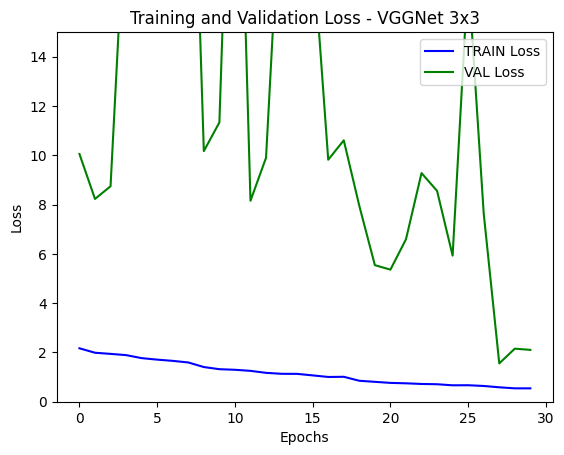

In [ ]:
checkpoint = torch.load('/content/model_VGGNet_3x3_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'VGGNet 3x3', top_y=15, bottom_y=0)

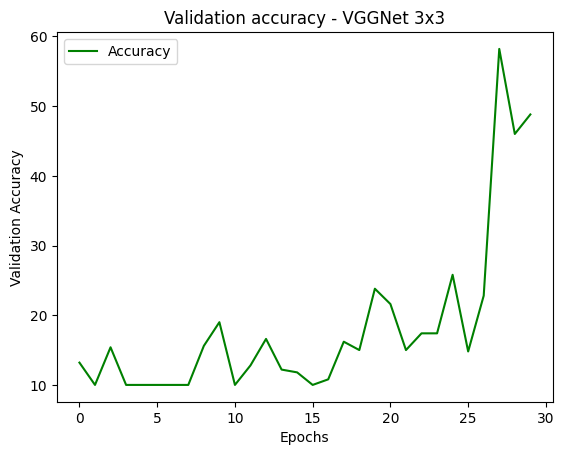

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'VGGNet 3x3')

###### VGG Model Testing

In [ ]:
model_testing(vgg_model)

Test --- total:500, correct:233
Accuracy: 46.6%

Scores for each class:
n01629819 => Precision: 0.95, Recall: 0.76, F-Score: 0.8444444444444444
n07583066 => Precision: 0.5609756097560976, Recall: 0.46, F-Score: 0.5054945054945056
n04366367 => Precision: 0.31297709923664124, Recall: 0.82, F-Score: 0.4530386740331492
n07715103 => Precision: 0.5245901639344263, Recall: 0.64, F-Score: 0.5765765765765766
n02364673 => Precision: 0.5652173913043478, Recall: 0.26, F-Score: 0.3561643835616438
n02823428 => Precision: 0.34545454545454546, Recall: 0.38, F-Score: 0.3619047619047619
n03424325 => Precision: 0.45454545454545453, Recall: 0.1, F-Score: 0.16393442622950818
n03617480 => Precision: 0.47058823529411764, Recall: 0.16, F-Score: 0.23880597014925375
n07753592 => Precision: 0.37962962962962965, Recall: 0.82, F-Score: 0.5189873417721519
n02509815 => Precision: 1.0, Recall: 0.26, F-Score: 0.41269841269841273

Average Precision: 0.556397812915526, Average Recall: 0.4659999999999999, Average F-Score

#### 5x5 Patches Models

##### Baseline Model

In [ ]:
##########################
####     Baseline     ####
##########################

class BaselineModel_5x5(nn.Module):
  def __init__(self, aux_logits = False):
      super(BaselineModel_5x5, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(256, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )

      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 24)
      )

  def forward(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/Models/ContextPrediction/5x5/Baseline/model_baseline_5x5.pt', map_location='cuda')

baseline_model = BaselineModel_5x5().to(device)
baseline_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
baseline_model.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

baseline_model = baseline_model.to(device)

###### Baseline Model Traininig

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(baseline_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(baseline_model, optimizer, criterion, scheduler, 'baseline_5x5_image_classification')

47it [00:26,  1.75it/s]
8it [00:02,  3.68it/s]


Val Progress --- total:500, correct:102
Val accuracy: 20.400%
Epoch [1/30], TRNLoss:2.1531, VALLoss:2.1357, Time:0.49


47it [00:13,  3.52it/s]
8it [00:01,  4.71it/s]


Val Progress --- total:500, correct:149
Val accuracy: 29.800%
Epoch [2/30], TRNLoss:1.8848, VALLoss:1.9621, Time:0.25


47it [00:13,  3.50it/s]
8it [00:01,  4.69it/s]


Val Progress --- total:500, correct:148
Val accuracy: 29.600%
Epoch [3/30], TRNLoss:1.7234, VALLoss:1.9482, Time:0.25


47it [00:13,  3.49it/s]
8it [00:01,  4.68it/s]


Val Progress --- total:500, correct:186
Val accuracy: 37.200%
Epoch [4/30], TRNLoss:1.5844, VALLoss:1.8202, Time:0.25


47it [00:13,  3.50it/s]
8it [00:01,  4.76it/s]


Val Progress --- total:500, correct:216
Val accuracy: 43.200%
Epoch [5/30], TRNLoss:1.4816, VALLoss:1.6463, Time:0.25


47it [00:13,  3.53it/s]
8it [00:02,  3.64it/s]


Val Progress --- total:500, correct:177
Val accuracy: 35.400%
Epoch [6/30], TRNLoss:1.3727, VALLoss:2.1860, Time:0.26


47it [00:13,  3.52it/s]
8it [00:01,  4.69it/s]


Val Progress --- total:500, correct:117
Val accuracy: 23.400%
Epoch [7/30], TRNLoss:1.4626, VALLoss:2.1782, Time:0.25


47it [00:13,  3.50it/s]
8it [00:01,  4.68it/s]


Val Progress --- total:500, correct:203
Val accuracy: 40.600%
Epoch [8/30], TRNLoss:1.4942, VALLoss:1.7201, Time:0.25


47it [00:13,  3.52it/s]
8it [00:01,  4.71it/s]


Val Progress --- total:500, correct:193
Val accuracy: 38.600%
Epoch [9/30], TRNLoss:1.2219, VALLoss:2.0677, Time:0.25


47it [00:13,  3.53it/s]
8it [00:01,  4.73it/s]


Val Progress --- total:500, correct:187
Val accuracy: 37.400%
Epoch [10/30], TRNLoss:1.1685, VALLoss:2.0668, Time:0.25


47it [00:13,  3.52it/s]
8it [00:01,  4.49it/s]


Val Progress --- total:500, correct:187
Val accuracy: 37.400%
Epoch 00011: reducing learning rate of group 0 to 1.5000e-04.
Epoch [11/30], TRNLoss:1.0046, VALLoss:1.9340, Time:0.25


47it [00:13,  3.54it/s]
8it [00:02,  3.66it/s]


Val Progress --- total:500, correct:246
Val accuracy: 49.200%
Epoch [12/30], TRNLoss:0.7347, VALLoss:1.9970, Time:0.26


47it [00:12,  3.68it/s]
8it [00:02,  3.15it/s]


Val Progress --- total:500, correct:230
Val accuracy: 46.000%
Epoch [13/30], TRNLoss:0.5621, VALLoss:2.3022, Time:0.26


47it [00:12,  3.63it/s]
8it [00:02,  3.17it/s]


Val Progress --- total:500, correct:235
Val accuracy: 47.000%
Epoch [14/30], TRNLoss:0.4688, VALLoss:2.3867, Time:0.26


47it [00:12,  3.65it/s]
8it [00:02,  3.50it/s]


Val Progress --- total:500, correct:243
Val accuracy: 48.600%
Epoch [15/30], TRNLoss:0.3986, VALLoss:2.6394, Time:0.25


47it [00:13,  3.43it/s]
8it [00:04,  1.86it/s]


Val Progress --- total:500, correct:240
Val accuracy: 48.000%
Epoch [16/30], TRNLoss:0.3293, VALLoss:2.7010, Time:0.30


47it [00:16,  2.85it/s]
8it [00:01,  4.75it/s]


Val Progress --- total:500, correct:226
Val accuracy: 45.200%
Epoch 00017: reducing learning rate of group 0 to 4.5000e-05.
Epoch [17/30], TRNLoss:0.2932, VALLoss:3.3054, Time:0.30


47it [00:13,  3.54it/s]
8it [00:01,  4.78it/s]


Val Progress --- total:500, correct:234
Val accuracy: 46.800%
Epoch [18/30], TRNLoss:0.1977, VALLoss:3.0923, Time:0.25


47it [00:13,  3.41it/s]
8it [00:01,  4.70it/s]


Val Progress --- total:500, correct:230
Val accuracy: 46.000%
Epoch [19/30], TRNLoss:0.1569, VALLoss:3.3561, Time:0.26


47it [00:21,  2.23it/s]
8it [00:01,  4.21it/s]


Val Progress --- total:500, correct:243
Val accuracy: 48.600%
Epoch [20/30], TRNLoss:0.1299, VALLoss:3.3661, Time:0.38


47it [00:13,  3.37it/s]
8it [00:01,  4.81it/s]


Val Progress --- total:500, correct:223
Val accuracy: 44.600%
Epoch [21/30], TRNLoss:0.1145, VALLoss:3.5694, Time:0.26


47it [00:16,  2.85it/s]
8it [00:01,  4.75it/s]


Val Progress --- total:500, correct:227
Val accuracy: 45.400%
Epoch [22/30], TRNLoss:0.1006, VALLoss:3.8599, Time:0.30


47it [00:14,  3.21it/s]
8it [00:02,  3.96it/s]


Val Progress --- total:500, correct:226
Val accuracy: 45.200%
Epoch 00023: reducing learning rate of group 0 to 1.3500e-05.
Epoch [23/30], TRNLoss:0.0897, VALLoss:3.7436, Time:0.28


47it [00:16,  2.91it/s]
8it [00:02,  3.72it/s]


Val Progress --- total:500, correct:222
Val accuracy: 44.400%
Epoch [24/30], TRNLoss:0.0763, VALLoss:3.8491, Time:0.31


47it [00:15,  2.94it/s]
8it [00:01,  4.22it/s]


Val Progress --- total:500, correct:235
Val accuracy: 47.000%
Epoch [25/30], TRNLoss:0.0769, VALLoss:3.8461, Time:0.30


47it [00:15,  3.09it/s]
8it [00:01,  4.68it/s]


Val Progress --- total:500, correct:230
Val accuracy: 46.000%
Epoch [26/30], TRNLoss:0.0629, VALLoss:3.9878, Time:0.28


47it [00:16,  2.81it/s]
8it [00:05,  1.41it/s]


Val Progress --- total:500, correct:231
Val accuracy: 46.200%
Epoch [27/30], TRNLoss:0.0586, VALLoss:3.9284, Time:0.37


47it [00:13,  3.58it/s]
8it [00:03,  2.59it/s]


Val Progress --- total:500, correct:225
Val accuracy: 45.000%
Epoch [28/30], TRNLoss:0.0543, VALLoss:4.0102, Time:0.27


47it [00:17,  2.70it/s]
8it [00:01,  4.71it/s]


Val Progress --- total:500, correct:227
Val accuracy: 45.400%
Epoch 00029: reducing learning rate of group 0 to 4.0500e-06.
Epoch [29/30], TRNLoss:0.0531, VALLoss:4.1263, Time:0.32


47it [00:14,  3.33it/s]
8it [00:01,  4.82it/s]


Val Progress --- total:500, correct:228
Val accuracy: 45.600%
Epoch [30/30], TRNLoss:0.0451, VALLoss:4.0389, Time:0.26


###### Baseline Model training and validation plots

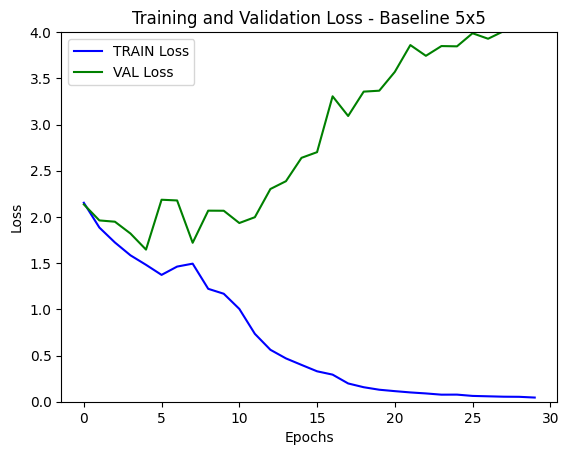

In [ ]:
checkpoint = torch.load('/content/model_baseline_5x5_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'Baseline 5x5', top_y=4, bottom_y=0)

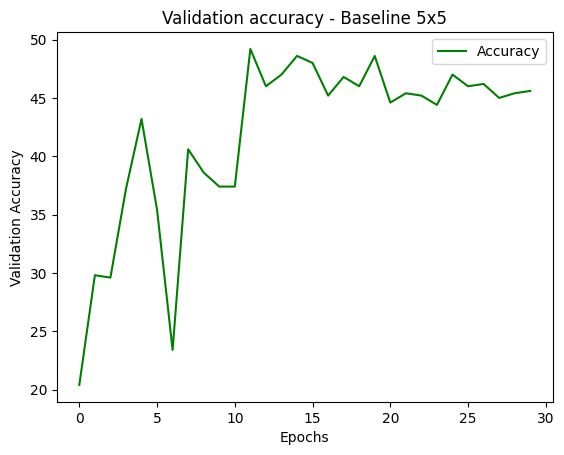

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'Baseline 5x5')

###### Baseline Model Testing

In [ ]:
model_testing(baseline_model)

Test --- total:500, correct:231
Accuracy: 46.2%

Scores for each class:
n02504458 => Precision: 0.574468085106383, Recall: 0.54, F-Score: 0.5567010309278351
n02669723 => Precision: 0.5535714285714286, Recall: 0.62, F-Score: 0.5849056603773586
n03400231 => Precision: 0.5476190476190477, Recall: 0.46, F-Score: 0.5000000000000001
n04074963 => Precision: 0.2708333333333333, Recall: 0.26, F-Score: 0.2653061224489796
n03770439 => Precision: 0.5, Recall: 0.48, F-Score: 0.4897959183673469
n02094433 => Precision: 0.4166666666666667, Recall: 0.5, F-Score: 0.45454545454545453
n04376876 => Precision: 0.20454545454545456, Recall: 0.18, F-Score: 0.1914893617021277
n04417672 => Precision: 0.58, Recall: 0.58, F-Score: 0.58
n07614500 => Precision: 0.425531914893617, Recall: 0.4, F-Score: 0.4123711340206186
n07871810 => Precision: 0.5172413793103449, Recall: 0.6, F-Score: 0.5555555555555556

Average Precision: 0.4590477310046276, Average Recall: 0.462, Average F-Score: 0.45906702379452763


##### AlexNet Model

In [ ]:
#########################
####  AlexNet Model  ####
#########################

class AlexNetwork_5x5(nn.Module):
  def __init__(self, aux_logits = False):
      super(AlexNetwork_5x5, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(256, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )
      
      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 24)
      )

  def forward(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/Models/ContextPrediction/5x5/AlexNet/model_alexnet_5x5.pt', map_location='cuda')

alexnet_model = AlexNetwork_5x5().to(device)
alexnet_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
alexnet_model.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

alexnet_model = alexnet_model.to(device)

###### AlexNet Model Traininig

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(alexnet_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(alexnet_model, optimizer, criterion, scheduler, 'alexnet_5x5_image_classification')

47it [00:13,  3.46it/s]
8it [00:01,  4.68it/s]


Val Progress --- total:500, correct:124
Val accuracy: 24.800%
Epoch [1/30], TRNLoss:2.2007, VALLoss:2.1989, Time:0.25


47it [00:14,  3.18it/s]
8it [00:02,  3.18it/s]


Val Progress --- total:500, correct:141
Val accuracy: 28.200%
Epoch [2/30], TRNLoss:1.9156, VALLoss:2.1157, Time:0.29


47it [00:14,  3.21it/s]
8it [00:01,  4.67it/s]


Val Progress --- total:500, correct:165
Val accuracy: 33.000%
Epoch [3/30], TRNLoss:1.8061, VALLoss:1.8369, Time:0.27


47it [00:15,  3.04it/s]
8it [00:02,  3.74it/s]


Val Progress --- total:500, correct:170
Val accuracy: 34.000%
Epoch [4/30], TRNLoss:1.6669, VALLoss:1.8608, Time:0.29


47it [00:21,  2.17it/s]
8it [00:01,  4.65it/s]


Val Progress --- total:500, correct:155
Val accuracy: 31.000%
Epoch [5/30], TRNLoss:1.5123, VALLoss:2.0184, Time:0.39


47it [00:14,  3.34it/s]
8it [00:01,  4.59it/s]


Val Progress --- total:500, correct:160
Val accuracy: 32.000%
Epoch [6/30], TRNLoss:1.3698, VALLoss:2.1090, Time:0.26


47it [00:13,  3.46it/s]
8it [00:01,  4.63it/s]


Val Progress --- total:500, correct:164
Val accuracy: 32.800%
Epoch [7/30], TRNLoss:1.2493, VALLoss:5.3755, Time:0.26


47it [00:15,  3.06it/s]
8it [00:02,  3.62it/s]


Val Progress --- total:500, correct:197
Val accuracy: 39.400%
Epoch [8/30], TRNLoss:1.1405, VALLoss:2.2544, Time:0.29


47it [00:15,  3.00it/s]
8it [00:02,  3.20it/s]


Val Progress --- total:500, correct:194
Val accuracy: 38.800%
Epoch 00009: reducing learning rate of group 0 to 1.5000e-04.
Epoch [9/30], TRNLoss:1.0144, VALLoss:2.0847, Time:0.30


47it [00:13,  3.45it/s]
8it [00:02,  2.92it/s]


Val Progress --- total:500, correct:212
Val accuracy: 42.400%
Epoch [10/30], TRNLoss:0.6772, VALLoss:2.2359, Time:0.27


47it [00:14,  3.16it/s]
8it [00:01,  4.53it/s]


Val Progress --- total:500, correct:191
Val accuracy: 38.200%
Epoch [11/30], TRNLoss:0.5266, VALLoss:2.9333, Time:0.28


47it [00:17,  2.64it/s]
8it [00:02,  3.65it/s]


Val Progress --- total:500, correct:209
Val accuracy: 41.800%
Epoch [12/30], TRNLoss:0.4306, VALLoss:2.6261, Time:0.33


47it [00:13,  3.55it/s]
8it [00:04,  1.70it/s]


Val Progress --- total:500, correct:191
Val accuracy: 38.200%
Epoch [13/30], TRNLoss:0.3504, VALLoss:6.9882, Time:0.30


47it [00:13,  3.45it/s]
8it [00:01,  4.68it/s]


Val Progress --- total:500, correct:188
Val accuracy: 37.600%
Epoch [14/30], TRNLoss:0.2958, VALLoss:3.5585, Time:0.26


47it [00:13,  3.44it/s]
8it [00:02,  3.19it/s]


Val Progress --- total:500, correct:196
Val accuracy: 39.200%
Epoch 00015: reducing learning rate of group 0 to 4.5000e-05.
Epoch [15/30], TRNLoss:0.2745, VALLoss:5.9614, Time:0.27


47it [00:17,  2.67it/s]
8it [00:01,  4.73it/s]


Val Progress --- total:500, correct:220
Val accuracy: 44.000%
Epoch [16/30], TRNLoss:0.1898, VALLoss:3.3569, Time:0.32


47it [00:15,  3.07it/s]
8it [00:02,  3.22it/s]


Val Progress --- total:500, correct:217
Val accuracy: 43.400%
Epoch [17/30], TRNLoss:0.1360, VALLoss:3.4053, Time:0.30


47it [00:14,  3.19it/s]
8it [00:02,  3.62it/s]


Val Progress --- total:500, correct:205
Val accuracy: 41.000%
Epoch [18/30], TRNLoss:0.1074, VALLoss:26.5653, Time:0.28


47it [00:13,  3.45it/s]
8it [00:01,  4.61it/s]


Val Progress --- total:500, correct:210
Val accuracy: 42.000%
Epoch [19/30], TRNLoss:0.1006, VALLoss:21.8739, Time:0.26


47it [00:16,  2.80it/s]
8it [00:01,  4.64it/s]


Val Progress --- total:500, correct:214
Val accuracy: 42.800%
Epoch [20/30], TRNLoss:0.0814, VALLoss:4.0111, Time:0.31


47it [00:13,  3.40it/s]
8it [00:01,  4.54it/s]


Val Progress --- total:500, correct:214
Val accuracy: 42.800%
Epoch 00021: reducing learning rate of group 0 to 1.3500e-05.
Epoch [21/30], TRNLoss:0.0745, VALLoss:6.3149, Time:0.26


47it [00:14,  3.14it/s]
8it [00:01,  4.65it/s]


Val Progress --- total:500, correct:215
Val accuracy: 43.000%
Epoch [22/30], TRNLoss:0.0609, VALLoss:8.6646, Time:0.28


47it [00:13,  3.39it/s]
8it [00:03,  2.57it/s]


Val Progress --- total:500, correct:214
Val accuracy: 42.800%
Epoch [23/30], TRNLoss:0.0525, VALLoss:15.1203, Time:0.28


47it [00:17,  2.74it/s]
8it [00:02,  3.47it/s]


Val Progress --- total:500, correct:215
Val accuracy: 43.000%
Epoch [24/30], TRNLoss:0.0504, VALLoss:4.1757, Time:0.33


47it [00:17,  2.65it/s]
8it [00:03,  2.64it/s]


Val Progress --- total:500, correct:210
Val accuracy: 42.000%
Epoch [25/30], TRNLoss:0.0387, VALLoss:14.1597, Time:0.35


47it [00:16,  2.80it/s]
8it [00:02,  3.04it/s]


Val Progress --- total:500, correct:213
Val accuracy: 42.600%
Epoch [26/30], TRNLoss:0.0471, VALLoss:4.2789, Time:0.32


47it [00:16,  2.79it/s]
8it [00:01,  4.64it/s]


Val Progress --- total:500, correct:215
Val accuracy: 43.000%
Epoch 00027: reducing learning rate of group 0 to 4.0500e-06.
Epoch [27/30], TRNLoss:0.0444, VALLoss:4.5219, Time:0.31


47it [00:17,  2.65it/s]
8it [00:01,  4.63it/s]


Val Progress --- total:500, correct:216
Val accuracy: 43.200%
Epoch [28/30], TRNLoss:0.0406, VALLoss:4.3761, Time:0.32


47it [00:16,  2.90it/s]
8it [00:02,  3.19it/s]


Val Progress --- total:500, correct:211
Val accuracy: 42.200%
Epoch [29/30], TRNLoss:0.0329, VALLoss:4.4210, Time:0.31


47it [00:13,  3.52it/s]
8it [00:02,  3.15it/s]


Val Progress --- total:500, correct:216
Val accuracy: 43.200%
Epoch [30/30], TRNLoss:0.0360, VALLoss:8.0187, Time:0.27


###### AlexNet Model training and validation plots







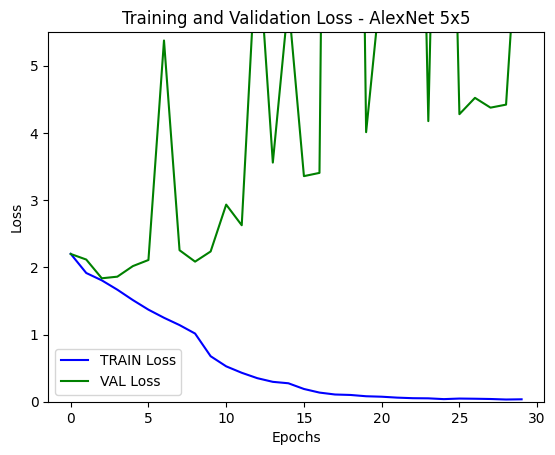

In [ ]:
checkpoint = torch.load('/content/model_alexnet_5x5_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'AlexNet 5x5', top_y=5.5, bottom_y=0)

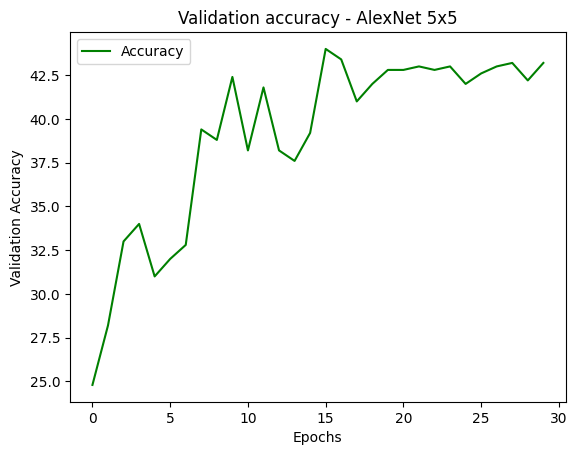

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'AlexNet 5x5')

###### AlexNet Model Testing

In [ ]:
model_testing(alexnet_model)

Test --- total:500, correct:228
Accuracy: 45.6%

Scores for each class:
n02504458 => Precision: 0.6326530612244898, Recall: 0.62, F-Score: 0.6262626262626263
n02669723 => Precision: 0.6136363636363636, Recall: 0.54, F-Score: 0.574468085106383
n03400231 => Precision: 0.59375, Recall: 0.38, F-Score: 0.46341463414634143
n04074963 => Precision: 0.35555555555555557, Recall: 0.32, F-Score: 0.3368421052631579
n03770439 => Precision: 0.4186046511627907, Recall: 0.36, F-Score: 0.38709677419354843
n02094433 => Precision: 0.4107142857142857, Recall: 0.46, F-Score: 0.43396226415094336
n04376876 => Precision: 0.25, Recall: 0.34, F-Score: 0.288135593220339
n04417672 => Precision: 0.6363636363636364, Recall: 0.56, F-Score: 0.5957446808510639
n07614500 => Precision: 0.3269230769230769, Recall: 0.34, F-Score: 0.3333333333333333
n07871810 => Precision: 0.47761194029850745, Recall: 0.64, F-Score: 0.5470085470085471

Average Precision: 0.4715812570878706, Average Recall: 0.45599999999999996, Average F-Sco

##### VGG Model

In [ ]:
#########################
####    VGG Model    ####
#########################

class VggNet_5x5(nn.Module):
  def __init__(self, aux_logits = False):
      super(VggNet_5x5, self).__init__()
      
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.fc6 = nn.Sequential(
        nn.Linear(4608, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096)
      )

      self.fc = nn.Sequential(
        nn.Linear(2*4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 24)
      )

  def forward(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    output = self.fc(output)
    return output

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/Models/ContextPrediction/5x5/VGG/model_VGGNet_5x5.pt', map_location='cuda')

vgg_model = VggNet_5x5().to(device)
vgg_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
vgg_model.fc = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)
      )

vgg_model = vgg_model.to(device)

###### VGG Model Traininig

In [ ]:
###############################################
# Initialized Optimizer, criterion, scheduler #
###############################################

optimizer = optim.Adam(vgg_model.parameters(), lr=Config_image_classification.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, 
                                           verbose=True)

In [ ]:
model_training(vgg_model, optimizer, criterion, scheduler, 'VGGNet_5x5_image_classification')

47it [00:18,  2.52it/s]
8it [00:01,  4.34it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [1/30], TRNLoss:2.2093, VALLoss:11.5082, Time:0.34


47it [00:18,  2.57it/s]
8it [00:02,  3.68it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [2/30], TRNLoss:2.0921, VALLoss:25.2522, Time:0.34


47it [00:17,  2.70it/s]
8it [00:01,  4.32it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [3/30], TRNLoss:1.9882, VALLoss:71.3558, Time:0.32


47it [00:17,  2.70it/s]
8it [00:02,  3.08it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [4/30], TRNLoss:1.9125, VALLoss:22.5388, Time:0.33


47it [00:18,  2.61it/s]
8it [00:01,  4.40it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [5/30], TRNLoss:1.8065, VALLoss:6.0096, Time:0.33


47it [00:19,  2.39it/s]
8it [00:02,  3.48it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [6/30], TRNLoss:1.7537, VALLoss:15.7599, Time:0.37


47it [00:19,  2.41it/s]
8it [00:01,  4.36it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [7/30], TRNLoss:1.6960, VALLoss:30.1753, Time:0.36


47it [00:17,  2.68it/s]
8it [00:01,  4.36it/s]


Val Progress --- total:500, correct:66
Val accuracy: 13.200%
Epoch [8/30], TRNLoss:1.6274, VALLoss:32.2001, Time:0.32


47it [00:18,  2.56it/s]
8it [00:01,  4.03it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [9/30], TRNLoss:1.6104, VALLoss:23.0268, Time:0.34


47it [00:17,  2.68it/s]
8it [00:01,  4.36it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [10/30], TRNLoss:1.6037, VALLoss:7.3055, Time:0.32


47it [00:17,  2.67it/s]
8it [00:02,  2.94it/s]


Val Progress --- total:500, correct:59
Val accuracy: 11.800%
Epoch 00011: reducing learning rate of group 0 to 1.5000e-04.
Epoch [11/30], TRNLoss:1.4749, VALLoss:15.8477, Time:0.34


47it [00:17,  2.63it/s]
8it [00:01,  4.22it/s]


Val Progress --- total:500, correct:73
Val accuracy: 14.600%
Epoch [12/30], TRNLoss:1.3223, VALLoss:15.8358, Time:0.33


47it [00:17,  2.66it/s]
8it [00:01,  4.33it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [13/30], TRNLoss:1.2390, VALLoss:28.0850, Time:0.33


47it [00:18,  2.50it/s]
8it [00:01,  4.28it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [14/30], TRNLoss:1.1777, VALLoss:26.8383, Time:0.34


47it [00:17,  2.65it/s]
8it [00:01,  4.21it/s]


Val Progress --- total:500, correct:52
Val accuracy: 10.400%
Epoch [15/30], TRNLoss:1.1168, VALLoss:16.4983, Time:0.33


47it [00:18,  2.59it/s]
8it [00:02,  2.95it/s]


Val Progress --- total:500, correct:74
Val accuracy: 14.800%
Epoch [16/30], TRNLoss:1.0514, VALLoss:15.7036, Time:0.35


47it [00:17,  2.62it/s]
8it [00:01,  4.16it/s]


Val Progress --- total:500, correct:71
Val accuracy: 14.200%
Epoch 00017: reducing learning rate of group 0 to 4.5000e-05.
Epoch [17/30], TRNLoss:1.0412, VALLoss:12.5542, Time:0.33


47it [00:17,  2.62it/s]
8it [00:02,  3.08it/s]


Val Progress --- total:500, correct:64
Val accuracy: 12.800%
Epoch [18/30], TRNLoss:0.8943, VALLoss:6.3465, Time:0.34


47it [00:18,  2.60it/s]
8it [00:01,  4.36it/s]


Val Progress --- total:500, correct:66
Val accuracy: 13.200%
Epoch [19/30], TRNLoss:0.8487, VALLoss:9.6315, Time:0.33


47it [00:17,  2.66it/s]
8it [00:01,  4.28it/s]


Val Progress --- total:500, correct:159
Val accuracy: 31.800%
Epoch [20/30], TRNLoss:0.8013, VALLoss:2.8909, Time:0.33


47it [00:18,  2.52it/s]
8it [00:02,  3.81it/s]


Val Progress --- total:500, correct:117
Val accuracy: 23.400%
Epoch [21/30], TRNLoss:0.7612, VALLoss:4.8190, Time:0.35


47it [00:17,  2.66it/s]
8it [00:01,  4.27it/s]


Val Progress --- total:500, correct:60
Val accuracy: 12.000%
Epoch [22/30], TRNLoss:0.7397, VALLoss:12.9647, Time:0.33


47it [00:17,  2.63it/s]
8it [00:02,  2.91it/s]


Val Progress --- total:500, correct:142
Val accuracy: 28.400%
Epoch [23/30], TRNLoss:0.6983, VALLoss:5.2537, Time:0.34


47it [00:17,  2.62it/s]
8it [00:01,  4.23it/s]


Val Progress --- total:500, correct:68
Val accuracy: 13.600%
Epoch [24/30], TRNLoss:0.6972, VALLoss:8.9470, Time:0.33


47it [00:17,  2.66it/s]
8it [00:02,  3.91it/s]


Val Progress --- total:500, correct:50
Val accuracy: 10.000%
Epoch [25/30], TRNLoss:0.6655, VALLoss:27.9043, Time:0.33


47it [00:18,  2.53it/s]
8it [00:01,  4.25it/s]


Val Progress --- total:500, correct:51
Val accuracy: 10.200%
Epoch 00026: reducing learning rate of group 0 to 1.3500e-05.
Epoch [26/30], TRNLoss:0.6268, VALLoss:27.6487, Time:0.34


47it [00:17,  2.64it/s]
8it [00:01,  4.22it/s]


Val Progress --- total:500, correct:200
Val accuracy: 40.000%
Epoch [27/30], TRNLoss:0.5772, VALLoss:2.6202, Time:0.33


47it [00:18,  2.58it/s]
8it [00:02,  3.22it/s]


Val Progress --- total:500, correct:158
Val accuracy: 31.600%
Epoch [28/30], TRNLoss:0.5521, VALLoss:4.4295, Time:0.35


47it [00:17,  2.66it/s]
8it [00:01,  4.27it/s]


Val Progress --- total:500, correct:205
Val accuracy: 41.000%
Epoch [29/30], TRNLoss:0.5539, VALLoss:2.4794, Time:0.33


47it [00:17,  2.65it/s]
8it [00:02,  3.10it/s]


Val Progress --- total:500, correct:196
Val accuracy: 39.200%
Epoch [30/30], TRNLoss:0.5411, VALLoss:2.7703, Time:0.34


###### VGG Model training and validation plots

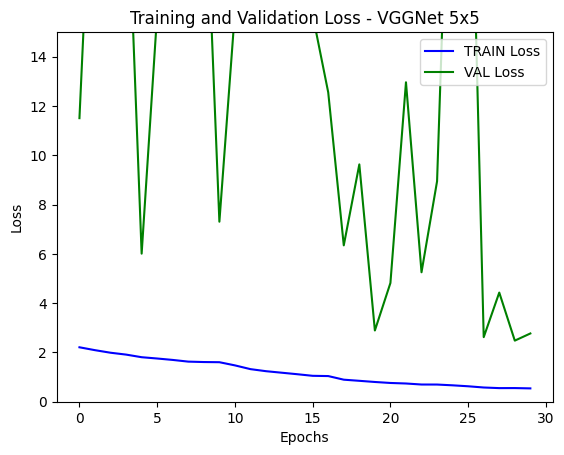

In [ ]:
checkpoint = torch.load('/content/model_VGGNet_5x5_image_classification.pt', map_location='cuda')

loss_plot(checkpoint['global_trnloss'], checkpoint['global_valloss'], 'VGGNet 5x5', top_y=15, bottom_y=0)

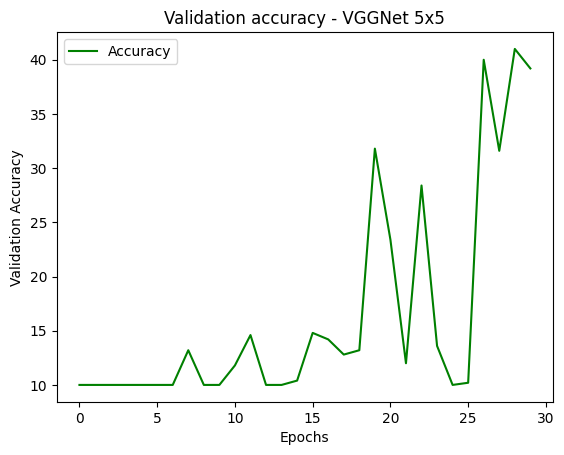

In [ ]:
accuracy_plot(checkpoint['accuracy'], 'VGGNet 5x5')

###### VGG Model Testing

In [ ]:
model_testing(vgg_model)

Test --- total:500, correct:216
Accuracy: 43.2%

Scores for each class:
n02504458 => Precision: 0.40625, Recall: 0.52, F-Score: 0.45614035087719296
n02669723 => Precision: 0.6739130434782609, Recall: 0.62, F-Score: 0.6458333333333334
n03400231 => Precision: 0.5882352941176471, Recall: 0.2, F-Score: 0.29850746268656714
n04074963 => Precision: 0.6875, Recall: 0.22, F-Score: 0.3333333333333333
n03770439 => Precision: 0.31313131313131315, Recall: 0.62, F-Score: 0.4161073825503356
n02094433 => Precision: 0.36363636363636365, Recall: 0.88, F-Score: 0.5146198830409356
n04376876 => Precision: 0.3142857142857143, Recall: 0.22, F-Score: 0.25882352941176473
n04417672 => Precision: 0.9, Recall: 0.18, F-Score: 0.3
n07614500 => Precision: 0.3333333333333333, Recall: 0.44, F-Score: 0.37931034482758624
n07871810 => Precision: 0.8076923076923077, Recall: 0.42, F-Score: 0.5526315789473685

Average Precision: 0.538797736967494, Average Recall: 0.43200000000000005, Average F-Score: 0.4155307199008417
